In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.fc0   = nn.Linear(input_length, hidden_0)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.relu0 = nn.ReLU()
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = nn.Linear(hidden_0, hidden_1)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = nn.Linear(hidden_1, hidden_2)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_2, output_length)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.drop0(self.relu0(self.bn0(self.fc0(out))))
        out = self.drop1(self.relu1(self.bn1(self.fc1(out))))
        out = self.drop2(self.relu2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2457, Acc: 0.9248 | Val Loss: 0.1516, Acc: 0.9534


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9631 | Val Loss: 0.1056, Acc: 0.9697


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 0.0879, Acc: 0.9737


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9758 | Val Loss: 0.0952, Acc: 0.9719


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9788 | Val Loss: 0.0861, Acc: 0.9732


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.0818, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.0881, Acc: 0.9742


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.0786, Acc: 0.9775


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9867 | Val Loss: 0.0846, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.0863, Acc: 0.9784


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.0857, Acc: 0.9773


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9891 | Val Loss: 0.0849, Acc: 0.9783


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0761, Acc: 0.9803


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0861, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0949, Acc: 0.9761


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0968, Acc: 0.9772


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0840, Acc: 0.9806


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0894, Acc: 0.9777


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0899, Acc: 0.9780


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0855, Acc: 0.9784


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0928, Acc: 0.9789


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0855, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0963, Acc: 0.9792


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9957 | Val Loss: 0.0945, Acc: 0.9789


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1038, Acc: 0.9792


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1003, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.0922, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1154, Acc: 0.9783


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0962, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1139, Acc: 0.9786


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0969, Acc: 0.9807


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.0870, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0963, Acc: 0.9814


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1074, Acc: 0.9795


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1002, Acc: 0.9806


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0897, Acc: 0.9815


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0946, Acc: 0.9814


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0932, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1096, Acc: 0.9785


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0878, Acc: 0.9820


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0933, Acc: 0.9800


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0896, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.0980, Acc: 0.9808


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1018, Acc: 0.9808


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1041, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0997, Acc: 0.9815


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0997, Acc: 0.9812


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1099, Acc: 0.9801


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.0986, Acc: 0.9812


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1091, Acc: 0.9803


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1117, Acc: 0.9816


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1097, Acc: 0.9800


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1063, Acc: 0.9804


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1192, Acc: 0.9808


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1125, Acc: 0.9815


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1098, Acc: 0.9809


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1145, Acc: 0.9799


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1007, Acc: 0.9815


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1087, Acc: 0.9812


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1149, Acc: 0.9805


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9814


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1210, Acc: 0.9798


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1157, Acc: 0.9799


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1132, Acc: 0.9808


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1231, Acc: 0.9820


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1198, Acc: 0.9805


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1151, Acc: 0.9792


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1162, Acc: 0.9822


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1298, Acc: 0.9799


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1199, Acc: 0.9821


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1157, Acc: 0.9818


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1278, Acc: 0.9806


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1185, Acc: 0.9811


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1125, Acc: 0.9814


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1105, Acc: 0.9828


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1041, Acc: 0.9832


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1102, Acc: 0.9826


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1265, Acc: 0.9802


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1128, Acc: 0.9819


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1025, Acc: 0.9833


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1290, Acc: 0.9810


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1133, Acc: 0.9819


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1152, Acc: 0.9816


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1246, Acc: 0.9816


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9978 | Val Loss: 0.1131, Acc: 0.9811


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1136, Acc: 0.9812


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1055, Acc: 0.9832


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1118, Acc: 0.9818


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1215, Acc: 0.9805


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1079, Acc: 0.9828


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1204, Acc: 0.9806


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1178, Acc: 0.9824


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1292, Acc: 0.9809


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1260, Acc: 0.9801


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1213, Acc: 0.9817


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1296, Acc: 0.9805


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1265, Acc: 0.9823


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1212, Acc: 0.9815


Final Test Loss: 0.1284 Accuracy: 0.9814


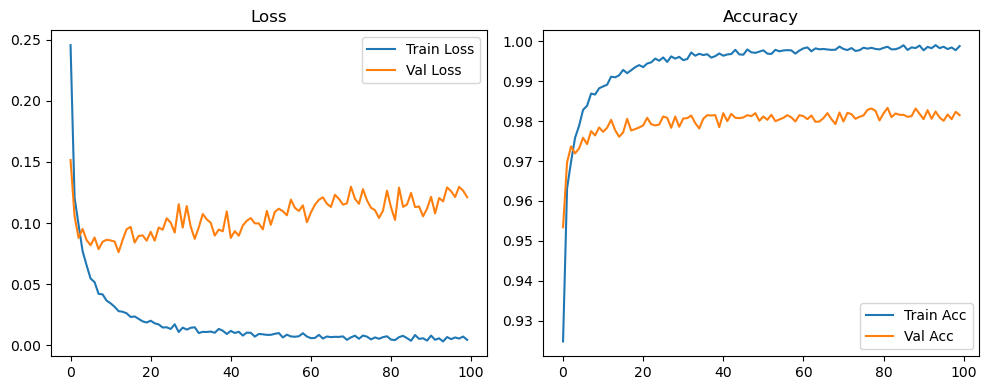

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2914, Acc: 0.9108 | Val Loss: 0.1449, Acc: 0.9548


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1633, Acc: 0.9515 | Val Loss: 0.1025, Acc: 0.9693


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9584 | Val Loss: 0.1019, Acc: 0.9691


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9646 | Val Loss: 0.0888, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9677 | Val Loss: 0.0942, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9711 | Val Loss: 0.0755, Acc: 0.9769


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9737 | Val Loss: 0.0768, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9741 | Val Loss: 0.0732, Acc: 0.9772


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9759 | Val Loss: 0.0705, Acc: 0.9790


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9785 | Val Loss: 0.0739, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9796 | Val Loss: 0.0761, Acc: 0.9793


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9801 | Val Loss: 0.0763, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9815 | Val Loss: 0.0782, Acc: 0.9797


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9816 | Val Loss: 0.0791, Acc: 0.9784


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9822 | Val Loss: 0.0772, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9836 | Val Loss: 0.0790, Acc: 0.9787


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.0749, Acc: 0.9812


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.0710, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9841 | Val Loss: 0.0796, Acc: 0.9788


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9853 | Val Loss: 0.0708, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9861 | Val Loss: 0.0729, Acc: 0.9814


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9863 | Val Loss: 0.0717, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0828, Acc: 0.9802


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0733, Acc: 0.9824


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0871, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.0817, Acc: 0.9820


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0846, Acc: 0.9799


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.0746, Acc: 0.9814


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0808, Acc: 0.9817


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.0777, Acc: 0.9827


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0798, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0850, Acc: 0.9822


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9903 | Val Loss: 0.0692, Acc: 0.9837


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0753, Acc: 0.9831


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0712, Acc: 0.9823


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.0874, Acc: 0.9814


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9909 | Val Loss: 0.0716, Acc: 0.9834


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0782, Acc: 0.9819


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9913 | Val Loss: 0.0841, Acc: 0.9826


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9905 | Val Loss: 0.0844, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0801, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9915 | Val Loss: 0.0818, Acc: 0.9814


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0813, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0939, Acc: 0.9809


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0869, Acc: 0.9817


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0754, Acc: 0.9817


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.0777, Acc: 0.9825


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0870, Acc: 0.9824


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0795, Acc: 0.9836


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0806, Acc: 0.9826


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0852, Acc: 0.9826


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0811, Acc: 0.9822


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0820, Acc: 0.9828


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.0837, Acc: 0.9829


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0891, Acc: 0.9822


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.0762, Acc: 0.9828


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0832, Acc: 0.9833


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0915, Acc: 0.9823


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.0911, Acc: 0.9820


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0799, Acc: 0.9827


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.0812, Acc: 0.9828


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.0819, Acc: 0.9832


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.0865, Acc: 0.9840


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9940 | Val Loss: 0.0869, Acc: 0.9832


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9939 | Val Loss: 0.0884, Acc: 0.9825


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9940 | Val Loss: 0.0850, Acc: 0.9832


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9938 | Val Loss: 0.0872, Acc: 0.9838


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9942 | Val Loss: 0.0821, Acc: 0.9842


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9948 | Val Loss: 0.0918, Acc: 0.9823


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0867, Acc: 0.9834


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0909, Acc: 0.9826


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0925, Acc: 0.9838


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9941 | Val Loss: 0.0857, Acc: 0.9837


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9934 | Val Loss: 0.0947, Acc: 0.9807


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0821, Acc: 0.9825


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9947 | Val Loss: 0.0924, Acc: 0.9829


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.0907, Acc: 0.9839


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0995, Acc: 0.9825


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.0900, Acc: 0.9828


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.0811, Acc: 0.9822


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.0934, Acc: 0.9817


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9949 | Val Loss: 0.0955, Acc: 0.9819


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.0887, Acc: 0.9836


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9942 | Val Loss: 0.0789, Acc: 0.9841


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0871, Acc: 0.9827


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0917, Acc: 0.9828


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.0938, Acc: 0.9829


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0896, Acc: 0.9838


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.0946, Acc: 0.9830


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1014, Acc: 0.9818


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.0952, Acc: 0.9842


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9944 | Val Loss: 0.0973, Acc: 0.9829


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0875, Acc: 0.9849


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0802, Acc: 0.9841


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.0894, Acc: 0.9831


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9948 | Val Loss: 0.1028, Acc: 0.9815


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1011, Acc: 0.9831


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0868, Acc: 0.9838


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.1055, Acc: 0.9828


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0988, Acc: 0.9829


Final Test Loss: 0.0839 Accuracy: 0.9849


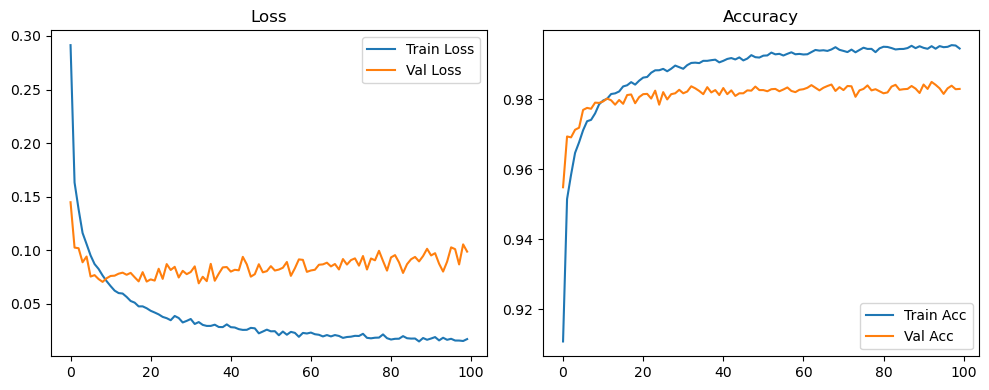

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4516, Acc: 0.8636 | Val Loss: 0.1741, Acc: 0.9491


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2832, Acc: 0.9177 | Val Loss: 0.1378, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2486, Acc: 0.9271 | Val Loss: 0.1262, Acc: 0.9634


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2244, Acc: 0.9349 | Val Loss: 0.1203, Acc: 0.9629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2128, Acc: 0.9389 | Val Loss: 0.1043, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1924, Acc: 0.9439 | Val Loss: 0.0957, Acc: 0.9720


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9459 | Val Loss: 0.0932, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1762, Acc: 0.9500 | Val Loss: 0.0931, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1698, Acc: 0.9509 | Val Loss: 0.0899, Acc: 0.9730


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1668, Acc: 0.9515 | Val Loss: 0.0850, Acc: 0.9747


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1592, Acc: 0.9538 | Val Loss: 0.0869, Acc: 0.9757


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1543, Acc: 0.9546 | Val Loss: 0.0809, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9577 | Val Loss: 0.0789, Acc: 0.9774


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9575 | Val Loss: 0.0844, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1433, Acc: 0.9584 | Val Loss: 0.0842, Acc: 0.9766


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9593 | Val Loss: 0.0793, Acc: 0.9777


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9606 | Val Loss: 0.0782, Acc: 0.9779


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1305, Acc: 0.9614 | Val Loss: 0.0774, Acc: 0.9773


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9615 | Val Loss: 0.0841, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9640 | Val Loss: 0.0765, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1226, Acc: 0.9651 | Val Loss: 0.0752, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9641 | Val Loss: 0.0774, Acc: 0.9775


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1237, Acc: 0.9643 | Val Loss: 0.0775, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1175, Acc: 0.9661 | Val Loss: 0.0763, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9665 | Val Loss: 0.0792, Acc: 0.9790


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1175, Acc: 0.9655 | Val Loss: 0.0737, Acc: 0.9789


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9667 | Val Loss: 0.0796, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9663 | Val Loss: 0.0768, Acc: 0.9788


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9689 | Val Loss: 0.0710, Acc: 0.9810


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1060, Acc: 0.9693 | Val Loss: 0.0751, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9677 | Val Loss: 0.0704, Acc: 0.9798


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1040, Acc: 0.9690 | Val Loss: 0.0749, Acc: 0.9799


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9685 | Val Loss: 0.0755, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1047, Acc: 0.9691 | Val Loss: 0.0722, Acc: 0.9800


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9697 | Val Loss: 0.0738, Acc: 0.9801


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9721 | Val Loss: 0.0731, Acc: 0.9793


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9717 | Val Loss: 0.0722, Acc: 0.9801


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0998, Acc: 0.9710 | Val Loss: 0.0689, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9712 | Val Loss: 0.0723, Acc: 0.9806


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9714 | Val Loss: 0.0677, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9717 | Val Loss: 0.0742, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9730 | Val Loss: 0.0742, Acc: 0.9812


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9721 | Val Loss: 0.0728, Acc: 0.9804


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9724 | Val Loss: 0.0738, Acc: 0.9805


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9745 | Val Loss: 0.0740, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9731 | Val Loss: 0.0743, Acc: 0.9801


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9728 | Val Loss: 0.0767, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9739 | Val Loss: 0.0731, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9729 | Val Loss: 0.0754, Acc: 0.9805


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9724 | Val Loss: 0.0725, Acc: 0.9803


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9738 | Val Loss: 0.0722, Acc: 0.9809


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9747 | Val Loss: 0.0745, Acc: 0.9812


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0876, Acc: 0.9739 | Val Loss: 0.0749, Acc: 0.9805


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0873, Acc: 0.9748 | Val Loss: 0.0792, Acc: 0.9796


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9748 | Val Loss: 0.0759, Acc: 0.9804


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9757 | Val Loss: 0.0722, Acc: 0.9811


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0845, Acc: 0.9753 | Val Loss: 0.0704, Acc: 0.9807


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0830, Acc: 0.9756 | Val Loss: 0.0762, Acc: 0.9798


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9763 | Val Loss: 0.0742, Acc: 0.9810


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0847, Acc: 0.9750 | Val Loss: 0.0753, Acc: 0.9803


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9762 | Val Loss: 0.0729, Acc: 0.9817


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9762 | Val Loss: 0.0790, Acc: 0.9812


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9764 | Val Loss: 0.0852, Acc: 0.9798


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9756 | Val Loss: 0.0813, Acc: 0.9807


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0815, Acc: 0.9772 | Val Loss: 0.0742, Acc: 0.9805


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9774 | Val Loss: 0.0738, Acc: 0.9812


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9760 | Val Loss: 0.0700, Acc: 0.9817


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9767 | Val Loss: 0.0784, Acc: 0.9802


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9771 | Val Loss: 0.0786, Acc: 0.9800


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9774 | Val Loss: 0.0802, Acc: 0.9806


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9768 | Val Loss: 0.0710, Acc: 0.9808


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9779 | Val Loss: 0.0773, Acc: 0.9794


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9782 | Val Loss: 0.0702, Acc: 0.9814


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9767 | Val Loss: 0.0738, Acc: 0.9810


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9772 | Val Loss: 0.0802, Acc: 0.9798


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9780 | Val Loss: 0.0787, Acc: 0.9808


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9793 | Val Loss: 0.0781, Acc: 0.9815


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9785 | Val Loss: 0.0782, Acc: 0.9818


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9769 | Val Loss: 0.0770, Acc: 0.9818


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9789 | Val Loss: 0.0714, Acc: 0.9821


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9779 | Val Loss: 0.0807, Acc: 0.9808


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9792 | Val Loss: 0.0789, Acc: 0.9813


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9790 | Val Loss: 0.0780, Acc: 0.9800


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9791 | Val Loss: 0.0826, Acc: 0.9788


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9794 | Val Loss: 0.0825, Acc: 0.9808


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0735, Acc: 0.9788 | Val Loss: 0.0868, Acc: 0.9783


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9796 | Val Loss: 0.0714, Acc: 0.9815


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9805 | Val Loss: 0.0770, Acc: 0.9808


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9790 | Val Loss: 0.0809, Acc: 0.9804


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9811 | Val Loss: 0.0815, Acc: 0.9805


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9784 | Val Loss: 0.0818, Acc: 0.9808


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9802 | Val Loss: 0.0856, Acc: 0.9792


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9803 | Val Loss: 0.0739, Acc: 0.9812


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9797 | Val Loss: 0.0873, Acc: 0.9802


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9803 | Val Loss: 0.0742, Acc: 0.9813


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9798 | Val Loss: 0.0786, Acc: 0.9816


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9809 | Val Loss: 0.0793, Acc: 0.9812


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9791 | Val Loss: 0.0741, Acc: 0.9812


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9796 | Val Loss: 0.0792, Acc: 0.9804


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9794 | Val Loss: 0.0837, Acc: 0.9809


Final Test Loss: 0.0691 Accuracy: 0.9843


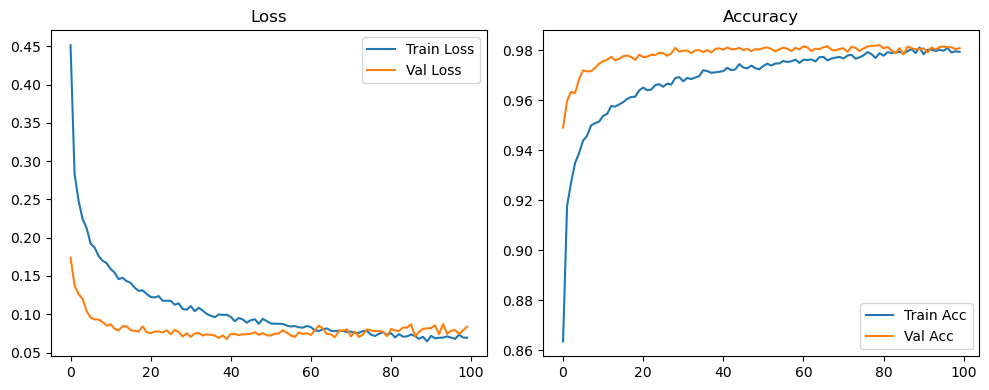

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2457, Acc: 0.9248 | Val Loss: 0.1516, Acc: 0.9534


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9631 | Val Loss: 0.1056, Acc: 0.9697


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 0.0879, Acc: 0.9737


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9758 | Val Loss: 0.0952, Acc: 0.9719


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9788 | Val Loss: 0.0861, Acc: 0.9732


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.0818, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.0881, Acc: 0.9742


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.0786, Acc: 0.9775


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9867 | Val Loss: 0.0846, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.0863, Acc: 0.9784


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.0857, Acc: 0.9773


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9891 | Val Loss: 0.0849, Acc: 0.9783


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0761, Acc: 0.9803


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0861, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0949, Acc: 0.9761


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0968, Acc: 0.9772


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0840, Acc: 0.9806


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0894, Acc: 0.9777


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0899, Acc: 0.9780


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0855, Acc: 0.9784


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0928, Acc: 0.9789


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0855, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0963, Acc: 0.9792


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9957 | Val Loss: 0.0945, Acc: 0.9789


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1038, Acc: 0.9792


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1003, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.0922, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1154, Acc: 0.9783


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0962, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1139, Acc: 0.9786


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0969, Acc: 0.9807


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.0870, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0963, Acc: 0.9814


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1074, Acc: 0.9795


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1002, Acc: 0.9806


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0897, Acc: 0.9815


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0946, Acc: 0.9814


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0932, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1096, Acc: 0.9785


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0878, Acc: 0.9820


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0933, Acc: 0.9800


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0896, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.0980, Acc: 0.9808


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1018, Acc: 0.9808


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1041, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0997, Acc: 0.9815


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0997, Acc: 0.9812


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1099, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0949, Acc: 0.9827


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0987, Acc: 0.9841


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1013, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1010, Acc: 0.9837


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1165, Acc: 0.9822


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1069, Acc: 0.9832


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1137, Acc: 0.9831


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1045, Acc: 0.9832


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1189, Acc: 0.9825


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1169, Acc: 0.9837


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1183, Acc: 0.9831


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1094, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1128, Acc: 0.9842


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1182, Acc: 0.9830


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1238, Acc: 0.9823


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1174, Acc: 0.9827


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1237, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1220, Acc: 0.9827


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1234, Acc: 0.9823


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1297, Acc: 0.9824


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1381, Acc: 0.9820


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1481, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1331, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1371, Acc: 0.9819


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1326, Acc: 0.9819


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1371, Acc: 0.9812


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1298, Acc: 0.9821


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1156, Acc: 0.9829


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1237, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1235, Acc: 0.9831


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1161, Acc: 0.9828


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1171, Acc: 0.9835


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1232, Acc: 0.9838


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1186, Acc: 0.9839


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1210, Acc: 0.9842


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1240, Acc: 0.9847


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1240, Acc: 0.9838


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1312, Acc: 0.9835


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1330, Acc: 0.9823


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1269, Acc: 0.9838


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1259, Acc: 0.9839


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1251, Acc: 0.9838


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1208, Acc: 0.9835


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1234, Acc: 0.9842


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1257, Acc: 0.9842


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1249, Acc: 0.9842


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1308, Acc: 0.9833


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1387, Acc: 0.9840


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1372, Acc: 0.9840


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1339, Acc: 0.9841


Final Test Loss: 0.1279 Accuracy: 0.9853


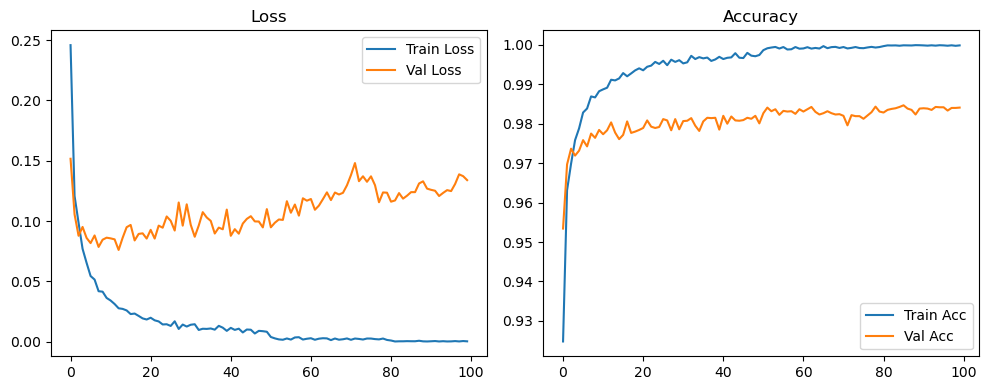

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2914, Acc: 0.9108 | Val Loss: 0.1449, Acc: 0.9548


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1633, Acc: 0.9515 | Val Loss: 0.1025, Acc: 0.9693


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9584 | Val Loss: 0.1019, Acc: 0.9691


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9646 | Val Loss: 0.0888, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9677 | Val Loss: 0.0942, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9711 | Val Loss: 0.0755, Acc: 0.9769


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9737 | Val Loss: 0.0768, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9741 | Val Loss: 0.0732, Acc: 0.9772


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9759 | Val Loss: 0.0705, Acc: 0.9790


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9785 | Val Loss: 0.0739, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9796 | Val Loss: 0.0761, Acc: 0.9793


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9801 | Val Loss: 0.0763, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9815 | Val Loss: 0.0782, Acc: 0.9797


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9816 | Val Loss: 0.0791, Acc: 0.9784


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9822 | Val Loss: 0.0772, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9836 | Val Loss: 0.0790, Acc: 0.9787


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.0749, Acc: 0.9812


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.0710, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9841 | Val Loss: 0.0796, Acc: 0.9788


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9853 | Val Loss: 0.0708, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9861 | Val Loss: 0.0729, Acc: 0.9814


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9863 | Val Loss: 0.0717, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0828, Acc: 0.9802


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0733, Acc: 0.9824


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0871, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.0817, Acc: 0.9820


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0846, Acc: 0.9799


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.0746, Acc: 0.9814


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0808, Acc: 0.9817


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.0777, Acc: 0.9827


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0798, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0850, Acc: 0.9822


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9903 | Val Loss: 0.0692, Acc: 0.9837


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0753, Acc: 0.9831


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0712, Acc: 0.9823


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.0874, Acc: 0.9814


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9909 | Val Loss: 0.0716, Acc: 0.9834


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0782, Acc: 0.9819


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9913 | Val Loss: 0.0841, Acc: 0.9826


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9905 | Val Loss: 0.0844, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0801, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9915 | Val Loss: 0.0818, Acc: 0.9814


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0813, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0939, Acc: 0.9809


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0869, Acc: 0.9817


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0754, Acc: 0.9817


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.0777, Acc: 0.9825


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0870, Acc: 0.9824


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0795, Acc: 0.9836


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0806, Acc: 0.9826


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.0790, Acc: 0.9840


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0804, Acc: 0.9847


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0828, Acc: 0.9838


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0827, Acc: 0.9848


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0862, Acc: 0.9843


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0897, Acc: 0.9829


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0821, Acc: 0.9844


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0844, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0962, Acc: 0.9843


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0866, Acc: 0.9849


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.0831, Acc: 0.9839


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0811, Acc: 0.9852


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0891, Acc: 0.9837


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0951, Acc: 0.9840


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0964, Acc: 0.9849


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9834


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0864, Acc: 0.9846


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0916, Acc: 0.9853


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1023, Acc: 0.9823


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0928, Acc: 0.9830


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0877, Acc: 0.9843


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0945, Acc: 0.9834


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0891, Acc: 0.9845


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0900, Acc: 0.9833


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0865, Acc: 0.9843


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0912, Acc: 0.9836


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0860, Acc: 0.9853


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0913, Acc: 0.9844


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0888, Acc: 0.9845


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0808, Acc: 0.9852


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0799, Acc: 0.9859


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0786, Acc: 0.9855


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0859, Acc: 0.9852


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0820, Acc: 0.9855


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0822, Acc: 0.9858


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0857, Acc: 0.9855


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0805, Acc: 0.9852


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0848, Acc: 0.9851


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0879, Acc: 0.9857


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0876, Acc: 0.9860


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0928, Acc: 0.9851


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0910, Acc: 0.9852


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0860, Acc: 0.9851


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0876, Acc: 0.9851


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0889, Acc: 0.9851


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0915, Acc: 0.9852


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0901, Acc: 0.9849


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0933, Acc: 0.9852


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0920, Acc: 0.9853


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0891, Acc: 0.9858


Final Test Loss: 0.0885 Accuracy: 0.9863


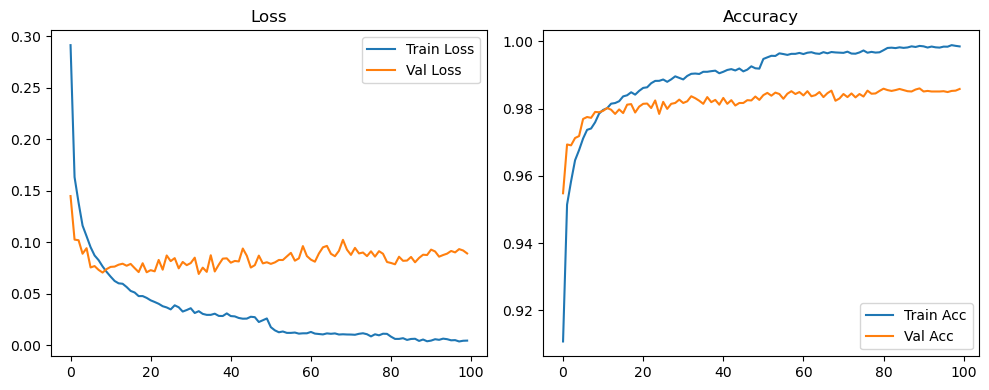

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4516, Acc: 0.8636 | Val Loss: 0.1741, Acc: 0.9491


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2832, Acc: 0.9177 | Val Loss: 0.1378, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2486, Acc: 0.9271 | Val Loss: 0.1262, Acc: 0.9634


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2244, Acc: 0.9349 | Val Loss: 0.1203, Acc: 0.9629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2128, Acc: 0.9389 | Val Loss: 0.1043, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1924, Acc: 0.9439 | Val Loss: 0.0957, Acc: 0.9720


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9459 | Val Loss: 0.0932, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1762, Acc: 0.9500 | Val Loss: 0.0931, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1698, Acc: 0.9509 | Val Loss: 0.0899, Acc: 0.9730


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1668, Acc: 0.9515 | Val Loss: 0.0850, Acc: 0.9747


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1592, Acc: 0.9538 | Val Loss: 0.0869, Acc: 0.9757


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1543, Acc: 0.9546 | Val Loss: 0.0809, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9577 | Val Loss: 0.0789, Acc: 0.9774


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9575 | Val Loss: 0.0844, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1433, Acc: 0.9584 | Val Loss: 0.0842, Acc: 0.9766


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9593 | Val Loss: 0.0793, Acc: 0.9777


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9606 | Val Loss: 0.0782, Acc: 0.9779


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1305, Acc: 0.9614 | Val Loss: 0.0774, Acc: 0.9773


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9615 | Val Loss: 0.0841, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9640 | Val Loss: 0.0765, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1226, Acc: 0.9651 | Val Loss: 0.0752, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9641 | Val Loss: 0.0774, Acc: 0.9775


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1237, Acc: 0.9643 | Val Loss: 0.0775, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1175, Acc: 0.9661 | Val Loss: 0.0763, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9665 | Val Loss: 0.0792, Acc: 0.9790


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1175, Acc: 0.9655 | Val Loss: 0.0737, Acc: 0.9789


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9667 | Val Loss: 0.0796, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9663 | Val Loss: 0.0768, Acc: 0.9788


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9689 | Val Loss: 0.0710, Acc: 0.9810


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1060, Acc: 0.9693 | Val Loss: 0.0751, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9677 | Val Loss: 0.0704, Acc: 0.9798


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1040, Acc: 0.9690 | Val Loss: 0.0749, Acc: 0.9799


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9685 | Val Loss: 0.0755, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1047, Acc: 0.9691 | Val Loss: 0.0722, Acc: 0.9800


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9697 | Val Loss: 0.0738, Acc: 0.9801


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9721 | Val Loss: 0.0731, Acc: 0.9793


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9717 | Val Loss: 0.0722, Acc: 0.9801


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0998, Acc: 0.9710 | Val Loss: 0.0689, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9712 | Val Loss: 0.0723, Acc: 0.9806


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9714 | Val Loss: 0.0677, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9717 | Val Loss: 0.0742, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9730 | Val Loss: 0.0742, Acc: 0.9812


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9721 | Val Loss: 0.0728, Acc: 0.9804


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9724 | Val Loss: 0.0738, Acc: 0.9805


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9745 | Val Loss: 0.0740, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9731 | Val Loss: 0.0743, Acc: 0.9801


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9728 | Val Loss: 0.0767, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9739 | Val Loss: 0.0731, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9729 | Val Loss: 0.0754, Acc: 0.9805


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9724 | Val Loss: 0.0725, Acc: 0.9803


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9780 | Val Loss: 0.0672, Acc: 0.9819


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9794 | Val Loss: 0.0735, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9791 | Val Loss: 0.0681, Acc: 0.9824


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9805 | Val Loss: 0.0742, Acc: 0.9819


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9811 | Val Loss: 0.0713, Acc: 0.9815


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9813 | Val Loss: 0.0693, Acc: 0.9822


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9810 | Val Loss: 0.0688, Acc: 0.9824


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9814 | Val Loss: 0.0720, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9819 | Val Loss: 0.0728, Acc: 0.9812


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9816 | Val Loss: 0.0729, Acc: 0.9818


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9819 | Val Loss: 0.0722, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9820 | Val Loss: 0.0740, Acc: 0.9828


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9827 | Val Loss: 0.0775, Acc: 0.9819


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9821 | Val Loss: 0.0723, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.0734, Acc: 0.9818


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9828 | Val Loss: 0.0683, Acc: 0.9817


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9825 | Val Loss: 0.0678, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9831 | Val Loss: 0.0721, Acc: 0.9820


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9832 | Val Loss: 0.0704, Acc: 0.9822


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9836 | Val Loss: 0.0745, Acc: 0.9828


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9836 | Val Loss: 0.0698, Acc: 0.9822


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9838 | Val Loss: 0.0785, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9840 | Val Loss: 0.0690, Acc: 0.9821


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9829 | Val Loss: 0.0693, Acc: 0.9828


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9836 | Val Loss: 0.0749, Acc: 0.9817


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9833 | Val Loss: 0.0710, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9846 | Val Loss: 0.0724, Acc: 0.9819


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9830 | Val Loss: 0.0711, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9819 | Val Loss: 0.0718, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9841 | Val Loss: 0.0698, Acc: 0.9831


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9854 | Val Loss: 0.0711, Acc: 0.9828


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.0699, Acc: 0.9832


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9864 | Val Loss: 0.0725, Acc: 0.9831


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9866 | Val Loss: 0.0716, Acc: 0.9829


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9870 | Val Loss: 0.0730, Acc: 0.9826


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9878 | Val Loss: 0.0724, Acc: 0.9826


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9879 | Val Loss: 0.0727, Acc: 0.9829


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9882 | Val Loss: 0.0711, Acc: 0.9833


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9875 | Val Loss: 0.0711, Acc: 0.9832


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.0757, Acc: 0.9828


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9881 | Val Loss: 0.0743, Acc: 0.9825


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9885 | Val Loss: 0.0774, Acc: 0.9812


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9887 | Val Loss: 0.0712, Acc: 0.9829


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.0765, Acc: 0.9823


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9880 | Val Loss: 0.0711, Acc: 0.9822


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.0732, Acc: 0.9824


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9882 | Val Loss: 0.0721, Acc: 0.9834


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9878 | Val Loss: 0.0695, Acc: 0.9834


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9883 | Val Loss: 0.0737, Acc: 0.9828


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9879 | Val Loss: 0.0731, Acc: 0.9828


Final Test Loss: 0.0692 Accuracy: 0.9841


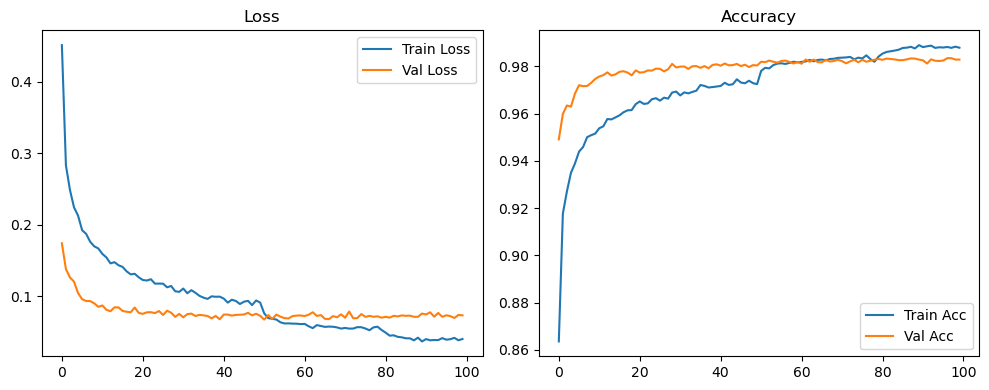

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2457, Acc: 0.9248 | Val Loss: 0.1516, Acc: 0.9534


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9631 | Val Loss: 0.1056, Acc: 0.9697


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 0.0879, Acc: 0.9737


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9758 | Val Loss: 0.0952, Acc: 0.9719


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9788 | Val Loss: 0.0861, Acc: 0.9732


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.0818, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.0881, Acc: 0.9742


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.0786, Acc: 0.9775


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9867 | Val Loss: 0.0846, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.0863, Acc: 0.9784


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.0857, Acc: 0.9773


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9891 | Val Loss: 0.0849, Acc: 0.9783


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0761, Acc: 0.9803


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0861, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0949, Acc: 0.9761


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0968, Acc: 0.9772


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0840, Acc: 0.9806


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0894, Acc: 0.9777


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0899, Acc: 0.9780


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0855, Acc: 0.9784


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0928, Acc: 0.9789


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0855, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0963, Acc: 0.9792


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9957 | Val Loss: 0.0945, Acc: 0.9789


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1038, Acc: 0.9792


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1003, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.0922, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1154, Acc: 0.9783


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0962, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1139, Acc: 0.9786


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0969, Acc: 0.9807


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.0870, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0963, Acc: 0.9814


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1074, Acc: 0.9795


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1002, Acc: 0.9806


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0897, Acc: 0.9815


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0946, Acc: 0.9814


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0932, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1096, Acc: 0.9785


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0878, Acc: 0.9820


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0933, Acc: 0.9800


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0896, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.0980, Acc: 0.9808


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1018, Acc: 0.9808


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1041, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0997, Acc: 0.9815


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0997, Acc: 0.9812


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1099, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0949, Acc: 0.9827


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0987, Acc: 0.9841


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1013, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1010, Acc: 0.9837


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1165, Acc: 0.9822


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1069, Acc: 0.9832


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1137, Acc: 0.9831


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1045, Acc: 0.9832


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1189, Acc: 0.9825


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1169, Acc: 0.9837


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1183, Acc: 0.9831


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1094, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1128, Acc: 0.9842


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1182, Acc: 0.9830


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1238, Acc: 0.9823


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1174, Acc: 0.9827


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1237, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1220, Acc: 0.9827


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1234, Acc: 0.9823


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1297, Acc: 0.9824


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1381, Acc: 0.9820


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1481, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1331, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1371, Acc: 0.9819


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1326, Acc: 0.9819


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1371, Acc: 0.9812


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1298, Acc: 0.9821


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1156, Acc: 0.9829


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1237, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1235, Acc: 0.9831


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1158, Acc: 0.9828


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1168, Acc: 0.9834


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1204, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1139, Acc: 0.9844


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1133, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1160, Acc: 0.9849


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1176, Acc: 0.9842


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1220, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1243, Acc: 0.9840


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1218, Acc: 0.9837


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1194, Acc: 0.9841


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1205, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1195, Acc: 0.9840


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1227, Acc: 0.9841


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1249, Acc: 0.9833


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1249, Acc: 0.9835


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1266, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1279, Acc: 0.9839


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1305, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1268, Acc: 0.9841


Final Test Loss: 0.1244 Accuracy: 0.9850


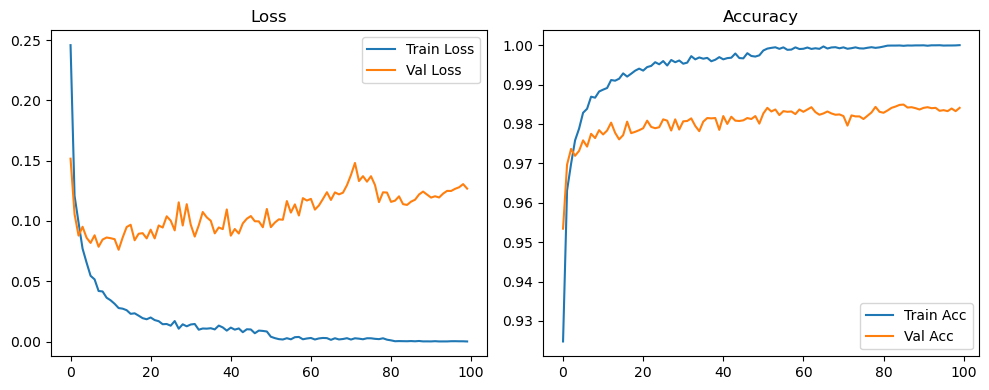

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2914, Acc: 0.9108 | Val Loss: 0.1449, Acc: 0.9548


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1633, Acc: 0.9515 | Val Loss: 0.1025, Acc: 0.9693


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9584 | Val Loss: 0.1019, Acc: 0.9691


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9646 | Val Loss: 0.0888, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9677 | Val Loss: 0.0942, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9711 | Val Loss: 0.0755, Acc: 0.9769


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9737 | Val Loss: 0.0768, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9741 | Val Loss: 0.0732, Acc: 0.9772


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9759 | Val Loss: 0.0705, Acc: 0.9790


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9785 | Val Loss: 0.0739, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9796 | Val Loss: 0.0761, Acc: 0.9793


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9801 | Val Loss: 0.0763, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9815 | Val Loss: 0.0782, Acc: 0.9797


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9816 | Val Loss: 0.0791, Acc: 0.9784


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9822 | Val Loss: 0.0772, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9836 | Val Loss: 0.0790, Acc: 0.9787


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.0749, Acc: 0.9812


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.0710, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9841 | Val Loss: 0.0796, Acc: 0.9788


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9853 | Val Loss: 0.0708, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9861 | Val Loss: 0.0729, Acc: 0.9814


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9863 | Val Loss: 0.0717, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0828, Acc: 0.9802


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0733, Acc: 0.9824


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0871, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.0817, Acc: 0.9820


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0846, Acc: 0.9799


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.0746, Acc: 0.9814


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0808, Acc: 0.9817


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.0777, Acc: 0.9827


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0798, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0850, Acc: 0.9822


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9903 | Val Loss: 0.0692, Acc: 0.9837


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0753, Acc: 0.9831


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0712, Acc: 0.9823


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.0874, Acc: 0.9814


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9909 | Val Loss: 0.0716, Acc: 0.9834


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0782, Acc: 0.9819


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9913 | Val Loss: 0.0841, Acc: 0.9826


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9905 | Val Loss: 0.0844, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0801, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9915 | Val Loss: 0.0818, Acc: 0.9814


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0813, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0939, Acc: 0.9809


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0869, Acc: 0.9817


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0754, Acc: 0.9817


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.0777, Acc: 0.9825


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0870, Acc: 0.9824


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0795, Acc: 0.9836


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0806, Acc: 0.9826


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.0790, Acc: 0.9840


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0804, Acc: 0.9847


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0828, Acc: 0.9838


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0827, Acc: 0.9848


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0862, Acc: 0.9843


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0897, Acc: 0.9829


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0821, Acc: 0.9844


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0844, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0962, Acc: 0.9843


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0866, Acc: 0.9849


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.0831, Acc: 0.9839


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0811, Acc: 0.9852


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0891, Acc: 0.9837


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0951, Acc: 0.9840


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0964, Acc: 0.9849


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9834


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0864, Acc: 0.9846


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0916, Acc: 0.9853


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1023, Acc: 0.9823


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0928, Acc: 0.9830


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0877, Acc: 0.9843


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0945, Acc: 0.9834


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0891, Acc: 0.9845


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0900, Acc: 0.9833


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0865, Acc: 0.9843


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0912, Acc: 0.9836


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0860, Acc: 0.9853


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0913, Acc: 0.9844


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0888, Acc: 0.9845


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0808, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0795, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0781, Acc: 0.9859


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0842, Acc: 0.9860


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0786, Acc: 0.9853


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0795, Acc: 0.9856


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0819, Acc: 0.9863


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0772, Acc: 0.9865


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0828, Acc: 0.9848


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0848, Acc: 0.9859


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0835, Acc: 0.9863


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0847, Acc: 0.9857


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0857, Acc: 0.9859


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0814, Acc: 0.9857


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0823, Acc: 0.9862


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0837, Acc: 0.9861


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0854, Acc: 0.9858


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0828, Acc: 0.9854


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0852, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0869, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0841, Acc: 0.9858


Final Test Loss: 0.0840 Accuracy: 0.9866


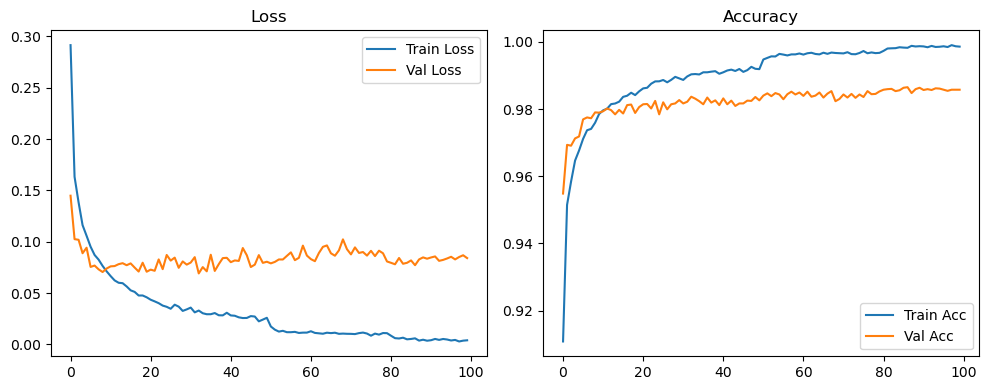

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4516, Acc: 0.8636 | Val Loss: 0.1741, Acc: 0.9491


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2832, Acc: 0.9177 | Val Loss: 0.1378, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2486, Acc: 0.9271 | Val Loss: 0.1262, Acc: 0.9634


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2244, Acc: 0.9349 | Val Loss: 0.1203, Acc: 0.9629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2128, Acc: 0.9389 | Val Loss: 0.1043, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1924, Acc: 0.9439 | Val Loss: 0.0957, Acc: 0.9720


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9459 | Val Loss: 0.0932, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1762, Acc: 0.9500 | Val Loss: 0.0931, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1698, Acc: 0.9509 | Val Loss: 0.0899, Acc: 0.9730


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1668, Acc: 0.9515 | Val Loss: 0.0850, Acc: 0.9747


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1592, Acc: 0.9538 | Val Loss: 0.0869, Acc: 0.9757


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1543, Acc: 0.9546 | Val Loss: 0.0809, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9577 | Val Loss: 0.0789, Acc: 0.9774


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9575 | Val Loss: 0.0844, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1433, Acc: 0.9584 | Val Loss: 0.0842, Acc: 0.9766


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9593 | Val Loss: 0.0793, Acc: 0.9777


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9606 | Val Loss: 0.0782, Acc: 0.9779


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1305, Acc: 0.9614 | Val Loss: 0.0774, Acc: 0.9773


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9615 | Val Loss: 0.0841, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9640 | Val Loss: 0.0765, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1226, Acc: 0.9651 | Val Loss: 0.0752, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9641 | Val Loss: 0.0774, Acc: 0.9775


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1237, Acc: 0.9643 | Val Loss: 0.0775, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1175, Acc: 0.9661 | Val Loss: 0.0763, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9665 | Val Loss: 0.0792, Acc: 0.9790


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1175, Acc: 0.9655 | Val Loss: 0.0737, Acc: 0.9789


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9667 | Val Loss: 0.0796, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9663 | Val Loss: 0.0768, Acc: 0.9788


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9689 | Val Loss: 0.0710, Acc: 0.9810


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1060, Acc: 0.9693 | Val Loss: 0.0751, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9677 | Val Loss: 0.0704, Acc: 0.9798


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1040, Acc: 0.9690 | Val Loss: 0.0749, Acc: 0.9799


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9685 | Val Loss: 0.0755, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1047, Acc: 0.9691 | Val Loss: 0.0722, Acc: 0.9800


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9697 | Val Loss: 0.0738, Acc: 0.9801


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9721 | Val Loss: 0.0731, Acc: 0.9793


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9717 | Val Loss: 0.0722, Acc: 0.9801


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0998, Acc: 0.9710 | Val Loss: 0.0689, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9712 | Val Loss: 0.0723, Acc: 0.9806


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9714 | Val Loss: 0.0677, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9717 | Val Loss: 0.0742, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9730 | Val Loss: 0.0742, Acc: 0.9812


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9721 | Val Loss: 0.0728, Acc: 0.9804


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9724 | Val Loss: 0.0738, Acc: 0.9805


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9745 | Val Loss: 0.0740, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9731 | Val Loss: 0.0743, Acc: 0.9801


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9728 | Val Loss: 0.0767, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9739 | Val Loss: 0.0731, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9729 | Val Loss: 0.0754, Acc: 0.9805


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9724 | Val Loss: 0.0725, Acc: 0.9803


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9780 | Val Loss: 0.0672, Acc: 0.9819


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9794 | Val Loss: 0.0735, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9791 | Val Loss: 0.0681, Acc: 0.9824


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9805 | Val Loss: 0.0742, Acc: 0.9819


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9811 | Val Loss: 0.0713, Acc: 0.9815


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9813 | Val Loss: 0.0693, Acc: 0.9822


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9810 | Val Loss: 0.0688, Acc: 0.9824


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9814 | Val Loss: 0.0720, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9819 | Val Loss: 0.0728, Acc: 0.9812


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9816 | Val Loss: 0.0729, Acc: 0.9818


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9819 | Val Loss: 0.0722, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9820 | Val Loss: 0.0740, Acc: 0.9828


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9827 | Val Loss: 0.0775, Acc: 0.9819


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9821 | Val Loss: 0.0723, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.0734, Acc: 0.9818


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9828 | Val Loss: 0.0683, Acc: 0.9817


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9825 | Val Loss: 0.0678, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9831 | Val Loss: 0.0721, Acc: 0.9820


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9832 | Val Loss: 0.0704, Acc: 0.9822


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9836 | Val Loss: 0.0745, Acc: 0.9828


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9836 | Val Loss: 0.0698, Acc: 0.9822


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9838 | Val Loss: 0.0785, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9840 | Val Loss: 0.0690, Acc: 0.9821


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9829 | Val Loss: 0.0693, Acc: 0.9828


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9836 | Val Loss: 0.0749, Acc: 0.9817


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9833 | Val Loss: 0.0710, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9846 | Val Loss: 0.0724, Acc: 0.9819


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9830 | Val Loss: 0.0711, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9819 | Val Loss: 0.0718, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9841 | Val Loss: 0.0698, Acc: 0.9831


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9854 | Val Loss: 0.0704, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.0689, Acc: 0.9834


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9866 | Val Loss: 0.0716, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9868 | Val Loss: 0.0701, Acc: 0.9836


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9874 | Val Loss: 0.0713, Acc: 0.9830


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9883 | Val Loss: 0.0717, Acc: 0.9832


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9883 | Val Loss: 0.0707, Acc: 0.9830


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9891 | Val Loss: 0.0707, Acc: 0.9835


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9880 | Val Loss: 0.0703, Acc: 0.9836


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9894 | Val Loss: 0.0729, Acc: 0.9831


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9886 | Val Loss: 0.0735, Acc: 0.9827


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9886 | Val Loss: 0.0753, Acc: 0.9817


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9889 | Val Loss: 0.0699, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.0734, Acc: 0.9831


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9881 | Val Loss: 0.0703, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9888 | Val Loss: 0.0719, Acc: 0.9829


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9886 | Val Loss: 0.0707, Acc: 0.9834


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9882 | Val Loss: 0.0687, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9886 | Val Loss: 0.0723, Acc: 0.9837


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9884 | Val Loss: 0.0709, Acc: 0.9836


Final Test Loss: 0.0679 Accuracy: 0.9841


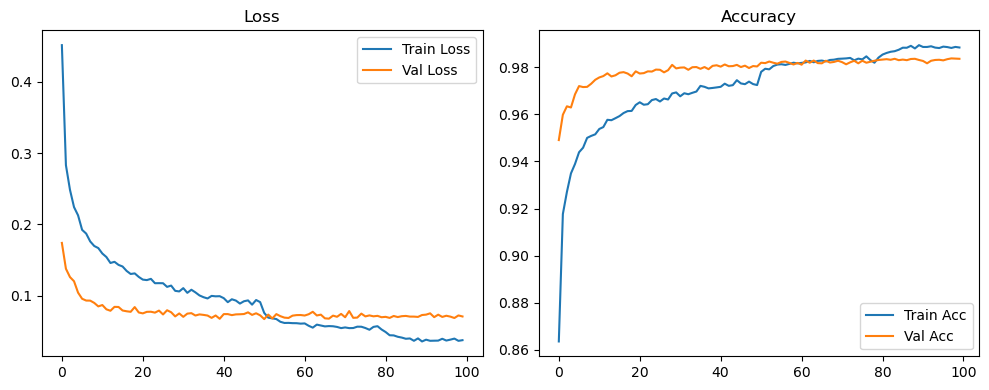

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2457, Acc: 0.9248 | Val Loss: 0.1516, Acc: 0.9534


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9631 | Val Loss: 0.1056, Acc: 0.9697


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 0.0879, Acc: 0.9737


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9758 | Val Loss: 0.0952, Acc: 0.9719


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9788 | Val Loss: 0.0861, Acc: 0.9732


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.0818, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.0881, Acc: 0.9742


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.0786, Acc: 0.9775


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9867 | Val Loss: 0.0846, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.0863, Acc: 0.9784


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.0857, Acc: 0.9773


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9891 | Val Loss: 0.0849, Acc: 0.9783


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0761, Acc: 0.9803


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0861, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0949, Acc: 0.9761


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0968, Acc: 0.9772


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0840, Acc: 0.9806


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0894, Acc: 0.9777


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0899, Acc: 0.9780


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0855, Acc: 0.9784


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0928, Acc: 0.9789


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0855, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0963, Acc: 0.9792


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9957 | Val Loss: 0.0945, Acc: 0.9789


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1038, Acc: 0.9792


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1003, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.0922, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1154, Acc: 0.9783


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0962, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1139, Acc: 0.9786


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0969, Acc: 0.9807


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.0870, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0963, Acc: 0.9814


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1074, Acc: 0.9795


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1002, Acc: 0.9806


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0897, Acc: 0.9815


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0946, Acc: 0.9814


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0932, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1096, Acc: 0.9785


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0878, Acc: 0.9820


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0933, Acc: 0.9800


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0896, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.0980, Acc: 0.9808


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1018, Acc: 0.9808


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1041, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0997, Acc: 0.9815


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0997, Acc: 0.9812


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1099, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9823


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0911, Acc: 0.9836


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0917, Acc: 0.9837


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0887, Acc: 0.9840


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0921, Acc: 0.9846


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0920, Acc: 0.9847


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0946, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0928, Acc: 0.9843


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0986, Acc: 0.9844


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0979, Acc: 0.9841


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1002, Acc: 0.9844


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1094, Acc: 0.9845


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1060, Acc: 0.9838


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1030, Acc: 0.9851


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1075, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1103, Acc: 0.9843


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1158, Acc: 0.9837


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1134, Acc: 0.9841


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1087, Acc: 0.9843


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1113, Acc: 0.9844


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1097, Acc: 0.9850


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.1109, Acc: 0.9836


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1072, Acc: 0.9842


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1098, Acc: 0.9839


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1112, Acc: 0.9840


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1091, Acc: 0.9846


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1118, Acc: 0.9852


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1094, Acc: 0.9844


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1159, Acc: 0.9849


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1167, Acc: 0.9850


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1134, Acc: 0.9843


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1148, Acc: 0.9843


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1193, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1125, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1138, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1165, Acc: 0.9849


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1158, Acc: 0.9849


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1192, Acc: 0.9839


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1193, Acc: 0.9848


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1193, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1194, Acc: 0.9850


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1221, Acc: 0.9848


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1195, Acc: 0.9853


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1232, Acc: 0.9849


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1227, Acc: 0.9850


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1251, Acc: 0.9853


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1274, Acc: 0.9842


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1266, Acc: 0.9852


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1328, Acc: 0.9847


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1288, Acc: 0.9851


Final Test Loss: 0.1219 Accuracy: 0.9844


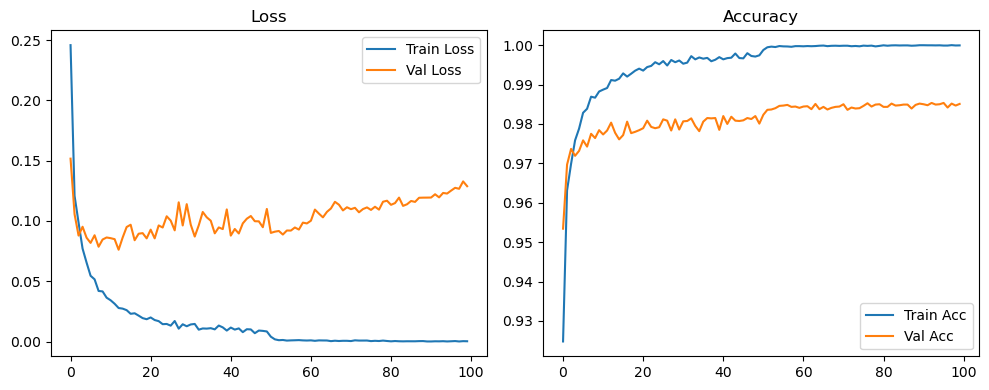

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2914, Acc: 0.9108 | Val Loss: 0.1449, Acc: 0.9548


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1633, Acc: 0.9515 | Val Loss: 0.1025, Acc: 0.9693


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9584 | Val Loss: 0.1019, Acc: 0.9691


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9646 | Val Loss: 0.0888, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9677 | Val Loss: 0.0942, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9711 | Val Loss: 0.0755, Acc: 0.9769


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9737 | Val Loss: 0.0768, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9741 | Val Loss: 0.0732, Acc: 0.9772


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9759 | Val Loss: 0.0705, Acc: 0.9790


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9785 | Val Loss: 0.0739, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9796 | Val Loss: 0.0761, Acc: 0.9793


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9801 | Val Loss: 0.0763, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9815 | Val Loss: 0.0782, Acc: 0.9797


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9816 | Val Loss: 0.0791, Acc: 0.9784


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9822 | Val Loss: 0.0772, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9836 | Val Loss: 0.0790, Acc: 0.9787


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.0749, Acc: 0.9812


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.0710, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9841 | Val Loss: 0.0796, Acc: 0.9788


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9853 | Val Loss: 0.0708, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9861 | Val Loss: 0.0729, Acc: 0.9814


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9863 | Val Loss: 0.0717, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0828, Acc: 0.9802


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0733, Acc: 0.9824


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0871, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.0817, Acc: 0.9820


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0846, Acc: 0.9799


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.0746, Acc: 0.9814


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0808, Acc: 0.9817


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.0777, Acc: 0.9827


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0798, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0850, Acc: 0.9822


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9903 | Val Loss: 0.0692, Acc: 0.9837


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0753, Acc: 0.9831


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0712, Acc: 0.9823


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.0874, Acc: 0.9814


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9909 | Val Loss: 0.0716, Acc: 0.9834


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0782, Acc: 0.9819


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9913 | Val Loss: 0.0841, Acc: 0.9826


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9905 | Val Loss: 0.0844, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0801, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9915 | Val Loss: 0.0818, Acc: 0.9814


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0813, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0939, Acc: 0.9809


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0869, Acc: 0.9817


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0754, Acc: 0.9817


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.0777, Acc: 0.9825


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0870, Acc: 0.9824


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0795, Acc: 0.9836


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0806, Acc: 0.9826


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0751, Acc: 0.9842


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0779, Acc: 0.9851


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0772, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.0780, Acc: 0.9853


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0779, Acc: 0.9854


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0789, Acc: 0.9853


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0772, Acc: 0.9855


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0785, Acc: 0.9857


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0819, Acc: 0.9860


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0759, Acc: 0.9860


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0789, Acc: 0.9852


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0790, Acc: 0.9862


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0794, Acc: 0.9856


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0862, Acc: 0.9852


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0840, Acc: 0.9857


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0827, Acc: 0.9845


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0826, Acc: 0.9861


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0824, Acc: 0.9864


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0873, Acc: 0.9855


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0860, Acc: 0.9849


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0863, Acc: 0.9860


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0862, Acc: 0.9846


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0851, Acc: 0.9852


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0853, Acc: 0.9839


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0841, Acc: 0.9865


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0884, Acc: 0.9855


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0906, Acc: 0.9857


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0908, Acc: 0.9860


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0877, Acc: 0.9852


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0831, Acc: 0.9863


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0867, Acc: 0.9856


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0845, Acc: 0.9861


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0906, Acc: 0.9862


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0845, Acc: 0.9861


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0856, Acc: 0.9858


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0870, Acc: 0.9864


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0839, Acc: 0.9866


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0883, Acc: 0.9854


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0894, Acc: 0.9853


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0885, Acc: 0.9860


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0890, Acc: 0.9861


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0882, Acc: 0.9855


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0855, Acc: 0.9856


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0865, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0872, Acc: 0.9862


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0887, Acc: 0.9858


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0869, Acc: 0.9859


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0880, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0902, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0875, Acc: 0.9861


Final Test Loss: 0.0822 Accuracy: 0.9871


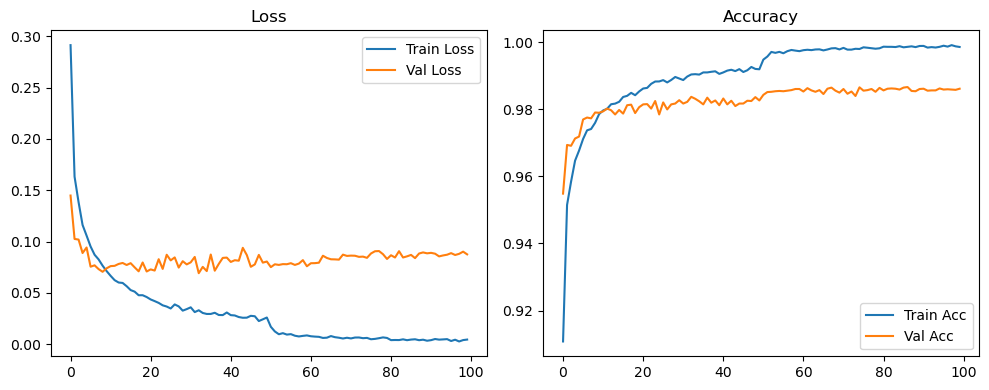

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4516, Acc: 0.8636 | Val Loss: 0.1741, Acc: 0.9491


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2832, Acc: 0.9177 | Val Loss: 0.1378, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2486, Acc: 0.9271 | Val Loss: 0.1262, Acc: 0.9634


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2244, Acc: 0.9349 | Val Loss: 0.1203, Acc: 0.9629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2128, Acc: 0.9389 | Val Loss: 0.1043, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1924, Acc: 0.9439 | Val Loss: 0.0957, Acc: 0.9720


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9459 | Val Loss: 0.0932, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1762, Acc: 0.9500 | Val Loss: 0.0931, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1698, Acc: 0.9509 | Val Loss: 0.0899, Acc: 0.9730


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1668, Acc: 0.9515 | Val Loss: 0.0850, Acc: 0.9747


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1592, Acc: 0.9538 | Val Loss: 0.0869, Acc: 0.9757


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1543, Acc: 0.9546 | Val Loss: 0.0809, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9577 | Val Loss: 0.0789, Acc: 0.9774


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9575 | Val Loss: 0.0844, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1433, Acc: 0.9584 | Val Loss: 0.0842, Acc: 0.9766


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9593 | Val Loss: 0.0793, Acc: 0.9777


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9606 | Val Loss: 0.0782, Acc: 0.9779


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1305, Acc: 0.9614 | Val Loss: 0.0774, Acc: 0.9773


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9615 | Val Loss: 0.0841, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9640 | Val Loss: 0.0765, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1226, Acc: 0.9651 | Val Loss: 0.0752, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9641 | Val Loss: 0.0774, Acc: 0.9775


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1237, Acc: 0.9643 | Val Loss: 0.0775, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1175, Acc: 0.9661 | Val Loss: 0.0763, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9665 | Val Loss: 0.0792, Acc: 0.9790


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1175, Acc: 0.9655 | Val Loss: 0.0737, Acc: 0.9789


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9667 | Val Loss: 0.0796, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9663 | Val Loss: 0.0768, Acc: 0.9788


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9689 | Val Loss: 0.0710, Acc: 0.9810


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1060, Acc: 0.9693 | Val Loss: 0.0751, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9677 | Val Loss: 0.0704, Acc: 0.9798


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1040, Acc: 0.9690 | Val Loss: 0.0749, Acc: 0.9799


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9685 | Val Loss: 0.0755, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1047, Acc: 0.9691 | Val Loss: 0.0722, Acc: 0.9800


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9697 | Val Loss: 0.0738, Acc: 0.9801


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9721 | Val Loss: 0.0731, Acc: 0.9793


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9717 | Val Loss: 0.0722, Acc: 0.9801


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0998, Acc: 0.9710 | Val Loss: 0.0689, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9712 | Val Loss: 0.0723, Acc: 0.9806


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9714 | Val Loss: 0.0677, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9717 | Val Loss: 0.0742, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9730 | Val Loss: 0.0742, Acc: 0.9812


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9721 | Val Loss: 0.0728, Acc: 0.9804


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9724 | Val Loss: 0.0738, Acc: 0.9805


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9745 | Val Loss: 0.0740, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9731 | Val Loss: 0.0743, Acc: 0.9801


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9728 | Val Loss: 0.0767, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9739 | Val Loss: 0.0731, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9729 | Val Loss: 0.0754, Acc: 0.9805


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9724 | Val Loss: 0.0725, Acc: 0.9803


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9778 | Val Loss: 0.0676, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0655, Acc: 0.9804 | Val Loss: 0.0697, Acc: 0.9816


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0639, Acc: 0.9806 | Val Loss: 0.0659, Acc: 0.9819


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9821 | Val Loss: 0.0676, Acc: 0.9825


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9827 | Val Loss: 0.0676, Acc: 0.9823


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9830 | Val Loss: 0.0657, Acc: 0.9826


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9836 | Val Loss: 0.0661, Acc: 0.9823


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9838 | Val Loss: 0.0727, Acc: 0.9825


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9835 | Val Loss: 0.0685, Acc: 0.9823


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9841 | Val Loss: 0.0683, Acc: 0.9828


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9836 | Val Loss: 0.0691, Acc: 0.9827


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9854 | Val Loss: 0.0701, Acc: 0.9829


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9852 | Val Loss: 0.0713, Acc: 0.9827


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9842 | Val Loss: 0.0692, Acc: 0.9830


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9853 | Val Loss: 0.0704, Acc: 0.9820


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9851 | Val Loss: 0.0680, Acc: 0.9819


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9854 | Val Loss: 0.0661, Acc: 0.9825


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9853 | Val Loss: 0.0696, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9859 | Val Loss: 0.0691, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9857 | Val Loss: 0.0685, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9858 | Val Loss: 0.0693, Acc: 0.9823


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9858 | Val Loss: 0.0729, Acc: 0.9817


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9864 | Val Loss: 0.0658, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9853 | Val Loss: 0.0679, Acc: 0.9826


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9855 | Val Loss: 0.0683, Acc: 0.9832


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9866 | Val Loss: 0.0686, Acc: 0.9828


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9866 | Val Loss: 0.0683, Acc: 0.9826


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9856 | Val Loss: 0.0693, Acc: 0.9833


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9852 | Val Loss: 0.0705, Acc: 0.9829


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9871 | Val Loss: 0.0696, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9861 | Val Loss: 0.0694, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9870 | Val Loss: 0.0686, Acc: 0.9839


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9874 | Val Loss: 0.0708, Acc: 0.9828


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9876 | Val Loss: 0.0707, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9881 | Val Loss: 0.0701, Acc: 0.9830


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9878 | Val Loss: 0.0695, Acc: 0.9832


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9884 | Val Loss: 0.0688, Acc: 0.9834


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9882 | Val Loss: 0.0694, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.0703, Acc: 0.9830


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9884 | Val Loss: 0.0724, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9883 | Val Loss: 0.0734, Acc: 0.9833


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9885 | Val Loss: 0.0739, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.0698, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9886 | Val Loss: 0.0721, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9888 | Val Loss: 0.0702, Acc: 0.9824


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9883 | Val Loss: 0.0708, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9886 | Val Loss: 0.0710, Acc: 0.9824


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9878 | Val Loss: 0.0688, Acc: 0.9835


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9883 | Val Loss: 0.0721, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9879 | Val Loss: 0.0704, Acc: 0.9835


Final Test Loss: 0.0661 Accuracy: 0.9840


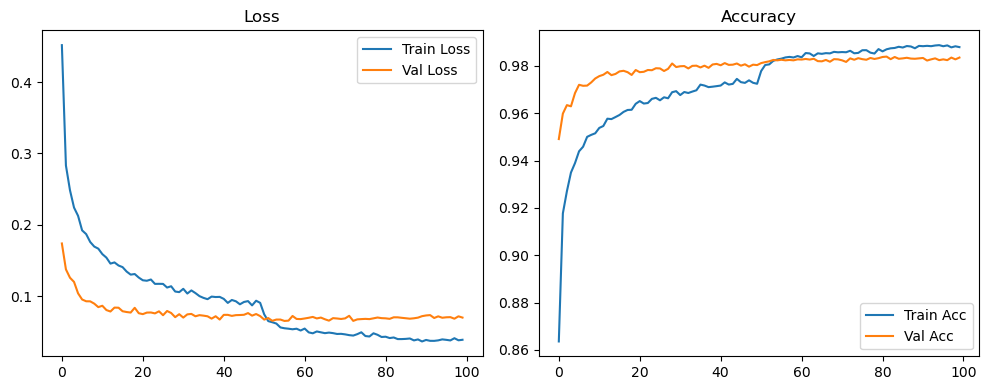

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2329, Acc: 0.9278 | Val Loss: 0.1262, Acc: 0.9634


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1115, Acc: 0.9658 | Val Loss: 0.1089, Acc: 0.9677


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0897, Acc: 0.9720 | Val Loss: 0.0842, Acc: 0.9745


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9791 | Val Loss: 0.0865, Acc: 0.9743


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9815 | Val Loss: 0.0814, Acc: 0.9758


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9846 | Val Loss: 0.0794, Acc: 0.9788


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.0768, Acc: 0.9768


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.0768, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.0803, Acc: 0.9773


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.0916, Acc: 0.9778


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0758, Acc: 0.9798


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0732, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.0822, Acc: 0.9788


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0818, Acc: 0.9793


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0823, Acc: 0.9789


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0817, Acc: 0.9804


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0778, Acc: 0.9811


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0815, Acc: 0.9815


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0805, Acc: 0.9809


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0948, Acc: 0.9784


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0790, Acc: 0.9819


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0817, Acc: 0.9822


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0924, Acc: 0.9801


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0894, Acc: 0.9799


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0957, Acc: 0.9811


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1024, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0937, Acc: 0.9810


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1103, Acc: 0.9783


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0985, Acc: 0.9797


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0970, Acc: 0.9813


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0897, Acc: 0.9799


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0885, Acc: 0.9800


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0934, Acc: 0.9817


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0943, Acc: 0.9809


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0966, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0954, Acc: 0.9809


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0949, Acc: 0.9818


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1031, Acc: 0.9808


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0994, Acc: 0.9808


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1006, Acc: 0.9799


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1065, Acc: 0.9814


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0975, Acc: 0.9822


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0938, Acc: 0.9814


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1060, Acc: 0.9798


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1088, Acc: 0.9806


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1182, Acc: 0.9783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1110, Acc: 0.9794


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1019, Acc: 0.9819


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1046, Acc: 0.9813


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1033, Acc: 0.9811


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1053, Acc: 0.9808


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.0937, Acc: 0.9823


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0899, Acc: 0.9821


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0995, Acc: 0.9820


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1104, Acc: 0.9804


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1036, Acc: 0.9815


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0998, Acc: 0.9826


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1132, Acc: 0.9814


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1000, Acc: 0.9827


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1037, Acc: 0.9817


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0962, Acc: 0.9827


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1036, Acc: 0.9819


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1084, Acc: 0.9817


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0975, Acc: 0.9822


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0992, Acc: 0.9823


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0990, Acc: 0.9835


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1110, Acc: 0.9818


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1062, Acc: 0.9822


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1112, Acc: 0.9827


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1041, Acc: 0.9830


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1361, Acc: 0.9807


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1170, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1085, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1101, Acc: 0.9825


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1045, Acc: 0.9828


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1185, Acc: 0.9817


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1211, Acc: 0.9825


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1178, Acc: 0.9816


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1150, Acc: 0.9827


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1115, Acc: 0.9828


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1020, Acc: 0.9832


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1042, Acc: 0.9830


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1347, Acc: 0.9793


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1099, Acc: 0.9811


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1192, Acc: 0.9832


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1167, Acc: 0.9816


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1052, Acc: 0.9835


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1087, Acc: 0.9837


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1201, Acc: 0.9832


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1179, Acc: 0.9818


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1227, Acc: 0.9812


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1207, Acc: 0.9823


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1100, Acc: 0.9825


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1164, Acc: 0.9828


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1276, Acc: 0.9820


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1239, Acc: 0.9821


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1191, Acc: 0.9843


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0996, Acc: 0.9848


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1142, Acc: 0.9830


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1255, Acc: 0.9824


Final Test Loss: 0.1258 Accuracy: 0.9827


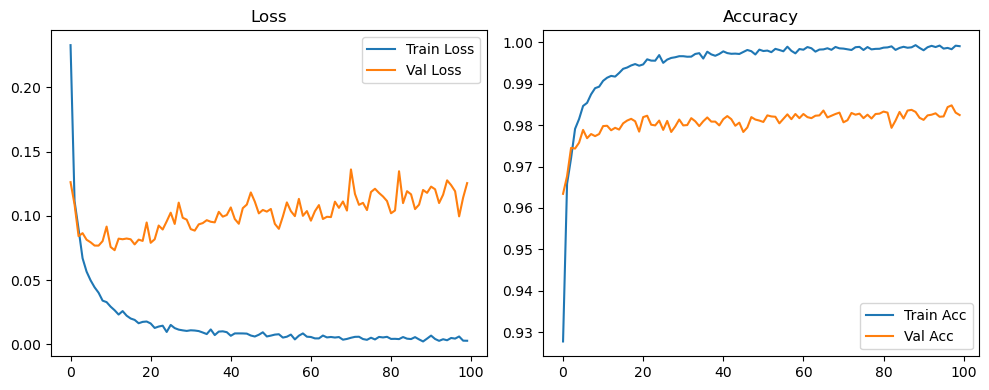

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2778, Acc: 0.9154 | Val Loss: 0.1462, Acc: 0.9583


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1517, Acc: 0.9549 | Val Loss: 0.1158, Acc: 0.9658


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1251, Acc: 0.9615 | Val Loss: 0.0892, Acc: 0.9734


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1037, Acc: 0.9676 | Val Loss: 0.0836, Acc: 0.9745


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9713 | Val Loss: 0.0846, Acc: 0.9742


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9740 | Val Loss: 0.0737, Acc: 0.9785


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0787, Acc: 0.9748 | Val Loss: 0.0773, Acc: 0.9768


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9779 | Val Loss: 0.0734, Acc: 0.9769


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9798 | Val Loss: 0.0790, Acc: 0.9777


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9806 | Val Loss: 0.0723, Acc: 0.9788


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9811 | Val Loss: 0.0763, Acc: 0.9782


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.0723, Acc: 0.9795


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.0687, Acc: 0.9806


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.0713, Acc: 0.9797


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9847 | Val Loss: 0.0753, Acc: 0.9793


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.0692, Acc: 0.9812


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9861 | Val Loss: 0.0716, Acc: 0.9812


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0727, Acc: 0.9800


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9868 | Val Loss: 0.0727, Acc: 0.9798


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.0708, Acc: 0.9804


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9875 | Val Loss: 0.0682, Acc: 0.9812


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.0677, Acc: 0.9818


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9889 | Val Loss: 0.0727, Acc: 0.9812


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.0676, Acc: 0.9815


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.0828, Acc: 0.9790


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0697, Acc: 0.9823


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0705, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.0743, Acc: 0.9827


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0749, Acc: 0.9810


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0789, Acc: 0.9804


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.0719, Acc: 0.9820


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0785, Acc: 0.9819


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.0766, Acc: 0.9814


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.0865, Acc: 0.9803


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0730, Acc: 0.9821


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0753, Acc: 0.9809


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0725, Acc: 0.9824


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.0751, Acc: 0.9826


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0731, Acc: 0.9821


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.0681, Acc: 0.9838


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0757, Acc: 0.9820


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0675, Acc: 0.9831


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0728, Acc: 0.9831


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.0755, Acc: 0.9822


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0820, Acc: 0.9814


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0792, Acc: 0.9806


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.0701, Acc: 0.9838


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0718, Acc: 0.9832


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0752, Acc: 0.9833


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0657, Acc: 0.9844


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0707, Acc: 0.9836


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0735, Acc: 0.9837


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0698, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0760, Acc: 0.9833


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0770, Acc: 0.9831


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0755, Acc: 0.9828


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.0757, Acc: 0.9834


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.0808, Acc: 0.9822


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0827, Acc: 0.9825


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0813, Acc: 0.9812


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0825, Acc: 0.9828


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.0837, Acc: 0.9824


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0845, Acc: 0.9824


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0808, Acc: 0.9833


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0813, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0734, Acc: 0.9828


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0909, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0758, Acc: 0.9834


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0764, Acc: 0.9831


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0764, Acc: 0.9834


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0887, Acc: 0.9819


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0792, Acc: 0.9817


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0826, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0831, Acc: 0.9841


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0721, Acc: 0.9849


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.0714, Acc: 0.9844


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0912, Acc: 0.9826


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0791, Acc: 0.9832


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0800, Acc: 0.9833


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0827, Acc: 0.9832


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0812, Acc: 0.9834


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0847, Acc: 0.9838


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0842, Acc: 0.9842


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9950 | Val Loss: 0.0832, Acc: 0.9828


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0859, Acc: 0.9818


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0801, Acc: 0.9829


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0817, Acc: 0.9842


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0859, Acc: 0.9821


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0827, Acc: 0.9839


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9960 | Val Loss: 0.0824, Acc: 0.9834


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0814, Acc: 0.9832


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0826, Acc: 0.9832


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0747, Acc: 0.9842


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0841, Acc: 0.9844


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.0778, Acc: 0.9839


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0910, Acc: 0.9831


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0896, Acc: 0.9837


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0863, Acc: 0.9845


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0859, Acc: 0.9828


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0846, Acc: 0.9835


Final Test Loss: 0.0807 Accuracy: 0.9844


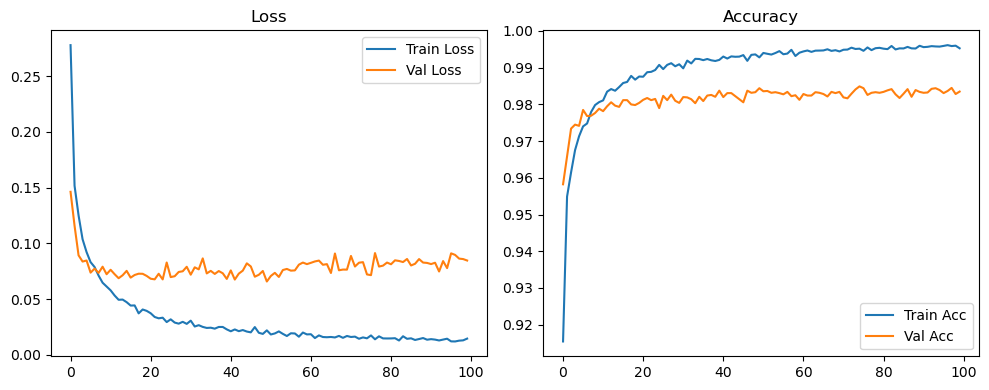

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4303, Acc: 0.8673 | Val Loss: 0.1652, Acc: 0.9493


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2634, Acc: 0.9221 | Val Loss: 0.1278, Acc: 0.9607


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2283, Acc: 0.9318 | Val Loss: 0.1124, Acc: 0.9655


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2008, Acc: 0.9400 | Val Loss: 0.1102, Acc: 0.9659


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1899, Acc: 0.9441 | Val Loss: 0.1037, Acc: 0.9686


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1768, Acc: 0.9476 | Val Loss: 0.0900, Acc: 0.9724


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1652, Acc: 0.9506 | Val Loss: 0.0871, Acc: 0.9732


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1565, Acc: 0.9543 | Val Loss: 0.0883, Acc: 0.9745


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1526, Acc: 0.9539 | Val Loss: 0.0835, Acc: 0.9755


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1486, Acc: 0.9556 | Val Loss: 0.0798, Acc: 0.9758


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1412, Acc: 0.9573 | Val Loss: 0.0771, Acc: 0.9764


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1331, Acc: 0.9599 | Val Loss: 0.0749, Acc: 0.9770


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1269, Acc: 0.9621 | Val Loss: 0.0779, Acc: 0.9769


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1272, Acc: 0.9623 | Val Loss: 0.0739, Acc: 0.9781


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1253, Acc: 0.9631 | Val Loss: 0.0746, Acc: 0.9762


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1227, Acc: 0.9634 | Val Loss: 0.0731, Acc: 0.9784


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1186, Acc: 0.9636 | Val Loss: 0.0736, Acc: 0.9792


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1108, Acc: 0.9667 | Val Loss: 0.0788, Acc: 0.9776


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1139, Acc: 0.9660 | Val Loss: 0.0773, Acc: 0.9775


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9658 | Val Loss: 0.0743, Acc: 0.9782


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1074, Acc: 0.9674 | Val Loss: 0.0696, Acc: 0.9794


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1063, Acc: 0.9687 | Val Loss: 0.0725, Acc: 0.9789


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1054, Acc: 0.9681 | Val Loss: 0.0719, Acc: 0.9790


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1013, Acc: 0.9696 | Val Loss: 0.0672, Acc: 0.9802


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1012, Acc: 0.9697 | Val Loss: 0.0750, Acc: 0.9790


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0964, Acc: 0.9710 | Val Loss: 0.0694, Acc: 0.9800


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9710 | Val Loss: 0.0754, Acc: 0.9781


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0936, Acc: 0.9721 | Val Loss: 0.0700, Acc: 0.9799


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0914, Acc: 0.9722 | Val Loss: 0.0699, Acc: 0.9809


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9715 | Val Loss: 0.0717, Acc: 0.9795


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9716 | Val Loss: 0.0670, Acc: 0.9792


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9728 | Val Loss: 0.0682, Acc: 0.9797


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0878, Acc: 0.9736 | Val Loss: 0.0695, Acc: 0.9797


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0897, Acc: 0.9726 | Val Loss: 0.0654, Acc: 0.9808


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9733 | Val Loss: 0.0712, Acc: 0.9797


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9732 | Val Loss: 0.0683, Acc: 0.9802


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9753 | Val Loss: 0.0687, Acc: 0.9809


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9745 | Val Loss: 0.0654, Acc: 0.9807


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9741 | Val Loss: 0.0717, Acc: 0.9803


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9742 | Val Loss: 0.0684, Acc: 0.9802


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0829, Acc: 0.9752 | Val Loss: 0.0678, Acc: 0.9812


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9763 | Val Loss: 0.0671, Acc: 0.9803


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9757 | Val Loss: 0.0683, Acc: 0.9804


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9765 | Val Loss: 0.0693, Acc: 0.9808


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0681, Acc: 0.9805


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0792, Acc: 0.9756 | Val Loss: 0.0749, Acc: 0.9792


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0657, Acc: 0.9817


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0747, Acc: 0.9772 | Val Loss: 0.0690, Acc: 0.9812


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9772 | Val Loss: 0.0705, Acc: 0.9812


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9776 | Val Loss: 0.0660, Acc: 0.9828


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0756, Acc: 0.9772 | Val Loss: 0.0678, Acc: 0.9831


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0758, Acc: 0.9769 | Val Loss: 0.0688, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9773 | Val Loss: 0.0719, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9772 | Val Loss: 0.0689, Acc: 0.9811


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9784 | Val Loss: 0.0736, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0699, Acc: 0.9784 | Val Loss: 0.0677, Acc: 0.9803


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9774 | Val Loss: 0.0689, Acc: 0.9812


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9779 | Val Loss: 0.0689, Acc: 0.9814


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9783 | Val Loss: 0.0721, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0699, Acc: 0.9792 | Val Loss: 0.0697, Acc: 0.9817


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9797 | Val Loss: 0.0755, Acc: 0.9818


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0659, Acc: 0.9799 | Val Loss: 0.0725, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9800 | Val Loss: 0.0778, Acc: 0.9806


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9788 | Val Loss: 0.0714, Acc: 0.9812


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9800 | Val Loss: 0.0710, Acc: 0.9806


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9804 | Val Loss: 0.0705, Acc: 0.9810


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9799 | Val Loss: 0.0711, Acc: 0.9815


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9789 | Val Loss: 0.0717, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9812 | Val Loss: 0.0735, Acc: 0.9821


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9805 | Val Loss: 0.0713, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0681, Acc: 0.9797 | Val Loss: 0.0693, Acc: 0.9816


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9802 | Val Loss: 0.0746, Acc: 0.9811


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9809 | Val Loss: 0.0693, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9804 | Val Loss: 0.0728, Acc: 0.9811


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9809 | Val Loss: 0.0672, Acc: 0.9822


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9802 | Val Loss: 0.0663, Acc: 0.9821


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9808 | Val Loss: 0.0760, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9804 | Val Loss: 0.0696, Acc: 0.9819


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9808 | Val Loss: 0.0716, Acc: 0.9815


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9811 | Val Loss: 0.0748, Acc: 0.9810


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9805 | Val Loss: 0.0740, Acc: 0.9812


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9809 | Val Loss: 0.0686, Acc: 0.9810


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9825 | Val Loss: 0.0743, Acc: 0.9814


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9809 | Val Loss: 0.0738, Acc: 0.9816


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9816 | Val Loss: 0.0731, Acc: 0.9815


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9821 | Val Loss: 0.0730, Acc: 0.9823


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9827 | Val Loss: 0.0730, Acc: 0.9824


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9816 | Val Loss: 0.0726, Acc: 0.9812


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9820 | Val Loss: 0.0710, Acc: 0.9815


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9830 | Val Loss: 0.0778, Acc: 0.9814


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9804 | Val Loss: 0.0734, Acc: 0.9811


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9814 | Val Loss: 0.0730, Acc: 0.9810


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9826 | Val Loss: 0.0746, Acc: 0.9811


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9828 | Val Loss: 0.0771, Acc: 0.9819


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9829 | Val Loss: 0.0749, Acc: 0.9818


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9817 | Val Loss: 0.0723, Acc: 0.9812


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.0774, Acc: 0.9818


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9829 | Val Loss: 0.0740, Acc: 0.9825


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9812 | Val Loss: 0.0695, Acc: 0.9818


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9831 | Val Loss: 0.0707, Acc: 0.9823


Final Test Loss: 0.0647 Accuracy: 0.9835


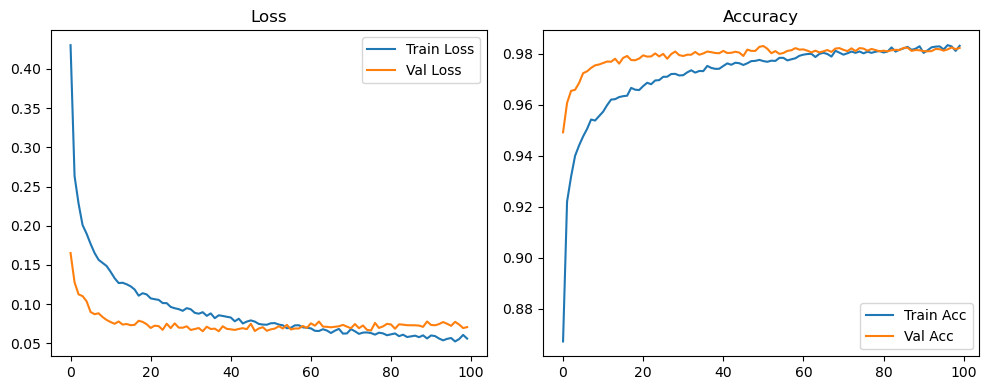

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2329, Acc: 0.9278 | Val Loss: 0.1262, Acc: 0.9634


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1115, Acc: 0.9658 | Val Loss: 0.1089, Acc: 0.9677


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0897, Acc: 0.9720 | Val Loss: 0.0842, Acc: 0.9745


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9791 | Val Loss: 0.0865, Acc: 0.9743


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9815 | Val Loss: 0.0814, Acc: 0.9758


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9846 | Val Loss: 0.0794, Acc: 0.9788


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.0768, Acc: 0.9768


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.0768, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.0803, Acc: 0.9773


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.0916, Acc: 0.9778


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0758, Acc: 0.9798


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0732, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.0822, Acc: 0.9788


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0818, Acc: 0.9793


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0823, Acc: 0.9789


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0817, Acc: 0.9804


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0778, Acc: 0.9811


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0815, Acc: 0.9815


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0805, Acc: 0.9809


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0948, Acc: 0.9784


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0790, Acc: 0.9819


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0817, Acc: 0.9822


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0924, Acc: 0.9801


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0894, Acc: 0.9799


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0957, Acc: 0.9811


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1024, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0937, Acc: 0.9810


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1103, Acc: 0.9783


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0985, Acc: 0.9797


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0970, Acc: 0.9813


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0897, Acc: 0.9799


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0885, Acc: 0.9800


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0934, Acc: 0.9817


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0943, Acc: 0.9809


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0966, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0954, Acc: 0.9809


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0949, Acc: 0.9818


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1031, Acc: 0.9808


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0994, Acc: 0.9808


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1006, Acc: 0.9799


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1065, Acc: 0.9814


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0975, Acc: 0.9822


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0938, Acc: 0.9814


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1060, Acc: 0.9798


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1088, Acc: 0.9806


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1182, Acc: 0.9783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1110, Acc: 0.9794


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1019, Acc: 0.9819


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1046, Acc: 0.9813


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1033, Acc: 0.9811


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0880, Acc: 0.9838


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0914, Acc: 0.9844


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0947, Acc: 0.9841


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0962, Acc: 0.9846


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0981, Acc: 0.9833


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0944, Acc: 0.9842


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0944, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1024, Acc: 0.9838


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1062, Acc: 0.9830


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1085, Acc: 0.9839


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1125, Acc: 0.9821


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1148, Acc: 0.9830


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1120, Acc: 0.9838


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1107, Acc: 0.9842


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1207, Acc: 0.9818


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1082, Acc: 0.9832


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1086, Acc: 0.9831


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1152, Acc: 0.9831


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1069, Acc: 0.9839


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1093, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1112, Acc: 0.9835


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1213, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1027, Acc: 0.9842


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1097, Acc: 0.9829


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1140, Acc: 0.9839


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1189, Acc: 0.9831


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1154, Acc: 0.9833


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1103, Acc: 0.9834


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1102, Acc: 0.9845


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1149, Acc: 0.9838


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1122, Acc: 0.9847


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1100, Acc: 0.9850


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1122, Acc: 0.9851


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1077, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1090, Acc: 0.9860


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1096, Acc: 0.9859


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1084, Acc: 0.9858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1114, Acc: 0.9854


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1123, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1219, Acc: 0.9845


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1199, Acc: 0.9848


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1215, Acc: 0.9849


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1191, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1271, Acc: 0.9833


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1231, Acc: 0.9845


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1278, Acc: 0.9841


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9847


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1272, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1233, Acc: 0.9843


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1167, Acc: 0.9852


Final Test Loss: 0.1147 Accuracy: 0.9861


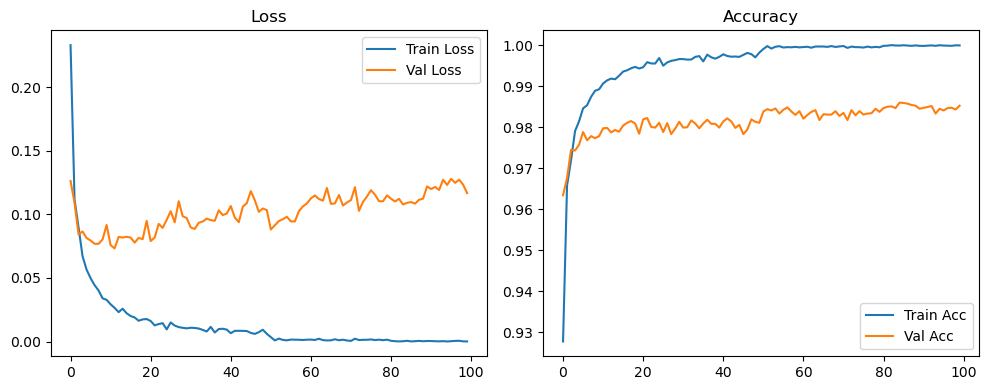

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2778, Acc: 0.9154 | Val Loss: 0.1462, Acc: 0.9583


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1517, Acc: 0.9549 | Val Loss: 0.1158, Acc: 0.9658


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1251, Acc: 0.9615 | Val Loss: 0.0892, Acc: 0.9734


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1037, Acc: 0.9676 | Val Loss: 0.0836, Acc: 0.9745


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9713 | Val Loss: 0.0846, Acc: 0.9742


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9740 | Val Loss: 0.0737, Acc: 0.9785


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0787, Acc: 0.9748 | Val Loss: 0.0773, Acc: 0.9768


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9779 | Val Loss: 0.0734, Acc: 0.9769


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9798 | Val Loss: 0.0790, Acc: 0.9777


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9806 | Val Loss: 0.0723, Acc: 0.9788


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9811 | Val Loss: 0.0763, Acc: 0.9782


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.0723, Acc: 0.9795


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.0687, Acc: 0.9806


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.0713, Acc: 0.9797


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9847 | Val Loss: 0.0753, Acc: 0.9793


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.0692, Acc: 0.9812


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9861 | Val Loss: 0.0716, Acc: 0.9812


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0727, Acc: 0.9800


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9868 | Val Loss: 0.0727, Acc: 0.9798


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.0708, Acc: 0.9804


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9875 | Val Loss: 0.0682, Acc: 0.9812


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.0677, Acc: 0.9818


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9889 | Val Loss: 0.0727, Acc: 0.9812


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.0676, Acc: 0.9815


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.0828, Acc: 0.9790


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0697, Acc: 0.9823


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0705, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.0743, Acc: 0.9827


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0749, Acc: 0.9810


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0789, Acc: 0.9804


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.0719, Acc: 0.9820


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0785, Acc: 0.9819


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.0766, Acc: 0.9814


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.0865, Acc: 0.9803


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0730, Acc: 0.9821


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0753, Acc: 0.9809


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0725, Acc: 0.9824


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.0751, Acc: 0.9826


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0731, Acc: 0.9821


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.0681, Acc: 0.9838


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0757, Acc: 0.9820


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0675, Acc: 0.9831


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0728, Acc: 0.9831


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.0755, Acc: 0.9822


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0820, Acc: 0.9814


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0792, Acc: 0.9806


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.0701, Acc: 0.9838


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0718, Acc: 0.9832


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0752, Acc: 0.9833


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0657, Acc: 0.9844


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0638, Acc: 0.9849


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0663, Acc: 0.9846


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0656, Acc: 0.9863


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0726, Acc: 0.9845


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0710, Acc: 0.9848


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0721, Acc: 0.9846


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0691, Acc: 0.9857


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0769, Acc: 0.9848


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0818, Acc: 0.9842


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0791, Acc: 0.9836


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0759, Acc: 0.9839


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0776, Acc: 0.9844


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0815, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0780, Acc: 0.9847


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0779, Acc: 0.9852


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0719, Acc: 0.9856


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0768, Acc: 0.9858


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0778, Acc: 0.9849


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0766, Acc: 0.9865


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0835, Acc: 0.9847


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0810, Acc: 0.9847


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0777, Acc: 0.9853


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0771, Acc: 0.9854


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0838, Acc: 0.9848


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0773, Acc: 0.9845


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0795, Acc: 0.9853


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0808, Acc: 0.9850


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0825, Acc: 0.9847


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0801, Acc: 0.9847


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0803, Acc: 0.9847


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0799, Acc: 0.9850


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0740, Acc: 0.9861


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0786, Acc: 0.9857


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0733, Acc: 0.9856


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0766, Acc: 0.9850


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0760, Acc: 0.9856


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0775, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0823, Acc: 0.9852


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0803, Acc: 0.9854


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0824, Acc: 0.9854


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0808, Acc: 0.9859


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0808, Acc: 0.9855


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0786, Acc: 0.9854


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0796, Acc: 0.9859


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0789, Acc: 0.9863


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0790, Acc: 0.9851


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0804, Acc: 0.9851


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0820, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0797, Acc: 0.9860


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0828, Acc: 0.9862


Final Test Loss: 0.0821 Accuracy: 0.9870


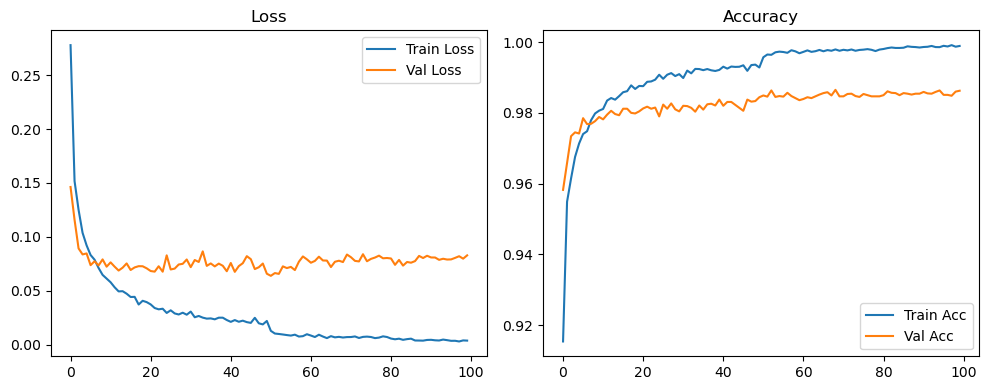

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4303, Acc: 0.8673 | Val Loss: 0.1652, Acc: 0.9493


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2634, Acc: 0.9221 | Val Loss: 0.1278, Acc: 0.9607


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2283, Acc: 0.9318 | Val Loss: 0.1124, Acc: 0.9655


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2008, Acc: 0.9400 | Val Loss: 0.1102, Acc: 0.9659


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1899, Acc: 0.9441 | Val Loss: 0.1037, Acc: 0.9686


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1768, Acc: 0.9476 | Val Loss: 0.0900, Acc: 0.9724


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1652, Acc: 0.9506 | Val Loss: 0.0871, Acc: 0.9732


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1565, Acc: 0.9543 | Val Loss: 0.0883, Acc: 0.9745


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1526, Acc: 0.9539 | Val Loss: 0.0835, Acc: 0.9755


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1486, Acc: 0.9556 | Val Loss: 0.0798, Acc: 0.9758


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1412, Acc: 0.9573 | Val Loss: 0.0771, Acc: 0.9764


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1331, Acc: 0.9599 | Val Loss: 0.0749, Acc: 0.9770


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1269, Acc: 0.9621 | Val Loss: 0.0779, Acc: 0.9769


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1272, Acc: 0.9623 | Val Loss: 0.0739, Acc: 0.9781


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1253, Acc: 0.9631 | Val Loss: 0.0746, Acc: 0.9762


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1227, Acc: 0.9634 | Val Loss: 0.0731, Acc: 0.9784


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1186, Acc: 0.9636 | Val Loss: 0.0736, Acc: 0.9792


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1108, Acc: 0.9667 | Val Loss: 0.0788, Acc: 0.9776


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1139, Acc: 0.9660 | Val Loss: 0.0773, Acc: 0.9775


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9658 | Val Loss: 0.0743, Acc: 0.9782


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1074, Acc: 0.9674 | Val Loss: 0.0696, Acc: 0.9794


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1063, Acc: 0.9687 | Val Loss: 0.0725, Acc: 0.9789


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1054, Acc: 0.9681 | Val Loss: 0.0719, Acc: 0.9790


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1013, Acc: 0.9696 | Val Loss: 0.0672, Acc: 0.9802


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1012, Acc: 0.9697 | Val Loss: 0.0750, Acc: 0.9790


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0964, Acc: 0.9710 | Val Loss: 0.0694, Acc: 0.9800


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9710 | Val Loss: 0.0754, Acc: 0.9781


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0936, Acc: 0.9721 | Val Loss: 0.0700, Acc: 0.9799


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0914, Acc: 0.9722 | Val Loss: 0.0699, Acc: 0.9809


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9715 | Val Loss: 0.0717, Acc: 0.9795


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9716 | Val Loss: 0.0670, Acc: 0.9792


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9728 | Val Loss: 0.0682, Acc: 0.9797


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0878, Acc: 0.9736 | Val Loss: 0.0695, Acc: 0.9797


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0897, Acc: 0.9726 | Val Loss: 0.0654, Acc: 0.9808


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9733 | Val Loss: 0.0712, Acc: 0.9797


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9732 | Val Loss: 0.0683, Acc: 0.9802


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9753 | Val Loss: 0.0687, Acc: 0.9809


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9745 | Val Loss: 0.0654, Acc: 0.9807


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9741 | Val Loss: 0.0717, Acc: 0.9803


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9742 | Val Loss: 0.0684, Acc: 0.9802


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0829, Acc: 0.9752 | Val Loss: 0.0678, Acc: 0.9812


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9763 | Val Loss: 0.0671, Acc: 0.9803


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9757 | Val Loss: 0.0683, Acc: 0.9804


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9765 | Val Loss: 0.0693, Acc: 0.9808


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0681, Acc: 0.9805


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0792, Acc: 0.9756 | Val Loss: 0.0749, Acc: 0.9792


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0657, Acc: 0.9817


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0747, Acc: 0.9772 | Val Loss: 0.0690, Acc: 0.9812


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9772 | Val Loss: 0.0705, Acc: 0.9812


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9776 | Val Loss: 0.0660, Acc: 0.9828


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9801 | Val Loss: 0.0656, Acc: 0.9832


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0599, Acc: 0.9817 | Val Loss: 0.0676, Acc: 0.9828


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9828 | Val Loss: 0.0668, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9829 | Val Loss: 0.0672, Acc: 0.9827


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9838 | Val Loss: 0.0681, Acc: 0.9820


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9841 | Val Loss: 0.0654, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9832 | Val Loss: 0.0663, Acc: 0.9820


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9845 | Val Loss: 0.0652, Acc: 0.9820


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 0.0687, Acc: 0.9819


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 0.0659, Acc: 0.9819


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9848 | Val Loss: 0.0718, Acc: 0.9818


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9855 | Val Loss: 0.0716, Acc: 0.9817


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9858 | Val Loss: 0.0703, Acc: 0.9824


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9854 | Val Loss: 0.0705, Acc: 0.9812


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9852 | Val Loss: 0.0735, Acc: 0.9808


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9863 | Val Loss: 0.0699, Acc: 0.9824


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9856 | Val Loss: 0.0711, Acc: 0.9823


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9852 | Val Loss: 0.0712, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9869 | Val Loss: 0.0713, Acc: 0.9818


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9867 | Val Loss: 0.0711, Acc: 0.9822


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9855 | Val Loss: 0.0698, Acc: 0.9824


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9858 | Val Loss: 0.0700, Acc: 0.9819


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9871 | Val Loss: 0.0660, Acc: 0.9828


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.0681, Acc: 0.9818


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9870 | Val Loss: 0.0695, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9861 | Val Loss: 0.0683, Acc: 0.9824


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9870 | Val Loss: 0.0709, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9864 | Val Loss: 0.0682, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.0672, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9866 | Val Loss: 0.0713, Acc: 0.9812


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0690, Acc: 0.9830


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.0651, Acc: 0.9826


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9884 | Val Loss: 0.0693, Acc: 0.9828


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.0676, Acc: 0.9827


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0684, Acc: 0.9826


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.0702, Acc: 0.9831


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9889 | Val Loss: 0.0698, Acc: 0.9830


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.0716, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.0691, Acc: 0.9826


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.0714, Acc: 0.9831


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.0706, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0697, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9897 | Val Loss: 0.0701, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9895 | Val Loss: 0.0716, Acc: 0.9824


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0730, Acc: 0.9823


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0708, Acc: 0.9825


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0755, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.0703, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0723, Acc: 0.9825


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 0.0703, Acc: 0.9828


Final Test Loss: 0.0657 Accuracy: 0.9844


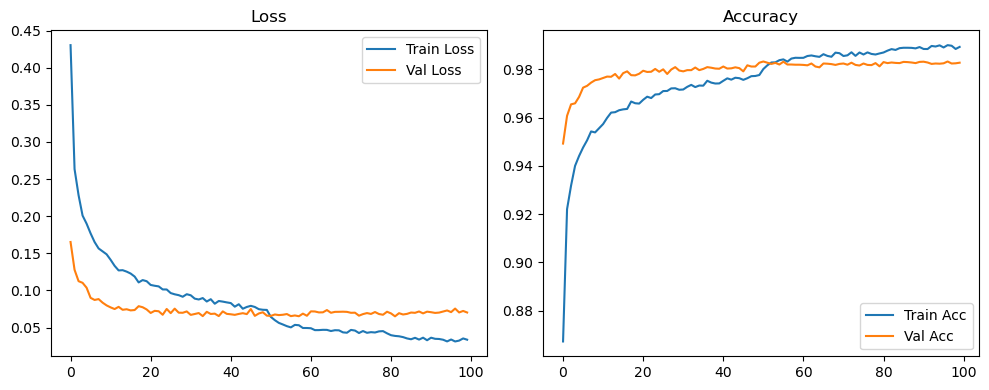

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2138, Acc: 0.9333 | Val Loss: 0.1195, Acc: 0.9638


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1014, Acc: 0.9687 | Val Loss: 0.1007, Acc: 0.9701


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0783, Acc: 0.9747 | Val Loss: 0.0834, Acc: 0.9731


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9805 | Val Loss: 0.0811, Acc: 0.9758


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9834 | Val Loss: 0.0859, Acc: 0.9742


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9862 | Val Loss: 0.0811, Acc: 0.9766


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 0.0856, Acc: 0.9761


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 0.0855, Acc: 0.9771


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9902 | Val Loss: 0.0811, Acc: 0.9780


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0845, Acc: 0.9776


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0937, Acc: 0.9771


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0837, Acc: 0.9791


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0754, Acc: 0.9798


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0854, Acc: 0.9796


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0749, Acc: 0.9807


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0843, Acc: 0.9786


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0756, Acc: 0.9808


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0956, Acc: 0.9782


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0862, Acc: 0.9805


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0726, Acc: 0.9830


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0741, Acc: 0.9817


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0871, Acc: 0.9818


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0847, Acc: 0.9808


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0822, Acc: 0.9823


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0911, Acc: 0.9818


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0930, Acc: 0.9811


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0891, Acc: 0.9818


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0936, Acc: 0.9806


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0841, Acc: 0.9821


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0871, Acc: 0.9832


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0990, Acc: 0.9802


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0944, Acc: 0.9809


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0902, Acc: 0.9800


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0830, Acc: 0.9821


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0970, Acc: 0.9808


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0994, Acc: 0.9819


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0946, Acc: 0.9806


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0925, Acc: 0.9820


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0892, Acc: 0.9832


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0942, Acc: 0.9802


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0922, Acc: 0.9800


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0855, Acc: 0.9835


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0843, Acc: 0.9832


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0883, Acc: 0.9831


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0974, Acc: 0.9806


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0963, Acc: 0.9812


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1020, Acc: 0.9814


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0917, Acc: 0.9823


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0932, Acc: 0.9827


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0814, Acc: 0.9832


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0854, Acc: 0.9826


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0914, Acc: 0.9829


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0963, Acc: 0.9820


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0893, Acc: 0.9840


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0970, Acc: 0.9833


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1038, Acc: 0.9813


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0940, Acc: 0.9833


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0962, Acc: 0.9834


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0931, Acc: 0.9828


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0930, Acc: 0.9838


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.0995, Acc: 0.9839


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9835


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1061, Acc: 0.9837


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1007, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0971, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0987, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1069, Acc: 0.9821


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0978, Acc: 0.9830


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0987, Acc: 0.9832


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0959, Acc: 0.9837


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1001, Acc: 0.9831


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1105, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1053, Acc: 0.9823


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0966, Acc: 0.9820


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0914, Acc: 0.9837


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0948, Acc: 0.9834


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1008, Acc: 0.9827


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.0948, Acc: 0.9822


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1019, Acc: 0.9818


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0975, Acc: 0.9822


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0927, Acc: 0.9842


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0947, Acc: 0.9832


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0971, Acc: 0.9825


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1067, Acc: 0.9827


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1017, Acc: 0.9832


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1005, Acc: 0.9837


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1111, Acc: 0.9818


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1043, Acc: 0.9826


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1096, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1163, Acc: 0.9807


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1098, Acc: 0.9823


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1113, Acc: 0.9818


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1036, Acc: 0.9835


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1096, Acc: 0.9838


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1115, Acc: 0.9804


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1145, Acc: 0.9813


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1077, Acc: 0.9831


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1297, Acc: 0.9795


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1155, Acc: 0.9812


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1009, Acc: 0.9832


Final Test Loss: 0.1137 Accuracy: 0.9831


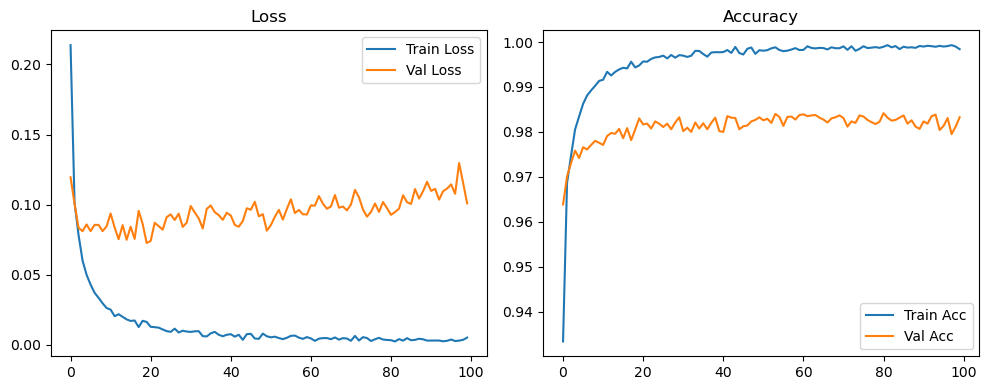

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2691, Acc: 0.9174 | Val Loss: 0.1281, Acc: 0.9603


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1414, Acc: 0.9568 | Val Loss: 0.1019, Acc: 0.9689


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1189, Acc: 0.9633 | Val Loss: 0.0850, Acc: 0.9729


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0970, Acc: 0.9694 | Val Loss: 0.0821, Acc: 0.9749


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0860, Acc: 0.9730 | Val Loss: 0.0812, Acc: 0.9745


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0788, Acc: 0.9756 | Val Loss: 0.0681, Acc: 0.9793


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9780 | Val Loss: 0.0712, Acc: 0.9785


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9793 | Val Loss: 0.0698, Acc: 0.9793


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0586, Acc: 0.9815 | Val Loss: 0.0703, Acc: 0.9792


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0564, Acc: 0.9821 | Val Loss: 0.0669, Acc: 0.9791


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.0715, Acc: 0.9786


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9851 | Val Loss: 0.0681, Acc: 0.9806


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9850 | Val Loss: 0.0708, Acc: 0.9800


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9842 | Val Loss: 0.0641, Acc: 0.9815


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9861 | Val Loss: 0.0628, Acc: 0.9818


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9878 | Val Loss: 0.0630, Acc: 0.9821


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9884 | Val Loss: 0.0677, Acc: 0.9806


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9887 | Val Loss: 0.0700, Acc: 0.9811


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9873 | Val Loss: 0.0686, Acc: 0.9815


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.0682, Acc: 0.9820


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.0677, Acc: 0.9817


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.0698, Acc: 0.9814


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.0671, Acc: 0.9828


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.0642, Acc: 0.9832


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9907 | Val Loss: 0.0665, Acc: 0.9822


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.0650, Acc: 0.9835


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0645, Acc: 0.9828


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0703, Acc: 0.9820


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.0695, Acc: 0.9832


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0667, Acc: 0.9838


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0605, Acc: 0.9845


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.0676, Acc: 0.9837


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0673, Acc: 0.9839


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9928 | Val Loss: 0.0708, Acc: 0.9826


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0773, Acc: 0.9818


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.0685, Acc: 0.9836


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0688, Acc: 0.9847


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0697, Acc: 0.9839


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0655, Acc: 0.9848


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0719, Acc: 0.9835


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0645, Acc: 0.9842


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0678, Acc: 0.9836


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0712, Acc: 0.9834


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0651, Acc: 0.9842


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.0714, Acc: 0.9837


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0725, Acc: 0.9832


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0699, Acc: 0.9835


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.0704, Acc: 0.9844


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0675, Acc: 0.9840


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0681, Acc: 0.9829


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9943 | Val Loss: 0.0691, Acc: 0.9848


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0710, Acc: 0.9837


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0715, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.0774, Acc: 0.9823


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0722, Acc: 0.9845


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0769, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0746, Acc: 0.9825


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0766, Acc: 0.9826


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0747, Acc: 0.9839


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0687, Acc: 0.9851


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0781, Acc: 0.9837


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0694, Acc: 0.9844


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0716, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0707, Acc: 0.9853


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0790, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0721, Acc: 0.9842


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0702, Acc: 0.9842


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0685, Acc: 0.9851


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0728, Acc: 0.9835


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0622, Acc: 0.9847


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0697, Acc: 0.9843


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0705, Acc: 0.9842


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0670, Acc: 0.9852


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0744, Acc: 0.9839


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0747, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0716, Acc: 0.9845


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0759, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0769, Acc: 0.9829


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0748, Acc: 0.9848


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0765, Acc: 0.9844


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0754, Acc: 0.9840


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0775, Acc: 0.9840


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0837, Acc: 0.9821


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0718, Acc: 0.9844


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0741, Acc: 0.9835


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0770, Acc: 0.9840


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0781, Acc: 0.9837


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0772, Acc: 0.9838


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0838, Acc: 0.9834


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0757, Acc: 0.9837


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0722, Acc: 0.9848


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0702, Acc: 0.9845


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0688, Acc: 0.9855


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0753, Acc: 0.9849


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0794, Acc: 0.9842


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0780, Acc: 0.9841


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0720, Acc: 0.9842


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0727, Acc: 0.9842


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0788, Acc: 0.9848


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0811, Acc: 0.9838


Final Test Loss: 0.0731 Accuracy: 0.9846


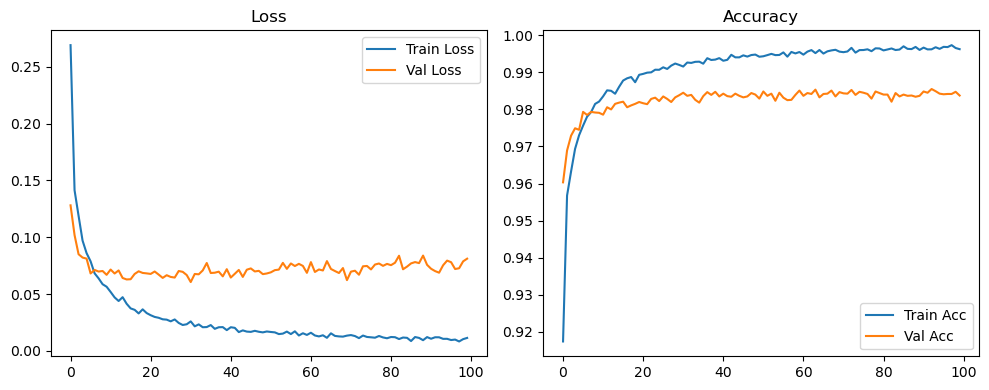

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4393, Acc: 0.8655 | Val Loss: 0.1693, Acc: 0.9492


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2598, Acc: 0.9213 | Val Loss: 0.1299, Acc: 0.9602


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2248, Acc: 0.9329 | Val Loss: 0.1124, Acc: 0.9657


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1927, Acc: 0.9412 | Val Loss: 0.1089, Acc: 0.9668


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1794, Acc: 0.9451 | Val Loss: 0.0996, Acc: 0.9681


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1637, Acc: 0.9506 | Val Loss: 0.0898, Acc: 0.9739


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1537, Acc: 0.9544 | Val Loss: 0.0895, Acc: 0.9725


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1430, Acc: 0.9575 | Val Loss: 0.0846, Acc: 0.9760


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1386, Acc: 0.9577 | Val Loss: 0.0868, Acc: 0.9745


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1368, Acc: 0.9598 | Val Loss: 0.0800, Acc: 0.9754


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1271, Acc: 0.9618 | Val Loss: 0.0842, Acc: 0.9755


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1246, Acc: 0.9626 | Val Loss: 0.0766, Acc: 0.9772


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1202, Acc: 0.9637 | Val Loss: 0.0755, Acc: 0.9775


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1151, Acc: 0.9651 | Val Loss: 0.0759, Acc: 0.9773


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1146, Acc: 0.9653 | Val Loss: 0.0757, Acc: 0.9778


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1090, Acc: 0.9669 | Val Loss: 0.0733, Acc: 0.9779


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1030, Acc: 0.9685 | Val Loss: 0.0742, Acc: 0.9780


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0996, Acc: 0.9690 | Val Loss: 0.0743, Acc: 0.9782


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1034, Acc: 0.9685 | Val Loss: 0.0754, Acc: 0.9784


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0996, Acc: 0.9696 | Val Loss: 0.0724, Acc: 0.9778


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0938, Acc: 0.9711 | Val Loss: 0.0740, Acc: 0.9795


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0968, Acc: 0.9694 | Val Loss: 0.0713, Acc: 0.9795


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0946, Acc: 0.9711 | Val Loss: 0.0687, Acc: 0.9809


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0899, Acc: 0.9720 | Val Loss: 0.0682, Acc: 0.9791


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0876, Acc: 0.9735 | Val Loss: 0.0728, Acc: 0.9794


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0866, Acc: 0.9741 | Val Loss: 0.0692, Acc: 0.9802


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0870, Acc: 0.9730 | Val Loss: 0.0700, Acc: 0.9803


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0835, Acc: 0.9744 | Val Loss: 0.0708, Acc: 0.9799


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0812, Acc: 0.9743 | Val Loss: 0.0694, Acc: 0.9803


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0797, Acc: 0.9747 | Val Loss: 0.0710, Acc: 0.9800


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0825, Acc: 0.9740 | Val Loss: 0.0670, Acc: 0.9815


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0809, Acc: 0.9757 | Val Loss: 0.0663, Acc: 0.9817


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0825, Acc: 0.9750 | Val Loss: 0.0684, Acc: 0.9800


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0730, Acc: 0.9768 | Val Loss: 0.0691, Acc: 0.9806


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0678, Acc: 0.9801


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0772, Acc: 0.9764 | Val Loss: 0.0664, Acc: 0.9816


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0707, Acc: 0.9775 | Val Loss: 0.0700, Acc: 0.9811


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.0674, Acc: 0.9805


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0734, Acc: 0.9774 | Val Loss: 0.0678, Acc: 0.9816


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0705, Acc: 0.9785 | Val Loss: 0.0670, Acc: 0.9811


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0729, Acc: 0.9770 | Val Loss: 0.0671, Acc: 0.9813


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0662, Acc: 0.9789 | Val Loss: 0.0650, Acc: 0.9831


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9796 | Val Loss: 0.0679, Acc: 0.9808


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9777 | Val Loss: 0.0649, Acc: 0.9814


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0727, Acc: 0.9774 | Val Loss: 0.0641, Acc: 0.9817


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9788 | Val Loss: 0.0682, Acc: 0.9816


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0669, Acc: 0.9786 | Val Loss: 0.0689, Acc: 0.9812


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0642, Acc: 0.9803 | Val Loss: 0.0706, Acc: 0.9804


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9796 | Val Loss: 0.0670, Acc: 0.9812


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9798 | Val Loss: 0.0652, Acc: 0.9827


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0605, Acc: 0.9813 | Val Loss: 0.0690, Acc: 0.9810


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0634, Acc: 0.9802 | Val Loss: 0.0690, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9805 | Val Loss: 0.0662, Acc: 0.9812


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0656, Acc: 0.9797 | Val Loss: 0.0681, Acc: 0.9808


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9801 | Val Loss: 0.0704, Acc: 0.9813


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9807 | Val Loss: 0.0653, Acc: 0.9818


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9809 | Val Loss: 0.0686, Acc: 0.9818


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0693, Acc: 0.9809


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9809 | Val Loss: 0.0688, Acc: 0.9816


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9815 | Val Loss: 0.0687, Acc: 0.9811


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9814 | Val Loss: 0.0691, Acc: 0.9813


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9820 | Val Loss: 0.0680, Acc: 0.9816


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9824 | Val Loss: 0.0698, Acc: 0.9813


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9816 | Val Loss: 0.0668, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9808 | Val Loss: 0.0699, Acc: 0.9811


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9827 | Val Loss: 0.0678, Acc: 0.9814


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9827 | Val Loss: 0.0669, Acc: 0.9816


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9823 | Val Loss: 0.0668, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9822 | Val Loss: 0.0662, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9826 | Val Loss: 0.0683, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9833 | Val Loss: 0.0727, Acc: 0.9816


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9826 | Val Loss: 0.0697, Acc: 0.9819


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9831 | Val Loss: 0.0680, Acc: 0.9820


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0533, Acc: 0.9830 | Val Loss: 0.0669, Acc: 0.9829


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9825 | Val Loss: 0.0669, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9833 | Val Loss: 0.0689, Acc: 0.9824


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9828 | Val Loss: 0.0687, Acc: 0.9822


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9826 | Val Loss: 0.0675, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9838 | Val Loss: 0.0680, Acc: 0.9825


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9852 | Val Loss: 0.0651, Acc: 0.9822


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9830 | Val Loss: 0.0693, Acc: 0.9816


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.0689, Acc: 0.9827


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.0696, Acc: 0.9817


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.0669, Acc: 0.9823


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.0685, Acc: 0.9818


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9844 | Val Loss: 0.0686, Acc: 0.9818


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0695, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9835 | Val Loss: 0.0702, Acc: 0.9819


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9844 | Val Loss: 0.0711, Acc: 0.9817


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9851 | Val Loss: 0.0705, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9852 | Val Loss: 0.0711, Acc: 0.9818


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9847 | Val Loss: 0.0770, Acc: 0.9816


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9847 | Val Loss: 0.0666, Acc: 0.9821


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9853 | Val Loss: 0.0717, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9844 | Val Loss: 0.0706, Acc: 0.9816


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9845 | Val Loss: 0.0690, Acc: 0.9819


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.0709, Acc: 0.9815


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9850 | Val Loss: 0.0714, Acc: 0.9825


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9851 | Val Loss: 0.0677, Acc: 0.9822


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 0.0692, Acc: 0.9828


Final Test Loss: 0.0664 Accuracy: 0.9836


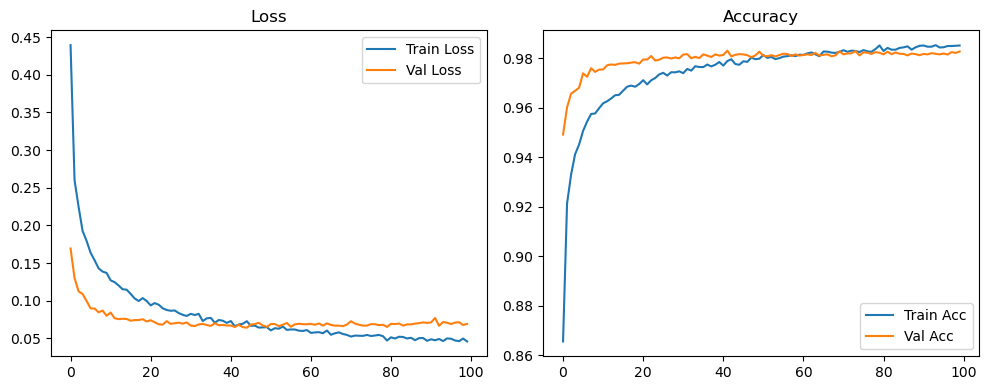

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2108, Acc: 0.9371 | Val Loss: 0.1199, Acc: 0.9641


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0932, Acc: 0.9716 | Val Loss: 0.0899, Acc: 0.9725


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9776 | Val Loss: 0.0758, Acc: 0.9766


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9828 | Val Loss: 0.0787, Acc: 0.9755


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.0799, Acc: 0.9769


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.0738, Acc: 0.9792


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9888 | Val Loss: 0.0792, Acc: 0.9778


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.0718, Acc: 0.9794


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0731, Acc: 0.9812


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.0748, Acc: 0.9791


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0821, Acc: 0.9785


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9936 | Val Loss: 0.0687, Acc: 0.9822


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.0814, Acc: 0.9788


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9929 | Val Loss: 0.0900, Acc: 0.9766


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.0809, Acc: 0.9799


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0757, Acc: 0.9809


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0764, Acc: 0.9818


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0749, Acc: 0.9817


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0768, Acc: 0.9827


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0810, Acc: 0.9820


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9958 | Val Loss: 0.0741, Acc: 0.9830


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0840, Acc: 0.9806


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0858, Acc: 0.9814


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0803, Acc: 0.9822


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0797, Acc: 0.9809


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0821, Acc: 0.9824


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0873, Acc: 0.9819


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0823, Acc: 0.9812


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0795, Acc: 0.9827


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0830, Acc: 0.9820


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0828, Acc: 0.9820


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0837, Acc: 0.9812


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0929, Acc: 0.9814


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0752, Acc: 0.9838


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0875, Acc: 0.9837


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0821, Acc: 0.9830


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0830, Acc: 0.9838


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0910, Acc: 0.9818


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0875, Acc: 0.9816


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0822, Acc: 0.9816


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0844, Acc: 0.9813


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0823, Acc: 0.9838


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0838, Acc: 0.9838


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0861, Acc: 0.9828


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0822, Acc: 0.9846


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0864, Acc: 0.9823


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0796, Acc: 0.9847


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0916, Acc: 0.9827


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0903, Acc: 0.9825


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0940, Acc: 0.9824


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0853, Acc: 0.9833


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0884, Acc: 0.9822


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0835, Acc: 0.9844


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0842, Acc: 0.9847


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0863, Acc: 0.9842


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0868, Acc: 0.9838


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0910, Acc: 0.9834


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0898, Acc: 0.9832


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0929, Acc: 0.9825


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0907, Acc: 0.9834


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0823, Acc: 0.9847


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0849, Acc: 0.9845


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0944, Acc: 0.9826


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0854, Acc: 0.9851


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0925, Acc: 0.9827


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0884, Acc: 0.9832


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0962, Acc: 0.9832


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0955, Acc: 0.9838


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0980, Acc: 0.9822


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0988, Acc: 0.9829


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1015, Acc: 0.9828


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0919, Acc: 0.9831


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0967, Acc: 0.9827


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0939, Acc: 0.9825


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0936, Acc: 0.9836


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0918, Acc: 0.9838


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0992, Acc: 0.9833


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0978, Acc: 0.9841


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0960, Acc: 0.9829


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0967, Acc: 0.9837


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9991 | Val Loss: 0.0963, Acc: 0.9845


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1000, Acc: 0.9842


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0915, Acc: 0.9840


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0834, Acc: 0.9848


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0964, Acc: 0.9845


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0930, Acc: 0.9840


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1023, Acc: 0.9828


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0967, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1068, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1028, Acc: 0.9839


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1143, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1028, Acc: 0.9841


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1042, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1066, Acc: 0.9824


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1047, Acc: 0.9827


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1020, Acc: 0.9830


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1110, Acc: 0.9824


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0988, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1035, Acc: 0.9835


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1092, Acc: 0.9830


Final Test Loss: 0.1030 Accuracy: 0.9840


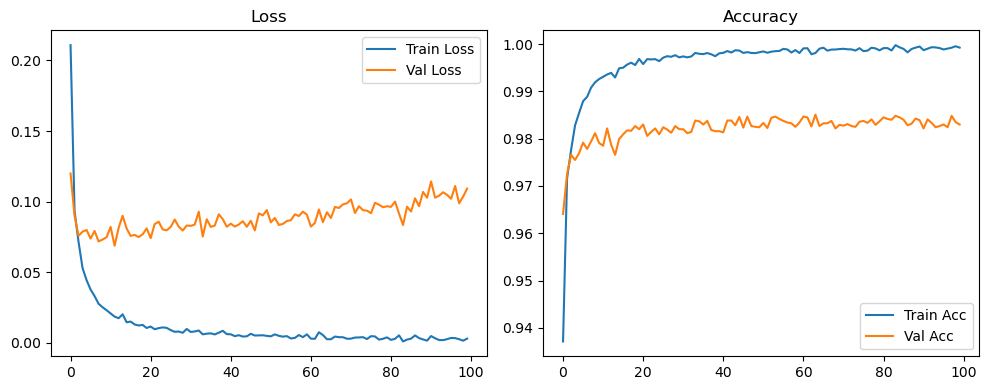

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2786, Acc: 0.9172 | Val Loss: 0.1163, Acc: 0.9647


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1363, Acc: 0.9581 | Val Loss: 0.0954, Acc: 0.9713


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1132, Acc: 0.9646 | Val Loss: 0.0826, Acc: 0.9749


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0930, Acc: 0.9701 | Val Loss: 0.0786, Acc: 0.9756


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0820, Acc: 0.9743 | Val Loss: 0.0705, Acc: 0.9781


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0770, Acc: 0.9754 | Val Loss: 0.0680, Acc: 0.9793


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9791 | Val Loss: 0.0729, Acc: 0.9779


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0604, Acc: 0.9807 | Val Loss: 0.0727, Acc: 0.9790


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9813 | Val Loss: 0.0671, Acc: 0.9802


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0689, Acc: 0.9787


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9852 | Val Loss: 0.0729, Acc: 0.9801


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9848 | Val Loss: 0.0682, Acc: 0.9807


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9864 | Val Loss: 0.0665, Acc: 0.9814


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 0.0677, Acc: 0.9808


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9873 | Val Loss: 0.0676, Acc: 0.9812


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9877 | Val Loss: 0.0654, Acc: 0.9812


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9882 | Val Loss: 0.0646, Acc: 0.9824


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0689, Acc: 0.9803


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.0702, Acc: 0.9812


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9893 | Val Loss: 0.0644, Acc: 0.9817


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.0648, Acc: 0.9825


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.0627, Acc: 0.9835


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.0677, Acc: 0.9823


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0662, Acc: 0.9831


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0693, Acc: 0.9836


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0730, Acc: 0.9821


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9911 | Val Loss: 0.0683, Acc: 0.9826


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0665, Acc: 0.9835


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.0732, Acc: 0.9834


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0704, Acc: 0.9829


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0695, Acc: 0.9828


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0689, Acc: 0.9832


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0656, Acc: 0.9830


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0705, Acc: 0.9835


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0734, Acc: 0.9832


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9931 | Val Loss: 0.0698, Acc: 0.9835


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0711, Acc: 0.9832


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9936 | Val Loss: 0.0684, Acc: 0.9835


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.0715, Acc: 0.9828


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0717, Acc: 0.9827


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0700, Acc: 0.9842


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0671, Acc: 0.9842


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.0678, Acc: 0.9844


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0679, Acc: 0.9836


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0741, Acc: 0.9831


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0741, Acc: 0.9828


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0719, Acc: 0.9841


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0671, Acc: 0.9858


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0722, Acc: 0.9850


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0698, Acc: 0.9840


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.0758, Acc: 0.9836


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0764, Acc: 0.9832


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0759, Acc: 0.9833


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0758, Acc: 0.9845


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0755, Acc: 0.9842


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0726, Acc: 0.9832


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0771, Acc: 0.9842


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0751, Acc: 0.9838


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0780, Acc: 0.9840


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0709, Acc: 0.9839


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0735, Acc: 0.9835


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0719, Acc: 0.9850


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0803, Acc: 0.9836


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0760, Acc: 0.9847


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0865, Acc: 0.9830


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0809, Acc: 0.9840


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0794, Acc: 0.9844


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0879, Acc: 0.9818


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0794, Acc: 0.9835


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0753, Acc: 0.9838


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0785, Acc: 0.9838


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0824, Acc: 0.9834


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0761, Acc: 0.9836


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0781, Acc: 0.9843


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0712, Acc: 0.9848


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0686, Acc: 0.9845


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0789, Acc: 0.9827


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0781, Acc: 0.9835


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0762, Acc: 0.9830


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0776, Acc: 0.9839


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0814, Acc: 0.9825


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0820, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0827, Acc: 0.9835


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0777, Acc: 0.9835


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0767, Acc: 0.9841


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0775, Acc: 0.9838


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0795, Acc: 0.9840


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0856, Acc: 0.9835


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0831, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0804, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0797, Acc: 0.9842


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0835, Acc: 0.9843


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0795, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0799, Acc: 0.9843


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0790, Acc: 0.9838


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0810, Acc: 0.9833


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0808, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0819, Acc: 0.9837


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0849, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0834, Acc: 0.9843


Final Test Loss: 0.0825 Accuracy: 0.9854


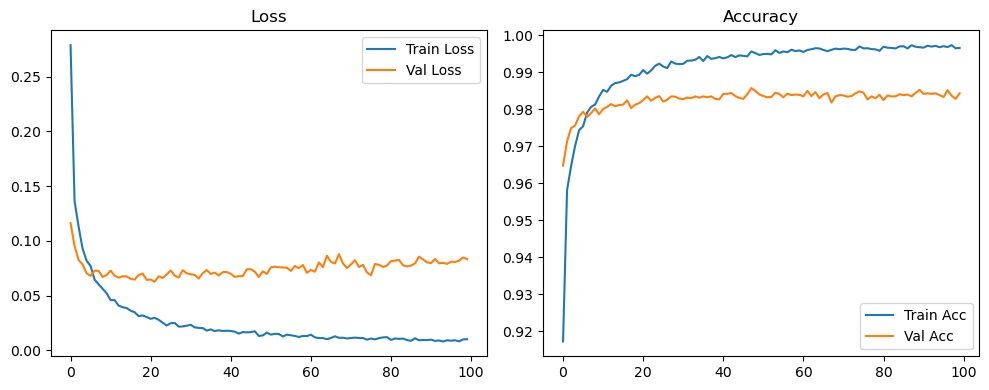

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4830, Acc: 0.8536 | Val Loss: 0.1728, Acc: 0.9477


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2671, Acc: 0.9197 | Val Loss: 0.1348, Acc: 0.9580


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2285, Acc: 0.9319 | Val Loss: 0.1165, Acc: 0.9643


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1973, Acc: 0.9417 | Val Loss: 0.1087, Acc: 0.9659


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1837, Acc: 0.9457 | Val Loss: 0.0992, Acc: 0.9699


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1672, Acc: 0.9501 | Val Loss: 0.0917, Acc: 0.9709


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1537, Acc: 0.9529 | Val Loss: 0.0869, Acc: 0.9735


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1439, Acc: 0.9565 | Val Loss: 0.0837, Acc: 0.9754


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1385, Acc: 0.9577 | Val Loss: 0.0833, Acc: 0.9747


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1376, Acc: 0.9579 | Val Loss: 0.0790, Acc: 0.9769


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1262, Acc: 0.9623 | Val Loss: 0.0785, Acc: 0.9762


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1227, Acc: 0.9625 | Val Loss: 0.0766, Acc: 0.9776


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1186, Acc: 0.9646 | Val Loss: 0.0738, Acc: 0.9783


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1162, Acc: 0.9638 | Val Loss: 0.0751, Acc: 0.9778


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1107, Acc: 0.9657 | Val Loss: 0.0713, Acc: 0.9775


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1087, Acc: 0.9666 | Val Loss: 0.0696, Acc: 0.9798


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1065, Acc: 0.9677 | Val Loss: 0.0709, Acc: 0.9772


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0963, Acc: 0.9706 | Val Loss: 0.0734, Acc: 0.9789


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1037, Acc: 0.9676 | Val Loss: 0.0722, Acc: 0.9780


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0953, Acc: 0.9707 | Val Loss: 0.0721, Acc: 0.9790


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0958, Acc: 0.9708 | Val Loss: 0.0699, Acc: 0.9802


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0913, Acc: 0.9710 | Val Loss: 0.0668, Acc: 0.9802


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0908, Acc: 0.9719 | Val Loss: 0.0705, Acc: 0.9790


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9726 | Val Loss: 0.0667, Acc: 0.9807


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0854, Acc: 0.9735 | Val Loss: 0.0699, Acc: 0.9800


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0860, Acc: 0.9735 | Val Loss: 0.0657, Acc: 0.9800


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0833, Acc: 0.9739 | Val Loss: 0.0686, Acc: 0.9814


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0808, Acc: 0.9738 | Val Loss: 0.0695, Acc: 0.9805


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0824, Acc: 0.9739 | Val Loss: 0.0678, Acc: 0.9805


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0782, Acc: 0.9763 | Val Loss: 0.0679, Acc: 0.9809


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0789, Acc: 0.9756 | Val Loss: 0.0636, Acc: 0.9818


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0755, Acc: 0.9765 | Val Loss: 0.0660, Acc: 0.9812


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0733, Acc: 0.9775 | Val Loss: 0.0625, Acc: 0.9822


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9765 | Val Loss: 0.0672, Acc: 0.9806


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0719, Acc: 0.9780 | Val Loss: 0.0660, Acc: 0.9804


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0748, Acc: 0.9769 | Val Loss: 0.0649, Acc: 0.9805


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9784 | Val Loss: 0.0637, Acc: 0.9813


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0701, Acc: 0.9779 | Val Loss: 0.0667, Acc: 0.9812


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0666, Acc: 0.9786 | Val Loss: 0.0654, Acc: 0.9817


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0698, Acc: 0.9781 | Val Loss: 0.0656, Acc: 0.9812


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0677, Acc: 0.9790 | Val Loss: 0.0658, Acc: 0.9812


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.0636, Acc: 0.9814


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9790 | Val Loss: 0.0623, Acc: 0.9820


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0643, Acc: 0.9793 | Val Loss: 0.0625, Acc: 0.9823


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0642, Acc: 0.9798 | Val Loss: 0.0632, Acc: 0.9815


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.0666, Acc: 0.9815


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9808 | Val Loss: 0.0619, Acc: 0.9836


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0592, Acc: 0.9816 | Val Loss: 0.0644, Acc: 0.9818


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9801 | Val Loss: 0.0673, Acc: 0.9818


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0609, Acc: 0.9804 | Val Loss: 0.0680, Acc: 0.9823


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9813 | Val Loss: 0.0676, Acc: 0.9819


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0599, Acc: 0.9807 | Val Loss: 0.0638, Acc: 0.9828


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9816 | Val Loss: 0.0612, Acc: 0.9823


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0617, Acc: 0.9801 | Val Loss: 0.0659, Acc: 0.9822


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0578, Acc: 0.9821 | Val Loss: 0.0667, Acc: 0.9820


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9812 | Val Loss: 0.0614, Acc: 0.9827


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9821 | Val Loss: 0.0637, Acc: 0.9822


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9832 | Val Loss: 0.0670, Acc: 0.9809


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9821 | Val Loss: 0.0663, Acc: 0.9815


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.0661, Acc: 0.9818


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9827 | Val Loss: 0.0631, Acc: 0.9838


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0527, Acc: 0.9827 | Val Loss: 0.0664, Acc: 0.9826


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9815 | Val Loss: 0.0683, Acc: 0.9818


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0664, Acc: 0.9832


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9827 | Val Loss: 0.0667, Acc: 0.9822


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0523, Acc: 0.9841 | Val Loss: 0.0672, Acc: 0.9816


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9835 | Val Loss: 0.0690, Acc: 0.9820


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9828 | Val Loss: 0.0664, Acc: 0.9833


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9842 | Val Loss: 0.0659, Acc: 0.9829


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.0649, Acc: 0.9823


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9834 | Val Loss: 0.0685, Acc: 0.9818


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9832 | Val Loss: 0.0700, Acc: 0.9824


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9829 | Val Loss: 0.0637, Acc: 0.9829


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9841 | Val Loss: 0.0676, Acc: 0.9830


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9827 | Val Loss: 0.0677, Acc: 0.9830


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9829 | Val Loss: 0.0687, Acc: 0.9821


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9841 | Val Loss: 0.0710, Acc: 0.9818


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9843 | Val Loss: 0.0701, Acc: 0.9807


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9845 | Val Loss: 0.0635, Acc: 0.9829


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9853 | Val Loss: 0.0660, Acc: 0.9833


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9850 | Val Loss: 0.0673, Acc: 0.9829


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9855 | Val Loss: 0.0663, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9841 | Val Loss: 0.0700, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9838 | Val Loss: 0.0679, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 0.0695, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9854 | Val Loss: 0.0633, Acc: 0.9830


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9849 | Val Loss: 0.0634, Acc: 0.9835


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9851 | Val Loss: 0.0654, Acc: 0.9820


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 0.0681, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9857 | Val Loss: 0.0667, Acc: 0.9833


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9856 | Val Loss: 0.0670, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.0664, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 0.0632, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 0.0668, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9860 | Val Loss: 0.0651, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9856 | Val Loss: 0.0672, Acc: 0.9835


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9852 | Val Loss: 0.0648, Acc: 0.9836


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9860 | Val Loss: 0.0656, Acc: 0.9836


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9863 | Val Loss: 0.0696, Acc: 0.9825


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9856 | Val Loss: 0.0656, Acc: 0.9832


Final Test Loss: 0.0600 Accuracy: 0.9853


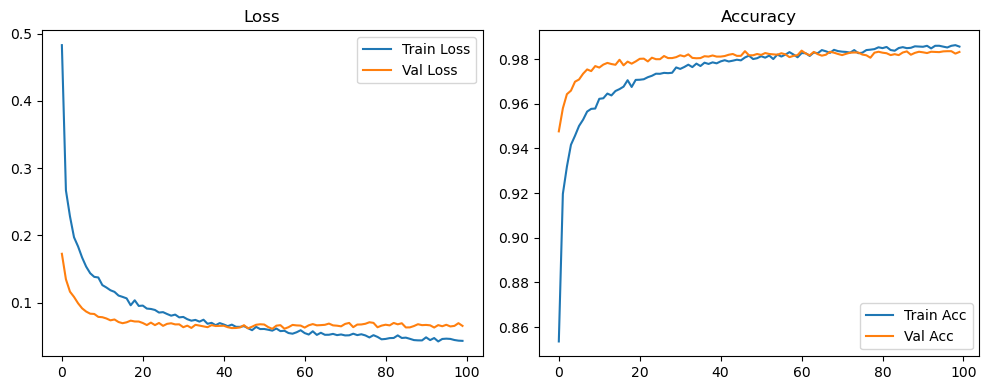

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2204, Acc: 0.9333 | Val Loss: 0.1415, Acc: 0.9583


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1062, Acc: 0.9669 | Val Loss: 0.1106, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9756 | Val Loss: 0.0999, Acc: 0.9695


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9813 | Val Loss: 0.0870, Acc: 0.9738


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9838 | Val Loss: 0.0936, Acc: 0.9731


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.0838, Acc: 0.9772


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.0819, Acc: 0.9772


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.0916, Acc: 0.9751


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0896, Acc: 0.9769


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0882, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0911, Acc: 0.9759


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0878, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.0981, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0952, Acc: 0.9764


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0977, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0942, Acc: 0.9786


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1007, Acc: 0.9796


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0998, Acc: 0.9771


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0972, Acc: 0.9789


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0991, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0936, Acc: 0.9792


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1141, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1003, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1049, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.0983, Acc: 0.9804


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0983, Acc: 0.9807


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0972, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0891, Acc: 0.9812


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0990, Acc: 0.9782


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0926, Acc: 0.9805


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0935, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0915, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.0966, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0962, Acc: 0.9792


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0999, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1060, Acc: 0.9805


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0858, Acc: 0.9825


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0974, Acc: 0.9808


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0933, Acc: 0.9814


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0942, Acc: 0.9828


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0994, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9811


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0942, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1014, Acc: 0.9797


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0952, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1025, Acc: 0.9794


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1031, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1068, Acc: 0.9829


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9799


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1032, Acc: 0.9828


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1166, Acc: 0.9813


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1077, Acc: 0.9814


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1011, Acc: 0.9842


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1051, Acc: 0.9802


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1217, Acc: 0.9798


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1112, Acc: 0.9810


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1013, Acc: 0.9819


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1011, Acc: 0.9828


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0932, Acc: 0.9822


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0960, Acc: 0.9822


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1058, Acc: 0.9812


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0894, Acc: 0.9839


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1032, Acc: 0.9830


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1046, Acc: 0.9808


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1143, Acc: 0.9785


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1096, Acc: 0.9821


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.0949, Acc: 0.9823


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0914, Acc: 0.9834


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1031, Acc: 0.9826


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1116, Acc: 0.9816


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1033, Acc: 0.9827


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1021, Acc: 0.9830


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0970, Acc: 0.9841


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1099, Acc: 0.9818


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0927, Acc: 0.9838


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1090, Acc: 0.9819


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1025, Acc: 0.9833


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1148, Acc: 0.9816


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1118, Acc: 0.9823


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1016, Acc: 0.9822


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1124, Acc: 0.9821


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1003, Acc: 0.9841


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1167, Acc: 0.9813


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1112, Acc: 0.9802


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1057, Acc: 0.9826


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1109, Acc: 0.9822


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1076, Acc: 0.9815


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1149, Acc: 0.9812


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1070, Acc: 0.9822


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1176, Acc: 0.9812


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1066, Acc: 0.9822


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1095, Acc: 0.9842


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1021, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1243, Acc: 0.9818


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.1109, Acc: 0.9810


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1100, Acc: 0.9831


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1098, Acc: 0.9838


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1137, Acc: 0.9815


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1094, Acc: 0.9828


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1145, Acc: 0.9830


Final Test Loss: 0.1176 Accuracy: 0.9825


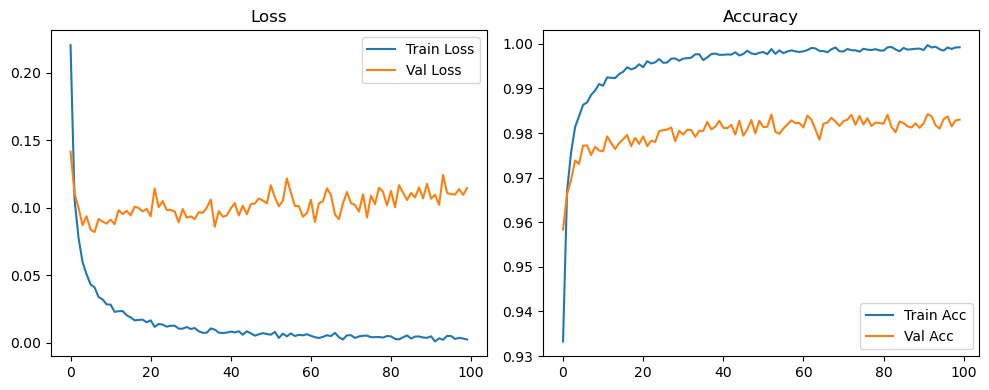

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2670, Acc: 0.9190 | Val Loss: 0.1380, Acc: 0.9590


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9577 | Val Loss: 0.1091, Acc: 0.9670


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9654 | Val Loss: 0.1032, Acc: 0.9695


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9706 | Val Loss: 0.0833, Acc: 0.9750


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0807, Acc: 0.9752 | Val Loss: 0.0777, Acc: 0.9758


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.0771, Acc: 0.9772


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9781 | Val Loss: 0.0771, Acc: 0.9777


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9795 | Val Loss: 0.0689, Acc: 0.9788


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9807 | Val Loss: 0.0772, Acc: 0.9783


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0751, Acc: 0.9781


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.0787, Acc: 0.9783


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.0760, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.0752, Acc: 0.9802


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0791, Acc: 0.9801


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9867 | Val Loss: 0.0758, Acc: 0.9806


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9865 | Val Loss: 0.0792, Acc: 0.9795


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0789, Acc: 0.9798


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9871 | Val Loss: 0.0874, Acc: 0.9772


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9876 | Val Loss: 0.0752, Acc: 0.9794


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0788, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0716, Acc: 0.9816


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0729, Acc: 0.9832


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0802, Acc: 0.9813


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0782, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0793, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0889, Acc: 0.9797


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0883, Acc: 0.9806


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0759, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0762, Acc: 0.9819


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9907 | Val Loss: 0.0841, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0801, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0789, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0831, Acc: 0.9808


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0806, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0784, Acc: 0.9837


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0747, Acc: 0.9828


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0853, Acc: 0.9807


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0816, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0794, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0872, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0748, Acc: 0.9828


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0731, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0765, Acc: 0.9832


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0766, Acc: 0.9821


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0743, Acc: 0.9832


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0753, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0699, Acc: 0.9844


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0822, Acc: 0.9841


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0811, Acc: 0.9843


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0779, Acc: 0.9822


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0801, Acc: 0.9823


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0864, Acc: 0.9832


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0814, Acc: 0.9838


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9948 | Val Loss: 0.0844, Acc: 0.9827


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0904, Acc: 0.9823


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0866, Acc: 0.9823


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0808, Acc: 0.9834


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0921, Acc: 0.9828


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0921, Acc: 0.9822


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0992, Acc: 0.9821


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0978, Acc: 0.9830


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.0925, Acc: 0.9831


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0902, Acc: 0.9818


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0918, Acc: 0.9826


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0930, Acc: 0.9824


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0924, Acc: 0.9828


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0836, Acc: 0.9837


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.0894, Acc: 0.9832


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0882, Acc: 0.9836


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9961 | Val Loss: 0.0922, Acc: 0.9844


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0878, Acc: 0.9822


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0957, Acc: 0.9817


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.0892, Acc: 0.9833


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0951, Acc: 0.9822


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.0824, Acc: 0.9848


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0855, Acc: 0.9834


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.0905, Acc: 0.9831


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0961, Acc: 0.9818


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0908, Acc: 0.9837


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0890, Acc: 0.9822


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0872, Acc: 0.9838


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0852, Acc: 0.9839


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1067, Acc: 0.9806


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0884, Acc: 0.9828


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9964 | Val Loss: 0.0836, Acc: 0.9838


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1047, Acc: 0.9810


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0925, Acc: 0.9825


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0870, Acc: 0.9838


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0924, Acc: 0.9835


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.0861, Acc: 0.9842


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0921, Acc: 0.9827


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0865, Acc: 0.9837


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0878, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0915, Acc: 0.9830


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0879, Acc: 0.9836


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0957, Acc: 0.9838


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0940, Acc: 0.9822


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1076, Acc: 0.9817


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0949, Acc: 0.9821


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0965, Acc: 0.9828


Final Test Loss: 0.0867 Accuracy: 0.9852


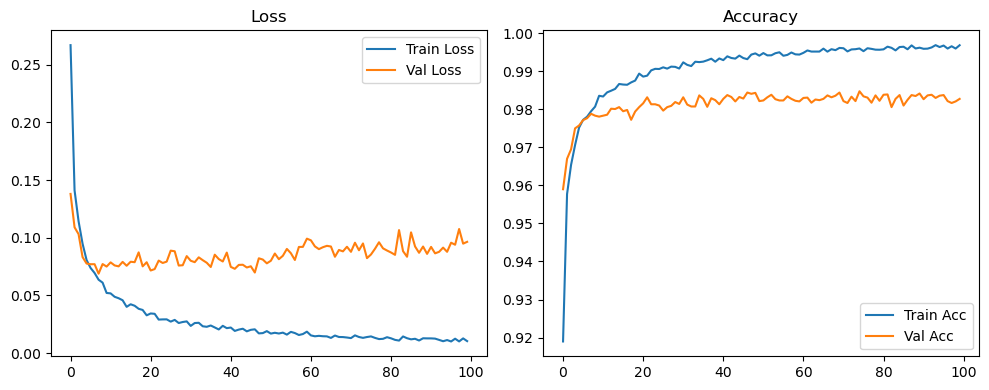

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4166, Acc: 0.8745 | Val Loss: 0.1617, Acc: 0.9522


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2455, Acc: 0.9281 | Val Loss: 0.1311, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2126, Acc: 0.9377 | Val Loss: 0.1127, Acc: 0.9652


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1921, Acc: 0.9442 | Val Loss: 0.1025, Acc: 0.9684


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1701, Acc: 0.9495 | Val Loss: 0.0979, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9534 | Val Loss: 0.0879, Acc: 0.9737


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1570, Acc: 0.9546 | Val Loss: 0.0831, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9572 | Val Loss: 0.0886, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9589 | Val Loss: 0.0894, Acc: 0.9761


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9612 | Val Loss: 0.0818, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1297, Acc: 0.9622 | Val Loss: 0.0830, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9634 | Val Loss: 0.0812, Acc: 0.9763


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1231, Acc: 0.9627 | Val Loss: 0.0818, Acc: 0.9762


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1204, Acc: 0.9646 | Val Loss: 0.0800, Acc: 0.9770


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9663 | Val Loss: 0.0725, Acc: 0.9795


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1140, Acc: 0.9665 | Val Loss: 0.0811, Acc: 0.9769


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9666 | Val Loss: 0.0705, Acc: 0.9791


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9678 | Val Loss: 0.0756, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9684 | Val Loss: 0.0697, Acc: 0.9792


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9703 | Val Loss: 0.0782, Acc: 0.9770


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9700 | Val Loss: 0.0784, Acc: 0.9781


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1011, Acc: 0.9705 | Val Loss: 0.0733, Acc: 0.9790


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9710 | Val Loss: 0.0803, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9722 | Val Loss: 0.0745, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9727 | Val Loss: 0.0764, Acc: 0.9791


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9736 | Val Loss: 0.0709, Acc: 0.9806


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9729 | Val Loss: 0.0727, Acc: 0.9807


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9743 | Val Loss: 0.0707, Acc: 0.9805


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9744 | Val Loss: 0.0718, Acc: 0.9804


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9742 | Val Loss: 0.0695, Acc: 0.9807


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9743 | Val Loss: 0.0711, Acc: 0.9810


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9749 | Val Loss: 0.0695, Acc: 0.9807


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0845, Acc: 0.9748 | Val Loss: 0.0747, Acc: 0.9799


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9755 | Val Loss: 0.0688, Acc: 0.9810


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9767 | Val Loss: 0.0714, Acc: 0.9804


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9750 | Val Loss: 0.0746, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9764 | Val Loss: 0.0739, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9770 | Val Loss: 0.0710, Acc: 0.9811


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9778 | Val Loss: 0.0773, Acc: 0.9805


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9772 | Val Loss: 0.0696, Acc: 0.9818


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9770 | Val Loss: 0.0713, Acc: 0.9818


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9782 | Val Loss: 0.0716, Acc: 0.9826


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9771 | Val Loss: 0.0733, Acc: 0.9808


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9791 | Val Loss: 0.0700, Acc: 0.9808


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9791 | Val Loss: 0.0672, Acc: 0.9813


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9784 | Val Loss: 0.0747, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9784 | Val Loss: 0.0670, Acc: 0.9818


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9795 | Val Loss: 0.0764, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.0723, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9796 | Val Loss: 0.0718, Acc: 0.9809


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9805 | Val Loss: 0.0748, Acc: 0.9802


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9804 | Val Loss: 0.0756, Acc: 0.9804


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9799 | Val Loss: 0.0734, Acc: 0.9818


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9800 | Val Loss: 0.0741, Acc: 0.9805


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9811 | Val Loss: 0.0671, Acc: 0.9815


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9807 | Val Loss: 0.0759, Acc: 0.9813


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9806 | Val Loss: 0.0704, Acc: 0.9827


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9815 | Val Loss: 0.0784, Acc: 0.9812


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9814 | Val Loss: 0.0774, Acc: 0.9815


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9815 | Val Loss: 0.0747, Acc: 0.9811


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9814 | Val Loss: 0.0772, Acc: 0.9830


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9822 | Val Loss: 0.0787, Acc: 0.9818


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9825 | Val Loss: 0.0760, Acc: 0.9818


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9818 | Val Loss: 0.0770, Acc: 0.9814


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9820 | Val Loss: 0.0764, Acc: 0.9813


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9819 | Val Loss: 0.0779, Acc: 0.9821


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9820 | Val Loss: 0.0785, Acc: 0.9804


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9831 | Val Loss: 0.0723, Acc: 0.9815


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9828 | Val Loss: 0.0726, Acc: 0.9815


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9824 | Val Loss: 0.0795, Acc: 0.9818


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9812 | Val Loss: 0.0752, Acc: 0.9808


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9831 | Val Loss: 0.0715, Acc: 0.9825


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0777, Acc: 0.9803


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9826 | Val Loss: 0.0823, Acc: 0.9812


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9833 | Val Loss: 0.0780, Acc: 0.9814


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9829 | Val Loss: 0.0823, Acc: 0.9811


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9840 | Val Loss: 0.0843, Acc: 0.9811


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9843 | Val Loss: 0.0832, Acc: 0.9808


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9839 | Val Loss: 0.0789, Acc: 0.9818


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9830 | Val Loss: 0.0774, Acc: 0.9825


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9847 | Val Loss: 0.0819, Acc: 0.9819


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9848 | Val Loss: 0.0785, Acc: 0.9810


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9831 | Val Loss: 0.0805, Acc: 0.9815


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9840 | Val Loss: 0.0774, Acc: 0.9811


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9853 | Val Loss: 0.0812, Acc: 0.9804


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9843 | Val Loss: 0.0772, Acc: 0.9811


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9839 | Val Loss: 0.0824, Acc: 0.9808


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9855 | Val Loss: 0.0744, Acc: 0.9827


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9852 | Val Loss: 0.0768, Acc: 0.9821


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9843 | Val Loss: 0.0828, Acc: 0.9828


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9851 | Val Loss: 0.0790, Acc: 0.9816


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9848 | Val Loss: 0.0754, Acc: 0.9824


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9841 | Val Loss: 0.0806, Acc: 0.9823


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9850 | Val Loss: 0.0793, Acc: 0.9826


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9846 | Val Loss: 0.0792, Acc: 0.9813


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9849 | Val Loss: 0.0842, Acc: 0.9819


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9845 | Val Loss: 0.0853, Acc: 0.9822


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9843 | Val Loss: 0.0830, Acc: 0.9828


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9854 | Val Loss: 0.0800, Acc: 0.9820


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9860 | Val Loss: 0.0772, Acc: 0.9818


Final Test Loss: 0.0702 Accuracy: 0.9834


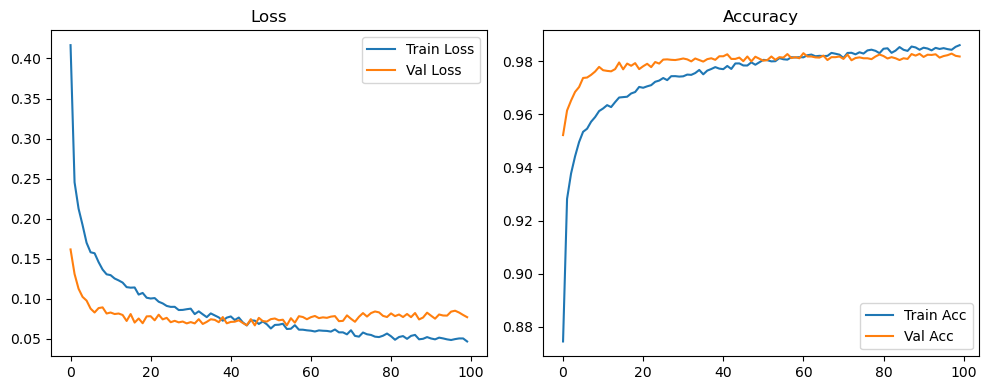

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2204, Acc: 0.9333 | Val Loss: 0.1415, Acc: 0.9583


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1062, Acc: 0.9669 | Val Loss: 0.1106, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9756 | Val Loss: 0.0999, Acc: 0.9695


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9813 | Val Loss: 0.0870, Acc: 0.9738


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9838 | Val Loss: 0.0936, Acc: 0.9731


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.0838, Acc: 0.9772


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.0819, Acc: 0.9772


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.0916, Acc: 0.9751


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0896, Acc: 0.9769


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0882, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0911, Acc: 0.9759


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0878, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.0981, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0952, Acc: 0.9764


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0977, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0942, Acc: 0.9786


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1007, Acc: 0.9796


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0998, Acc: 0.9771


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0972, Acc: 0.9789


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0991, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0936, Acc: 0.9792


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1141, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1003, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1049, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.0983, Acc: 0.9804


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0983, Acc: 0.9807


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0972, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0891, Acc: 0.9812


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0990, Acc: 0.9782


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0926, Acc: 0.9805


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0935, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0915, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.0966, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0962, Acc: 0.9792


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0999, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1060, Acc: 0.9805


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0858, Acc: 0.9825


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0974, Acc: 0.9808


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0933, Acc: 0.9814


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0942, Acc: 0.9828


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0994, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9811


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0942, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1014, Acc: 0.9797


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0952, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1025, Acc: 0.9794


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1031, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1068, Acc: 0.9829


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9799


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1032, Acc: 0.9828


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0893, Acc: 0.9838


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0955, Acc: 0.9844


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0938, Acc: 0.9845


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0987, Acc: 0.9844


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0983, Acc: 0.9843


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1159, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1019, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1114, Acc: 0.9831


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1116, Acc: 0.9824


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1062, Acc: 0.9837


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1116, Acc: 0.9832


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1134, Acc: 0.9839


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1184, Acc: 0.9832


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1242, Acc: 0.9825


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1109, Acc: 0.9831


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1126, Acc: 0.9837


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1182, Acc: 0.9825


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1212, Acc: 0.9831


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1253, Acc: 0.9817


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1304, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1267, Acc: 0.9831


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1213, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1225, Acc: 0.9828


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1147, Acc: 0.9843


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1167, Acc: 0.9839


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1135, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1153, Acc: 0.9838


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1296, Acc: 0.9832


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1225, Acc: 0.9842


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1212, Acc: 0.9836


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1157, Acc: 0.9848


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1144, Acc: 0.9852


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1152, Acc: 0.9855


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1144, Acc: 0.9855


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1155, Acc: 0.9853


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1202, Acc: 0.9847


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1158, Acc: 0.9851


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1207, Acc: 0.9848


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1187, Acc: 0.9852


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1171, Acc: 0.9850


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1198, Acc: 0.9848


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1212, Acc: 0.9846


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1183, Acc: 0.9851


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1268, Acc: 0.9837


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1258, Acc: 0.9850


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1181, Acc: 0.9853


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1189, Acc: 0.9857


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1227, Acc: 0.9849


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1219, Acc: 0.9851


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1255, Acc: 0.9851


Final Test Loss: 0.1274 Accuracy: 0.9849


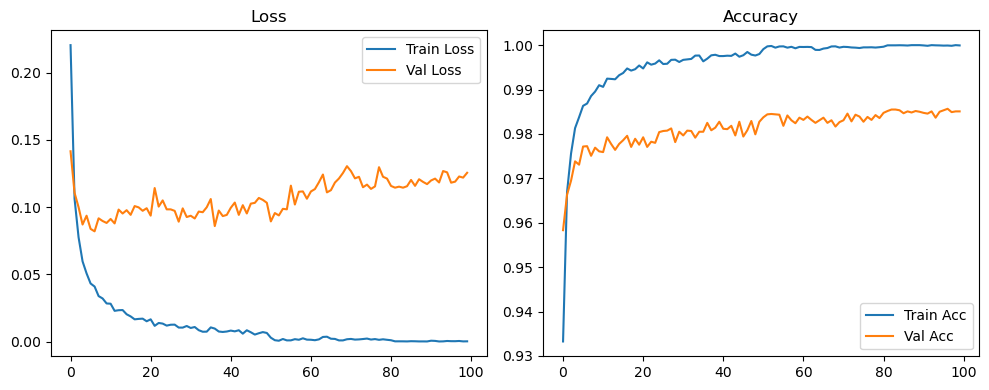

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2670, Acc: 0.9190 | Val Loss: 0.1380, Acc: 0.9590


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9577 | Val Loss: 0.1091, Acc: 0.9670


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9654 | Val Loss: 0.1032, Acc: 0.9695


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9706 | Val Loss: 0.0833, Acc: 0.9750


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0807, Acc: 0.9752 | Val Loss: 0.0777, Acc: 0.9758


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.0771, Acc: 0.9772


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9781 | Val Loss: 0.0771, Acc: 0.9777


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9795 | Val Loss: 0.0689, Acc: 0.9788


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9807 | Val Loss: 0.0772, Acc: 0.9783


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0751, Acc: 0.9781


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.0787, Acc: 0.9783


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.0760, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.0752, Acc: 0.9802


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0791, Acc: 0.9801


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9867 | Val Loss: 0.0758, Acc: 0.9806


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9865 | Val Loss: 0.0792, Acc: 0.9795


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0789, Acc: 0.9798


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9871 | Val Loss: 0.0874, Acc: 0.9772


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9876 | Val Loss: 0.0752, Acc: 0.9794


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0788, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0716, Acc: 0.9816


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0729, Acc: 0.9832


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0802, Acc: 0.9813


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0782, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0793, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0889, Acc: 0.9797


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0883, Acc: 0.9806


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0759, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0762, Acc: 0.9819


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9907 | Val Loss: 0.0841, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0801, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0789, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0831, Acc: 0.9808


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0806, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0784, Acc: 0.9837


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0747, Acc: 0.9828


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0853, Acc: 0.9807


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0816, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0794, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0872, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0748, Acc: 0.9828


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0731, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0765, Acc: 0.9832


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0766, Acc: 0.9821


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0743, Acc: 0.9832


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0753, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0699, Acc: 0.9844


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0822, Acc: 0.9841


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0811, Acc: 0.9843


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0779, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0726, Acc: 0.9848


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0745, Acc: 0.9851


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0772, Acc: 0.9847


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0781, Acc: 0.9842


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0805, Acc: 0.9849


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0774, Acc: 0.9851


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0787, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0751, Acc: 0.9843


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0888, Acc: 0.9839


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0825, Acc: 0.9836


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0839, Acc: 0.9837


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0852, Acc: 0.9842


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0891, Acc: 0.9842


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0880, Acc: 0.9841


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0883, Acc: 0.9844


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0867, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0865, Acc: 0.9839


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0922, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0878, Acc: 0.9847


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0916, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0949, Acc: 0.9849


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0941, Acc: 0.9837


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0892, Acc: 0.9849


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0885, Acc: 0.9853


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0915, Acc: 0.9852


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0854, Acc: 0.9844


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0817, Acc: 0.9853


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0888, Acc: 0.9836


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0887, Acc: 0.9840


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.0786, Acc: 0.9841


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0796, Acc: 0.9841


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0848, Acc: 0.9831


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0881, Acc: 0.9838


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0799, Acc: 0.9846


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0865, Acc: 0.9843


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0871, Acc: 0.9842


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0904, Acc: 0.9844


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0874, Acc: 0.9847


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0903, Acc: 0.9844


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0891, Acc: 0.9842


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0891, Acc: 0.9852


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0881, Acc: 0.9846


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0915, Acc: 0.9852


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0890, Acc: 0.9848


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0920, Acc: 0.9851


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0875, Acc: 0.9857


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0899, Acc: 0.9852


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0863, Acc: 0.9851


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0908, Acc: 0.9846


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0924, Acc: 0.9848


Final Test Loss: 0.0919 Accuracy: 0.9851


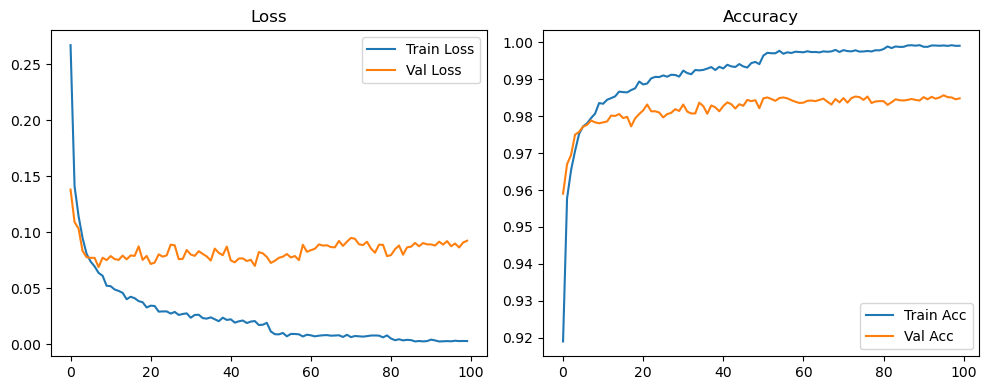

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4166, Acc: 0.8745 | Val Loss: 0.1617, Acc: 0.9522


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2455, Acc: 0.9281 | Val Loss: 0.1311, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2126, Acc: 0.9377 | Val Loss: 0.1127, Acc: 0.9652


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1921, Acc: 0.9442 | Val Loss: 0.1025, Acc: 0.9684


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1701, Acc: 0.9495 | Val Loss: 0.0979, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9534 | Val Loss: 0.0879, Acc: 0.9737


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1570, Acc: 0.9546 | Val Loss: 0.0831, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9572 | Val Loss: 0.0886, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9589 | Val Loss: 0.0894, Acc: 0.9761


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9612 | Val Loss: 0.0818, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1297, Acc: 0.9622 | Val Loss: 0.0830, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9634 | Val Loss: 0.0812, Acc: 0.9763


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1231, Acc: 0.9627 | Val Loss: 0.0818, Acc: 0.9762


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1204, Acc: 0.9646 | Val Loss: 0.0800, Acc: 0.9770


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9663 | Val Loss: 0.0725, Acc: 0.9795


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1140, Acc: 0.9665 | Val Loss: 0.0811, Acc: 0.9769


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9666 | Val Loss: 0.0705, Acc: 0.9791


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9678 | Val Loss: 0.0756, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9684 | Val Loss: 0.0697, Acc: 0.9792


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9703 | Val Loss: 0.0782, Acc: 0.9770


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9700 | Val Loss: 0.0784, Acc: 0.9781


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1011, Acc: 0.9705 | Val Loss: 0.0733, Acc: 0.9790


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9710 | Val Loss: 0.0803, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9722 | Val Loss: 0.0745, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9727 | Val Loss: 0.0764, Acc: 0.9791


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9736 | Val Loss: 0.0709, Acc: 0.9806


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9729 | Val Loss: 0.0727, Acc: 0.9807


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9743 | Val Loss: 0.0707, Acc: 0.9805


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9744 | Val Loss: 0.0718, Acc: 0.9804


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9742 | Val Loss: 0.0695, Acc: 0.9807


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9743 | Val Loss: 0.0711, Acc: 0.9810


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9749 | Val Loss: 0.0695, Acc: 0.9807


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0845, Acc: 0.9748 | Val Loss: 0.0747, Acc: 0.9799


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9755 | Val Loss: 0.0688, Acc: 0.9810


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9767 | Val Loss: 0.0714, Acc: 0.9804


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9750 | Val Loss: 0.0746, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9764 | Val Loss: 0.0739, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9770 | Val Loss: 0.0710, Acc: 0.9811


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9778 | Val Loss: 0.0773, Acc: 0.9805


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9772 | Val Loss: 0.0696, Acc: 0.9818


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9770 | Val Loss: 0.0713, Acc: 0.9818


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9782 | Val Loss: 0.0716, Acc: 0.9826


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9771 | Val Loss: 0.0733, Acc: 0.9808


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9791 | Val Loss: 0.0700, Acc: 0.9808


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9791 | Val Loss: 0.0672, Acc: 0.9813


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9784 | Val Loss: 0.0747, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9784 | Val Loss: 0.0670, Acc: 0.9818


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9795 | Val Loss: 0.0764, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.0723, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9796 | Val Loss: 0.0718, Acc: 0.9809


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9836 | Val Loss: 0.0722, Acc: 0.9820


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9843 | Val Loss: 0.0674, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9854 | Val Loss: 0.0686, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9854 | Val Loss: 0.0702, Acc: 0.9831


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9871 | Val Loss: 0.0680, Acc: 0.9831


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9864 | Val Loss: 0.0740, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9864 | Val Loss: 0.0681, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9861 | Val Loss: 0.0713, Acc: 0.9821


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.0732, Acc: 0.9818


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9867 | Val Loss: 0.0680, Acc: 0.9828


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9866 | Val Loss: 0.0678, Acc: 0.9834


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9876 | Val Loss: 0.0716, Acc: 0.9830


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 0.0711, Acc: 0.9827


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9872 | Val Loss: 0.0715, Acc: 0.9829


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9879 | Val Loss: 0.0747, Acc: 0.9819


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9880 | Val Loss: 0.0734, Acc: 0.9827


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9862 | Val Loss: 0.0713, Acc: 0.9831


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9881 | Val Loss: 0.0723, Acc: 0.9822


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.0736, Acc: 0.9825


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9880 | Val Loss: 0.0754, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.0731, Acc: 0.9820


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9888 | Val Loss: 0.0734, Acc: 0.9827


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9894 | Val Loss: 0.0757, Acc: 0.9825


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9871 | Val Loss: 0.0736, Acc: 0.9827


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 0.0722, Acc: 0.9813


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9885 | Val Loss: 0.0776, Acc: 0.9827


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9886 | Val Loss: 0.0783, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9888 | Val Loss: 0.0789, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9884 | Val Loss: 0.0753, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.0775, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9894 | Val Loss: 0.0736, Acc: 0.9832


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.0738, Acc: 0.9832


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9910 | Val Loss: 0.0785, Acc: 0.9826


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.0737, Acc: 0.9830


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.0706, Acc: 0.9828


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.0739, Acc: 0.9827


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9921 | Val Loss: 0.0752, Acc: 0.9826


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9924 | Val Loss: 0.0761, Acc: 0.9828


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.0719, Acc: 0.9832


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0749, Acc: 0.9835


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9919 | Val Loss: 0.0746, Acc: 0.9839


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0770, Acc: 0.9828


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9917 | Val Loss: 0.0743, Acc: 0.9829


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9917 | Val Loss: 0.0740, Acc: 0.9833


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.0763, Acc: 0.9834


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.0771, Acc: 0.9829


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9916 | Val Loss: 0.0722, Acc: 0.9834


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9924 | Val Loss: 0.0777, Acc: 0.9837


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0772, Acc: 0.9826


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9924 | Val Loss: 0.0744, Acc: 0.9834


Final Test Loss: 0.0701 Accuracy: 0.9849


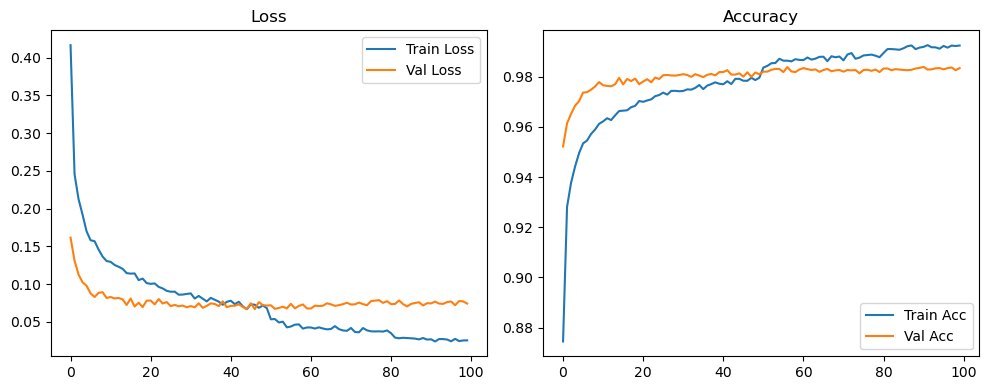

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2204, Acc: 0.9333 | Val Loss: 0.1415, Acc: 0.9583


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1062, Acc: 0.9669 | Val Loss: 0.1106, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9756 | Val Loss: 0.0999, Acc: 0.9695


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9813 | Val Loss: 0.0870, Acc: 0.9738


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9838 | Val Loss: 0.0936, Acc: 0.9731


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.0838, Acc: 0.9772


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.0819, Acc: 0.9772


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.0916, Acc: 0.9751


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0896, Acc: 0.9769


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0882, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0911, Acc: 0.9759


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0878, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.0981, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0952, Acc: 0.9764


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0977, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0942, Acc: 0.9786


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1007, Acc: 0.9796


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0998, Acc: 0.9771


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0972, Acc: 0.9789


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0991, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0936, Acc: 0.9792


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1141, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1003, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1049, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.0983, Acc: 0.9804


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0983, Acc: 0.9807


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0972, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0891, Acc: 0.9812


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0990, Acc: 0.9782


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0926, Acc: 0.9805


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0935, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0915, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.0966, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0962, Acc: 0.9792


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0999, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1060, Acc: 0.9805


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0858, Acc: 0.9825


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0974, Acc: 0.9808


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0933, Acc: 0.9814


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0942, Acc: 0.9828


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0994, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9811


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0942, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1014, Acc: 0.9797


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0952, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1025, Acc: 0.9794


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1031, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1068, Acc: 0.9829


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9799


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1032, Acc: 0.9828


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0893, Acc: 0.9838


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0955, Acc: 0.9844


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0938, Acc: 0.9845


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0987, Acc: 0.9844


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0983, Acc: 0.9843


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1159, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1019, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1114, Acc: 0.9831


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1116, Acc: 0.9824


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1062, Acc: 0.9837


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1116, Acc: 0.9832


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1134, Acc: 0.9839


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1184, Acc: 0.9832


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1242, Acc: 0.9825


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1109, Acc: 0.9831


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1126, Acc: 0.9837


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1182, Acc: 0.9825


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1212, Acc: 0.9831


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1253, Acc: 0.9817


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1304, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1267, Acc: 0.9831


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1213, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1225, Acc: 0.9828


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1147, Acc: 0.9843


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1167, Acc: 0.9839


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1135, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1153, Acc: 0.9838


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1296, Acc: 0.9832


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1225, Acc: 0.9842


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1212, Acc: 0.9836


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1163, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1142, Acc: 0.9851


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1143, Acc: 0.9854


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1133, Acc: 0.9853


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1141, Acc: 0.9850


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1151, Acc: 0.9850


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1120, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1139, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1159, Acc: 0.9857


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1135, Acc: 0.9850


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1167, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1165, Acc: 0.9852


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1164, Acc: 0.9856


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1159, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1168, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1141, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1169, Acc: 0.9853


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1201, Acc: 0.9856


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1194, Acc: 0.9862


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1169, Acc: 0.9862


Final Test Loss: 0.1205 Accuracy: 0.9852


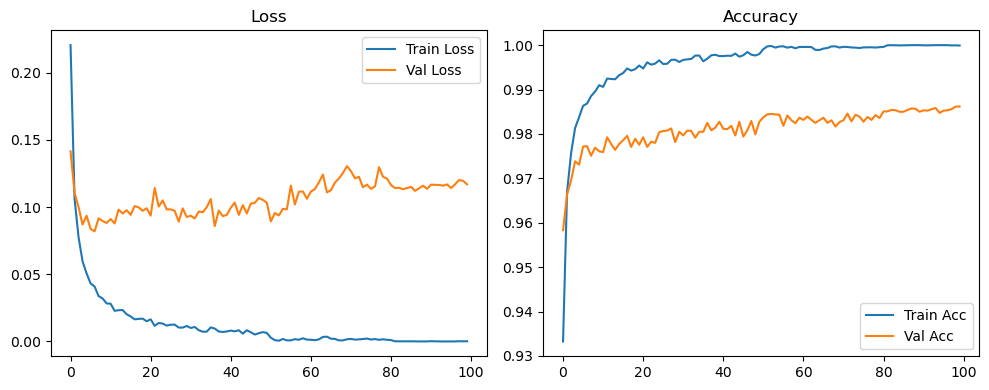

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2670, Acc: 0.9190 | Val Loss: 0.1380, Acc: 0.9590


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9577 | Val Loss: 0.1091, Acc: 0.9670


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9654 | Val Loss: 0.1032, Acc: 0.9695


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9706 | Val Loss: 0.0833, Acc: 0.9750


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0807, Acc: 0.9752 | Val Loss: 0.0777, Acc: 0.9758


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.0771, Acc: 0.9772


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9781 | Val Loss: 0.0771, Acc: 0.9777


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9795 | Val Loss: 0.0689, Acc: 0.9788


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9807 | Val Loss: 0.0772, Acc: 0.9783


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0751, Acc: 0.9781


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.0787, Acc: 0.9783


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.0760, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.0752, Acc: 0.9802


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0791, Acc: 0.9801


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9867 | Val Loss: 0.0758, Acc: 0.9806


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9865 | Val Loss: 0.0792, Acc: 0.9795


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0789, Acc: 0.9798


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9871 | Val Loss: 0.0874, Acc: 0.9772


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9876 | Val Loss: 0.0752, Acc: 0.9794


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0788, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0716, Acc: 0.9816


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0729, Acc: 0.9832


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0802, Acc: 0.9813


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0782, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0793, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0889, Acc: 0.9797


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0883, Acc: 0.9806


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0759, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0762, Acc: 0.9819


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9907 | Val Loss: 0.0841, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0801, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0789, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0831, Acc: 0.9808


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0806, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0784, Acc: 0.9837


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0747, Acc: 0.9828


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0853, Acc: 0.9807


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0816, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0794, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0872, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0748, Acc: 0.9828


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0731, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0765, Acc: 0.9832


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0766, Acc: 0.9821


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0743, Acc: 0.9832


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0753, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0699, Acc: 0.9844


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0822, Acc: 0.9841


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0811, Acc: 0.9843


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0779, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0726, Acc: 0.9848


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0745, Acc: 0.9851


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0772, Acc: 0.9847


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0781, Acc: 0.9842


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0805, Acc: 0.9849


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0774, Acc: 0.9851


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0787, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0751, Acc: 0.9843


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0888, Acc: 0.9839


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0825, Acc: 0.9836


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0839, Acc: 0.9837


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0852, Acc: 0.9842


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0891, Acc: 0.9842


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0880, Acc: 0.9841


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0883, Acc: 0.9844


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0867, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0865, Acc: 0.9839


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0922, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0878, Acc: 0.9847


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0916, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0949, Acc: 0.9849


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0941, Acc: 0.9837


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0892, Acc: 0.9849


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0885, Acc: 0.9853


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0915, Acc: 0.9852


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0854, Acc: 0.9844


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0817, Acc: 0.9853


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0888, Acc: 0.9836


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0887, Acc: 0.9840


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.0786, Acc: 0.9841


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0776, Acc: 0.9837


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0794, Acc: 0.9840


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0850, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0779, Acc: 0.9851


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0823, Acc: 0.9844


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0848, Acc: 0.9843


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0842, Acc: 0.9846


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0837, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0864, Acc: 0.9843


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0836, Acc: 0.9843


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0856, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0837, Acc: 0.9848


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0872, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0860, Acc: 0.9854


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0884, Acc: 0.9851


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0839, Acc: 0.9856


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0874, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0860, Acc: 0.9854


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0875, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0864, Acc: 0.9858


Final Test Loss: 0.0872 Accuracy: 0.9852


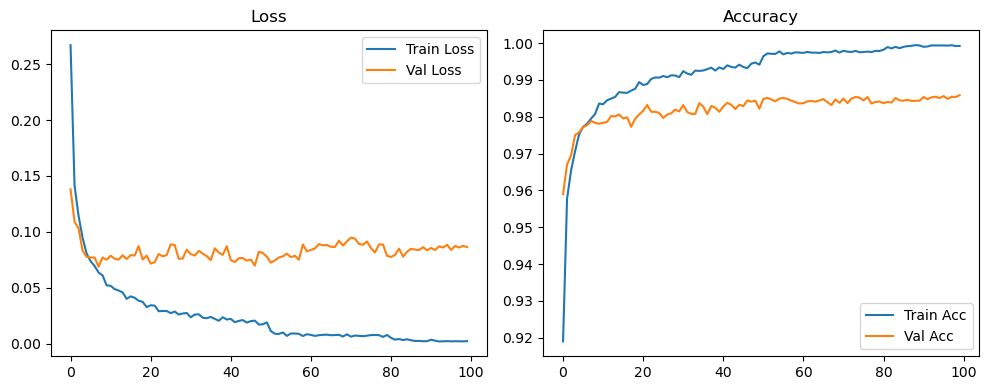

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4166, Acc: 0.8745 | Val Loss: 0.1617, Acc: 0.9522


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2455, Acc: 0.9281 | Val Loss: 0.1311, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2126, Acc: 0.9377 | Val Loss: 0.1127, Acc: 0.9652


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1921, Acc: 0.9442 | Val Loss: 0.1025, Acc: 0.9684


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1701, Acc: 0.9495 | Val Loss: 0.0979, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9534 | Val Loss: 0.0879, Acc: 0.9737


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1570, Acc: 0.9546 | Val Loss: 0.0831, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9572 | Val Loss: 0.0886, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9589 | Val Loss: 0.0894, Acc: 0.9761


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9612 | Val Loss: 0.0818, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1297, Acc: 0.9622 | Val Loss: 0.0830, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9634 | Val Loss: 0.0812, Acc: 0.9763


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1231, Acc: 0.9627 | Val Loss: 0.0818, Acc: 0.9762


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1204, Acc: 0.9646 | Val Loss: 0.0800, Acc: 0.9770


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9663 | Val Loss: 0.0725, Acc: 0.9795


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1140, Acc: 0.9665 | Val Loss: 0.0811, Acc: 0.9769


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9666 | Val Loss: 0.0705, Acc: 0.9791


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9678 | Val Loss: 0.0756, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9684 | Val Loss: 0.0697, Acc: 0.9792


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9703 | Val Loss: 0.0782, Acc: 0.9770


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9700 | Val Loss: 0.0784, Acc: 0.9781


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1011, Acc: 0.9705 | Val Loss: 0.0733, Acc: 0.9790


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9710 | Val Loss: 0.0803, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9722 | Val Loss: 0.0745, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9727 | Val Loss: 0.0764, Acc: 0.9791


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9736 | Val Loss: 0.0709, Acc: 0.9806


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9729 | Val Loss: 0.0727, Acc: 0.9807


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9743 | Val Loss: 0.0707, Acc: 0.9805


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9744 | Val Loss: 0.0718, Acc: 0.9804


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9742 | Val Loss: 0.0695, Acc: 0.9807


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9743 | Val Loss: 0.0711, Acc: 0.9810


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9749 | Val Loss: 0.0695, Acc: 0.9807


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0845, Acc: 0.9748 | Val Loss: 0.0747, Acc: 0.9799


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9755 | Val Loss: 0.0688, Acc: 0.9810


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9767 | Val Loss: 0.0714, Acc: 0.9804


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9750 | Val Loss: 0.0746, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9764 | Val Loss: 0.0739, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9770 | Val Loss: 0.0710, Acc: 0.9811


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9778 | Val Loss: 0.0773, Acc: 0.9805


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9772 | Val Loss: 0.0696, Acc: 0.9818


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9770 | Val Loss: 0.0713, Acc: 0.9818


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9782 | Val Loss: 0.0716, Acc: 0.9826


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9771 | Val Loss: 0.0733, Acc: 0.9808


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9791 | Val Loss: 0.0700, Acc: 0.9808


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9791 | Val Loss: 0.0672, Acc: 0.9813


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9784 | Val Loss: 0.0747, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9784 | Val Loss: 0.0670, Acc: 0.9818


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9795 | Val Loss: 0.0764, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.0723, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9796 | Val Loss: 0.0718, Acc: 0.9809


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9836 | Val Loss: 0.0722, Acc: 0.9820


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9843 | Val Loss: 0.0674, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9854 | Val Loss: 0.0686, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9854 | Val Loss: 0.0702, Acc: 0.9831


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9871 | Val Loss: 0.0680, Acc: 0.9831


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9864 | Val Loss: 0.0740, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9864 | Val Loss: 0.0681, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9861 | Val Loss: 0.0713, Acc: 0.9821


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.0732, Acc: 0.9818


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9867 | Val Loss: 0.0680, Acc: 0.9828


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9866 | Val Loss: 0.0678, Acc: 0.9834


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9876 | Val Loss: 0.0716, Acc: 0.9830


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 0.0711, Acc: 0.9827


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9872 | Val Loss: 0.0715, Acc: 0.9829


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9879 | Val Loss: 0.0747, Acc: 0.9819


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9880 | Val Loss: 0.0734, Acc: 0.9827


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9862 | Val Loss: 0.0713, Acc: 0.9831


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9881 | Val Loss: 0.0723, Acc: 0.9822


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.0736, Acc: 0.9825


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9880 | Val Loss: 0.0754, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.0731, Acc: 0.9820


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9888 | Val Loss: 0.0734, Acc: 0.9827


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9894 | Val Loss: 0.0757, Acc: 0.9825


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9871 | Val Loss: 0.0736, Acc: 0.9827


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 0.0722, Acc: 0.9813


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9885 | Val Loss: 0.0776, Acc: 0.9827


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9886 | Val Loss: 0.0783, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9888 | Val Loss: 0.0789, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9884 | Val Loss: 0.0753, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.0775, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9893 | Val Loss: 0.0748, Acc: 0.9829


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9911 | Val Loss: 0.0737, Acc: 0.9830


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9914 | Val Loss: 0.0779, Acc: 0.9829


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0746, Acc: 0.9829


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9906 | Val Loss: 0.0711, Acc: 0.9829


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9916 | Val Loss: 0.0739, Acc: 0.9828


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9918 | Val Loss: 0.0737, Acc: 0.9828


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9922 | Val Loss: 0.0755, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.0720, Acc: 0.9835


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0737, Acc: 0.9831


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0748, Acc: 0.9828


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0753, Acc: 0.9826


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0734, Acc: 0.9831


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9918 | Val Loss: 0.0727, Acc: 0.9831


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0744, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0748, Acc: 0.9827


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.0729, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.0769, Acc: 0.9833


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9926 | Val Loss: 0.0767, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9931 | Val Loss: 0.0731, Acc: 0.9832


Final Test Loss: 0.0695 Accuracy: 0.9850


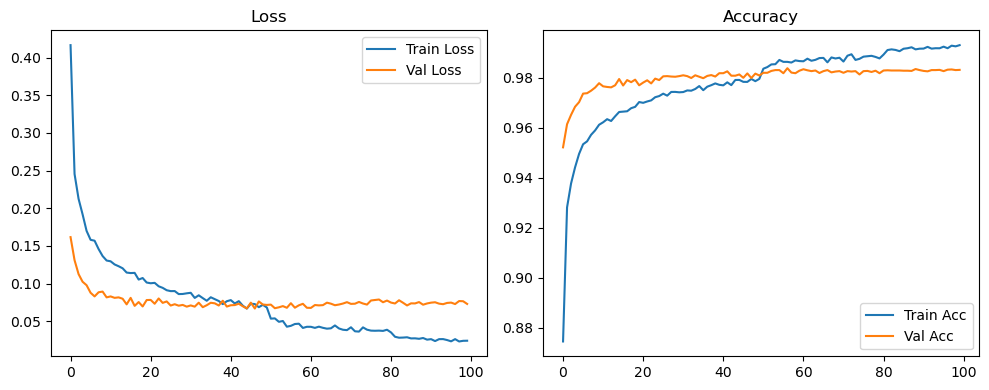

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2204, Acc: 0.9333 | Val Loss: 0.1415, Acc: 0.9583


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1062, Acc: 0.9669 | Val Loss: 0.1106, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9756 | Val Loss: 0.0999, Acc: 0.9695


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9813 | Val Loss: 0.0870, Acc: 0.9738


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9838 | Val Loss: 0.0936, Acc: 0.9731


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.0838, Acc: 0.9772


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.0819, Acc: 0.9772


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.0916, Acc: 0.9751


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0896, Acc: 0.9769


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0882, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0911, Acc: 0.9759


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0878, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.0981, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0952, Acc: 0.9764


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0977, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0942, Acc: 0.9786


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1007, Acc: 0.9796


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0998, Acc: 0.9771


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0972, Acc: 0.9789


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0991, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0936, Acc: 0.9792


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1141, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1003, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1049, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.0983, Acc: 0.9804


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0983, Acc: 0.9807


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0972, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0891, Acc: 0.9812


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0990, Acc: 0.9782


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0926, Acc: 0.9805


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0935, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0915, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.0966, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0962, Acc: 0.9792


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0999, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1060, Acc: 0.9805


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0858, Acc: 0.9825


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0974, Acc: 0.9808


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0933, Acc: 0.9814


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0942, Acc: 0.9828


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0994, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9811


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0942, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1014, Acc: 0.9797


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0952, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1025, Acc: 0.9794


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1031, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1068, Acc: 0.9829


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9799


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1032, Acc: 0.9828


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0922, Acc: 0.9831


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0933, Acc: 0.9843


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0910, Acc: 0.9844


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0896, Acc: 0.9843


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0888, Acc: 0.9846


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0880, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0898, Acc: 0.9858


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0926, Acc: 0.9850


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0918, Acc: 0.9853


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0925, Acc: 0.9854


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0974, Acc: 0.9856


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0986, Acc: 0.9848


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1001, Acc: 0.9851


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1060, Acc: 0.9847


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1023, Acc: 0.9852


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1047, Acc: 0.9842


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1105, Acc: 0.9847


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1056, Acc: 0.9855


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1109, Acc: 0.9844


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1125, Acc: 0.9850


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1090, Acc: 0.9847


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1158, Acc: 0.9841


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1089, Acc: 0.9849


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1114, Acc: 0.9846


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1057, Acc: 0.9850


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1091, Acc: 0.9858


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1083, Acc: 0.9862


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1149, Acc: 0.9844


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1140, Acc: 0.9853


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1124, Acc: 0.9845


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1120, Acc: 0.9852


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1152, Acc: 0.9858


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1094, Acc: 0.9855


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1136, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1119, Acc: 0.9855


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1133, Acc: 0.9855


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1179, Acc: 0.9845


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1173, Acc: 0.9853


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1157, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1197, Acc: 0.9854


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1202, Acc: 0.9851


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1159, Acc: 0.9855


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1163, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1158, Acc: 0.9860


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1178, Acc: 0.9855


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1233, Acc: 0.9847


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1200, Acc: 0.9859


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1210, Acc: 0.9852


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1208, Acc: 0.9857


Final Test Loss: 0.1200 Accuracy: 0.9849


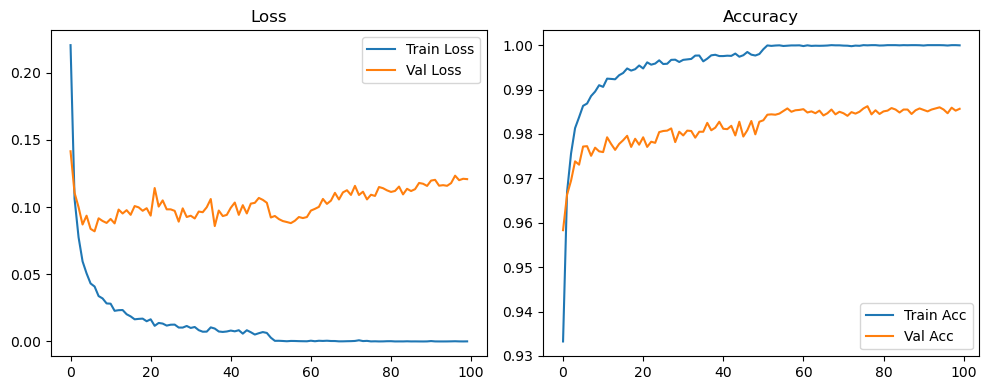

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2670, Acc: 0.9190 | Val Loss: 0.1380, Acc: 0.9590


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9577 | Val Loss: 0.1091, Acc: 0.9670


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9654 | Val Loss: 0.1032, Acc: 0.9695


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9706 | Val Loss: 0.0833, Acc: 0.9750


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0807, Acc: 0.9752 | Val Loss: 0.0777, Acc: 0.9758


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.0771, Acc: 0.9772


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9781 | Val Loss: 0.0771, Acc: 0.9777


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9795 | Val Loss: 0.0689, Acc: 0.9788


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9807 | Val Loss: 0.0772, Acc: 0.9783


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0751, Acc: 0.9781


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.0787, Acc: 0.9783


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.0760, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.0752, Acc: 0.9802


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0791, Acc: 0.9801


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9867 | Val Loss: 0.0758, Acc: 0.9806


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9865 | Val Loss: 0.0792, Acc: 0.9795


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0789, Acc: 0.9798


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9871 | Val Loss: 0.0874, Acc: 0.9772


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9876 | Val Loss: 0.0752, Acc: 0.9794


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0788, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0716, Acc: 0.9816


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0729, Acc: 0.9832


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0802, Acc: 0.9813


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0782, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0793, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0889, Acc: 0.9797


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0883, Acc: 0.9806


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0759, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0762, Acc: 0.9819


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9907 | Val Loss: 0.0841, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0801, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0789, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0831, Acc: 0.9808


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0806, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0784, Acc: 0.9837


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0747, Acc: 0.9828


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0853, Acc: 0.9807


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0816, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0794, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0872, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0748, Acc: 0.9828


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0731, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0765, Acc: 0.9832


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0766, Acc: 0.9821


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0743, Acc: 0.9832


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0753, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0699, Acc: 0.9844


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0822, Acc: 0.9841


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0811, Acc: 0.9843


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0779, Acc: 0.9822


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0688, Acc: 0.9848


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0708, Acc: 0.9858


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0719, Acc: 0.9858


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0722, Acc: 0.9858


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0736, Acc: 0.9858


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0730, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0740, Acc: 0.9862


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0733, Acc: 0.9864


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0770, Acc: 0.9858


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0765, Acc: 0.9855


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0812, Acc: 0.9856


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0795, Acc: 0.9857


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0825, Acc: 0.9852


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0821, Acc: 0.9855


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0819, Acc: 0.9843


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0840, Acc: 0.9857


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0802, Acc: 0.9857


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0826, Acc: 0.9852


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0816, Acc: 0.9854


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0803, Acc: 0.9857


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0856, Acc: 0.9865


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0858, Acc: 0.9852


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0840, Acc: 0.9857


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0866, Acc: 0.9855


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0882, Acc: 0.9849


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0856, Acc: 0.9846


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0835, Acc: 0.9856


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0867, Acc: 0.9854


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0862, Acc: 0.9857


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0847, Acc: 0.9859


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0850, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0844, Acc: 0.9854


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0923, Acc: 0.9855


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0831, Acc: 0.9860


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0854, Acc: 0.9850


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0865, Acc: 0.9850


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0860, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0868, Acc: 0.9855


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0839, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0853, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0870, Acc: 0.9849


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0886, Acc: 0.9855


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0872, Acc: 0.9854


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0844, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0878, Acc: 0.9853


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0856, Acc: 0.9862


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0889, Acc: 0.9850


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0869, Acc: 0.9855


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0876, Acc: 0.9848


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0858, Acc: 0.9858


Final Test Loss: 0.0891 Accuracy: 0.9854


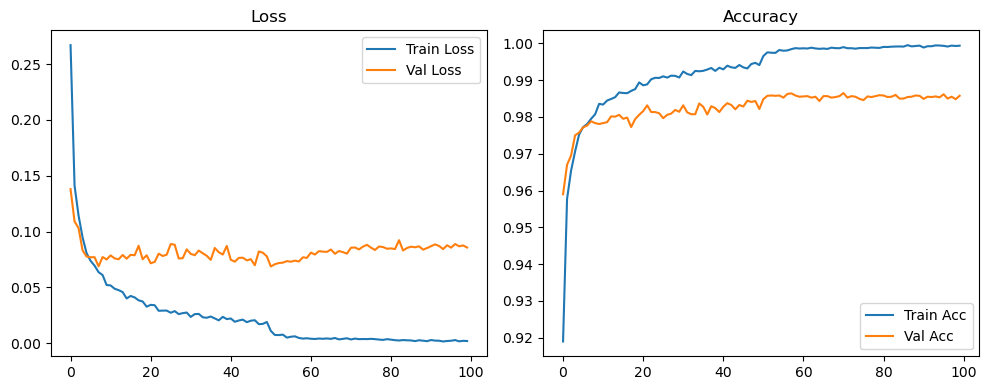

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4166, Acc: 0.8745 | Val Loss: 0.1617, Acc: 0.9522


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2455, Acc: 0.9281 | Val Loss: 0.1311, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2126, Acc: 0.9377 | Val Loss: 0.1127, Acc: 0.9652


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1921, Acc: 0.9442 | Val Loss: 0.1025, Acc: 0.9684


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1701, Acc: 0.9495 | Val Loss: 0.0979, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9534 | Val Loss: 0.0879, Acc: 0.9737


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1570, Acc: 0.9546 | Val Loss: 0.0831, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9572 | Val Loss: 0.0886, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9589 | Val Loss: 0.0894, Acc: 0.9761


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9612 | Val Loss: 0.0818, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1297, Acc: 0.9622 | Val Loss: 0.0830, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9634 | Val Loss: 0.0812, Acc: 0.9763


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1231, Acc: 0.9627 | Val Loss: 0.0818, Acc: 0.9762


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1204, Acc: 0.9646 | Val Loss: 0.0800, Acc: 0.9770


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9663 | Val Loss: 0.0725, Acc: 0.9795


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1140, Acc: 0.9665 | Val Loss: 0.0811, Acc: 0.9769


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9666 | Val Loss: 0.0705, Acc: 0.9791


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9678 | Val Loss: 0.0756, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9684 | Val Loss: 0.0697, Acc: 0.9792


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9703 | Val Loss: 0.0782, Acc: 0.9770


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9700 | Val Loss: 0.0784, Acc: 0.9781


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1011, Acc: 0.9705 | Val Loss: 0.0733, Acc: 0.9790


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9710 | Val Loss: 0.0803, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9722 | Val Loss: 0.0745, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9727 | Val Loss: 0.0764, Acc: 0.9791


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9736 | Val Loss: 0.0709, Acc: 0.9806


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9729 | Val Loss: 0.0727, Acc: 0.9807


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9743 | Val Loss: 0.0707, Acc: 0.9805


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9744 | Val Loss: 0.0718, Acc: 0.9804


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9742 | Val Loss: 0.0695, Acc: 0.9807


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9743 | Val Loss: 0.0711, Acc: 0.9810


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9749 | Val Loss: 0.0695, Acc: 0.9807


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0845, Acc: 0.9748 | Val Loss: 0.0747, Acc: 0.9799


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9755 | Val Loss: 0.0688, Acc: 0.9810


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9767 | Val Loss: 0.0714, Acc: 0.9804


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9750 | Val Loss: 0.0746, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9764 | Val Loss: 0.0739, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9770 | Val Loss: 0.0710, Acc: 0.9811


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9778 | Val Loss: 0.0773, Acc: 0.9805


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9772 | Val Loss: 0.0696, Acc: 0.9818


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9770 | Val Loss: 0.0713, Acc: 0.9818


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9782 | Val Loss: 0.0716, Acc: 0.9826


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9771 | Val Loss: 0.0733, Acc: 0.9808


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9791 | Val Loss: 0.0700, Acc: 0.9808


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9791 | Val Loss: 0.0672, Acc: 0.9813


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9784 | Val Loss: 0.0747, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9784 | Val Loss: 0.0670, Acc: 0.9818


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9795 | Val Loss: 0.0764, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.0723, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9796 | Val Loss: 0.0718, Acc: 0.9809


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9842 | Val Loss: 0.0695, Acc: 0.9816


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9849 | Val Loss: 0.0666, Acc: 0.9825


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9861 | Val Loss: 0.0671, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9860 | Val Loss: 0.0685, Acc: 0.9832


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9882 | Val Loss: 0.0670, Acc: 0.9828


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.0711, Acc: 0.9819


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9873 | Val Loss: 0.0681, Acc: 0.9827


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9876 | Val Loss: 0.0683, Acc: 0.9823


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9886 | Val Loss: 0.0722, Acc: 0.9825


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 0.0681, Acc: 0.9828


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0683, Acc: 0.9835


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.0697, Acc: 0.9823


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0716, Acc: 0.9831


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9893 | Val Loss: 0.0682, Acc: 0.9831


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.0682, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9899 | Val Loss: 0.0708, Acc: 0.9837


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0707, Acc: 0.9830


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9899 | Val Loss: 0.0720, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9900 | Val Loss: 0.0716, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.0716, Acc: 0.9829


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.0739, Acc: 0.9817


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9907 | Val Loss: 0.0734, Acc: 0.9822


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.0736, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.0724, Acc: 0.9821


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0700, Acc: 0.9827


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.0739, Acc: 0.9828


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.0717, Acc: 0.9830


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9910 | Val Loss: 0.0721, Acc: 0.9832


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.0708, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.0716, Acc: 0.9827


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9913 | Val Loss: 0.0717, Acc: 0.9826


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.0715, Acc: 0.9829


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.0755, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.0726, Acc: 0.9830


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.0698, Acc: 0.9830


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9914 | Val Loss: 0.0709, Acc: 0.9831


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9917 | Val Loss: 0.0708, Acc: 0.9828


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9924 | Val Loss: 0.0743, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9917 | Val Loss: 0.0696, Acc: 0.9832


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9922 | Val Loss: 0.0721, Acc: 0.9835


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0721, Acc: 0.9830


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0731, Acc: 0.9826


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9924 | Val Loss: 0.0717, Acc: 0.9832


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0721, Acc: 0.9831


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0715, Acc: 0.9835


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.0731, Acc: 0.9834


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.0718, Acc: 0.9830


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9925 | Val Loss: 0.0740, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.0748, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9928 | Val Loss: 0.0722, Acc: 0.9832


Final Test Loss: 0.0686 Accuracy: 0.9852


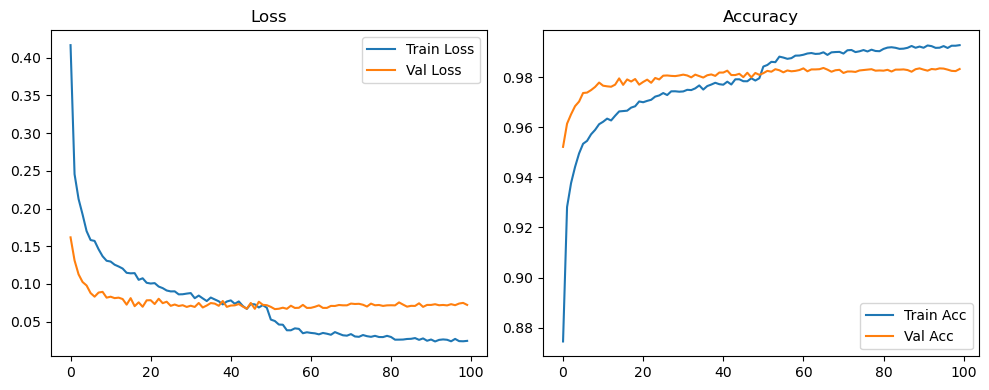

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2090, Acc: 0.9360 | Val Loss: 0.1307, Acc: 0.9624


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0968, Acc: 0.9695 | Val Loss: 0.1005, Acc: 0.9695


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9776 | Val Loss: 0.0862, Acc: 0.9728


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9814 | Val Loss: 0.0837, Acc: 0.9757


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.0980, Acc: 0.9732


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9881 | Val Loss: 0.0814, Acc: 0.9775


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.0928, Acc: 0.9745


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.0762, Acc: 0.9803


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.0899, Acc: 0.9758


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.0929, Acc: 0.9758


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0838, Acc: 0.9782


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0834, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0853, Acc: 0.9799


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0988, Acc: 0.9773


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.0825, Acc: 0.9803


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0806, Acc: 0.9798


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0884, Acc: 0.9800


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0959, Acc: 0.9788


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0991, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0900, Acc: 0.9786


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0803, Acc: 0.9822


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0853, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0887, Acc: 0.9813


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0929, Acc: 0.9786


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0949, Acc: 0.9801


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0868, Acc: 0.9805


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0835, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0841, Acc: 0.9820


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0878, Acc: 0.9832


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0928, Acc: 0.9811


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0883, Acc: 0.9816


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0977, Acc: 0.9795


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0935, Acc: 0.9802


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0920, Acc: 0.9804


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0907, Acc: 0.9819


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0966, Acc: 0.9797


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0862, Acc: 0.9822


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1088, Acc: 0.9802


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0971, Acc: 0.9800


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1121, Acc: 0.9778


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1036, Acc: 0.9797


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1024, Acc: 0.9800


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1023, Acc: 0.9818


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0921, Acc: 0.9817


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1018, Acc: 0.9806


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1037, Acc: 0.9809


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0926, Acc: 0.9835


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1082, Acc: 0.9809


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1078, Acc: 0.9820


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1101, Acc: 0.9803


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1143, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0952, Acc: 0.9823


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1087, Acc: 0.9810


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1118, Acc: 0.9803


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1104, Acc: 0.9824


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0988, Acc: 0.9827


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1010, Acc: 0.9824


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1064, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1049, Acc: 0.9826


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0940, Acc: 0.9840


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0983, Acc: 0.9832


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0998, Acc: 0.9835


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1418, Acc: 0.9791


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1082, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1116, Acc: 0.9806


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1077, Acc: 0.9817


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1057, Acc: 0.9820


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1019, Acc: 0.9837


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1021, Acc: 0.9832


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1137, Acc: 0.9820


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0929, Acc: 0.9834


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1104, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1027, Acc: 0.9830


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1009, Acc: 0.9818


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0978, Acc: 0.9826


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1034, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0984, Acc: 0.9825


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1024, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1023, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1052, Acc: 0.9822


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1007, Acc: 0.9827


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1060, Acc: 0.9808


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1021, Acc: 0.9826


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1049, Acc: 0.9834


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1021, Acc: 0.9830


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1210, Acc: 0.9815


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1095, Acc: 0.9815


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1021, Acc: 0.9823


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1059, Acc: 0.9828


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1018, Acc: 0.9818


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0962, Acc: 0.9842


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1023, Acc: 0.9830


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1015, Acc: 0.9827


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1118, Acc: 0.9826


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1194, Acc: 0.9798


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1076, Acc: 0.9829


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1115, Acc: 0.9818


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1017, Acc: 0.9843


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1451, Acc: 0.9781


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1038, Acc: 0.9829


Final Test Loss: 0.1090 Accuracy: 0.9849


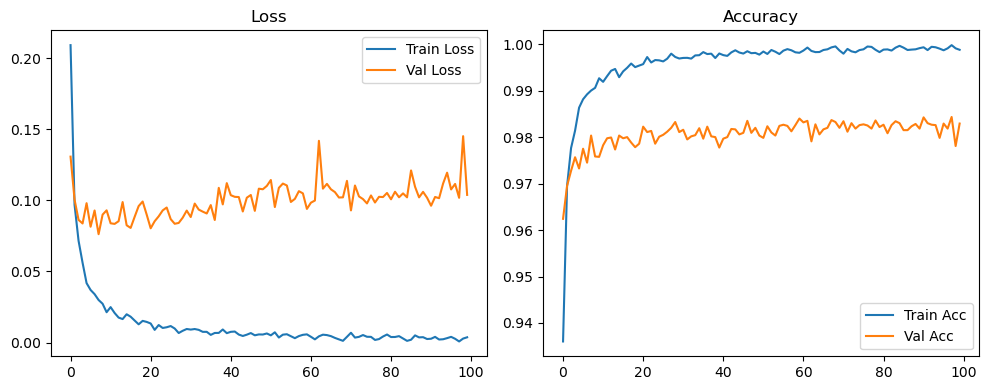

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2592, Acc: 0.9205 | Val Loss: 0.1279, Acc: 0.9615


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1357, Acc: 0.9586 | Val Loss: 0.1064, Acc: 0.9675


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1073, Acc: 0.9679 | Val Loss: 0.0877, Acc: 0.9730


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0859, Acc: 0.9737 | Val Loss: 0.0823, Acc: 0.9738


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0747, Acc: 0.9764 | Val Loss: 0.0819, Acc: 0.9755


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9778 | Val Loss: 0.0721, Acc: 0.9783


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9791 | Val Loss: 0.0690, Acc: 0.9798


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9818 | Val Loss: 0.0719, Acc: 0.9787


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9838 | Val Loss: 0.0722, Acc: 0.9792


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 0.0763, Acc: 0.9793


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9860 | Val Loss: 0.0683, Acc: 0.9808


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.0731, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0672, Acc: 0.9815


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9879 | Val Loss: 0.0745, Acc: 0.9799


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9881 | Val Loss: 0.0687, Acc: 0.9826


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9890 | Val Loss: 0.0708, Acc: 0.9820


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.0706, Acc: 0.9821


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.0812, Acc: 0.9792


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.0767, Acc: 0.9798


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0807, Acc: 0.9797


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0733, Acc: 0.9810


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.0727, Acc: 0.9810


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.0757, Acc: 0.9818


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0740, Acc: 0.9817


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0729, Acc: 0.9814


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0780, Acc: 0.9821


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.0733, Acc: 0.9808


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0800, Acc: 0.9805


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0817, Acc: 0.9818


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0790, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0665, Acc: 0.9822


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0834, Acc: 0.9800


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0785, Acc: 0.9816


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0754, Acc: 0.9826


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0851, Acc: 0.9808


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0787, Acc: 0.9823


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0744, Acc: 0.9834


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0888, Acc: 0.9802


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0754, Acc: 0.9819


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0773, Acc: 0.9834


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0838, Acc: 0.9819


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0827, Acc: 0.9837


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0788, Acc: 0.9816


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0776, Acc: 0.9830


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0863, Acc: 0.9831


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.0861, Acc: 0.9821


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.0778, Acc: 0.9833


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0843, Acc: 0.9821


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0766, Acc: 0.9838


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.0885, Acc: 0.9832


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0801, Acc: 0.9832


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0837, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0749, Acc: 0.9831


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0893, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0829, Acc: 0.9823


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0900, Acc: 0.9809


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0834, Acc: 0.9819


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0810, Acc: 0.9823


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0845, Acc: 0.9823


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0834, Acc: 0.9832


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0881, Acc: 0.9830


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0866, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0924, Acc: 0.9821


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0893, Acc: 0.9811


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0806, Acc: 0.9831


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.0894, Acc: 0.9812


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0848, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0873, Acc: 0.9835


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0867, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0836, Acc: 0.9836


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0899, Acc: 0.9830


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0876, Acc: 0.9826


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0864, Acc: 0.9828


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0819, Acc: 0.9817


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0807, Acc: 0.9836


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0899, Acc: 0.9831


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0827, Acc: 0.9831


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0828, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0836, Acc: 0.9837


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0889, Acc: 0.9834


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0929, Acc: 0.9824


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0867, Acc: 0.9829


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0844, Acc: 0.9832


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0926, Acc: 0.9827


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0916, Acc: 0.9825


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0967, Acc: 0.9822


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0905, Acc: 0.9825


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0884, Acc: 0.9831


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0787, Acc: 0.9838


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0847, Acc: 0.9842


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0814, Acc: 0.9846


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0878, Acc: 0.9850


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0889, Acc: 0.9824


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0853, Acc: 0.9841


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0838, Acc: 0.9831


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0794, Acc: 0.9834


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0957, Acc: 0.9816


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0953, Acc: 0.9830


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.0956, Acc: 0.9815


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0952, Acc: 0.9818


Final Test Loss: 0.0758 Accuracy: 0.9832


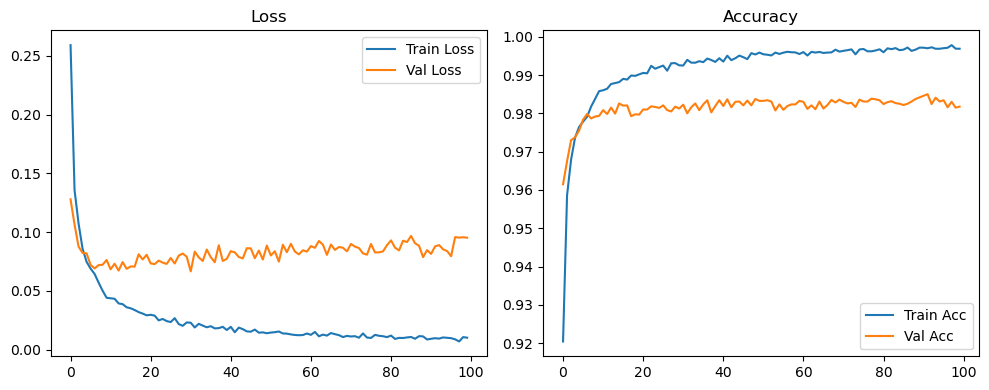

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4056, Acc: 0.8762 | Val Loss: 0.1598, Acc: 0.9529


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2411, Acc: 0.9286 | Val Loss: 0.1236, Acc: 0.9635


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2026, Acc: 0.9398 | Val Loss: 0.1058, Acc: 0.9670


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1761, Acc: 0.9482 | Val Loss: 0.0993, Acc: 0.9701


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1604, Acc: 0.9514 | Val Loss: 0.0958, Acc: 0.9702


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1486, Acc: 0.9565 | Val Loss: 0.0904, Acc: 0.9735


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1399, Acc: 0.9587 | Val Loss: 0.0871, Acc: 0.9741


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1366, Acc: 0.9593 | Val Loss: 0.0859, Acc: 0.9744


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9608 | Val Loss: 0.0871, Acc: 0.9738


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1199, Acc: 0.9641 | Val Loss: 0.0793, Acc: 0.9759


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1162, Acc: 0.9653 | Val Loss: 0.0789, Acc: 0.9779


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1142, Acc: 0.9651 | Val Loss: 0.0763, Acc: 0.9788


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1087, Acc: 0.9674 | Val Loss: 0.0803, Acc: 0.9775


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1089, Acc: 0.9671 | Val Loss: 0.0764, Acc: 0.9771


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1031, Acc: 0.9690 | Val Loss: 0.0729, Acc: 0.9783


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1008, Acc: 0.9704 | Val Loss: 0.0714, Acc: 0.9790


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9711 | Val Loss: 0.0714, Acc: 0.9792


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9714 | Val Loss: 0.0727, Acc: 0.9792


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0968, Acc: 0.9719 | Val Loss: 0.0743, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9727 | Val Loss: 0.0712, Acc: 0.9798


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9734 | Val Loss: 0.0751, Acc: 0.9798


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9724 | Val Loss: 0.0719, Acc: 0.9786


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9737 | Val Loss: 0.0702, Acc: 0.9800


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9749 | Val Loss: 0.0708, Acc: 0.9799


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9757 | Val Loss: 0.0698, Acc: 0.9805


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9746 | Val Loss: 0.0676, Acc: 0.9812


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9757 | Val Loss: 0.0688, Acc: 0.9802


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9769 | Val Loss: 0.0709, Acc: 0.9808


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9769 | Val Loss: 0.0712, Acc: 0.9802


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9776 | Val Loss: 0.0715, Acc: 0.9808


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0740, Acc: 0.9777 | Val Loss: 0.0715, Acc: 0.9802


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9781 | Val Loss: 0.0699, Acc: 0.9803


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9778 | Val Loss: 0.0727, Acc: 0.9810


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9778 | Val Loss: 0.0702, Acc: 0.9812


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9796 | Val Loss: 0.0706, Acc: 0.9808


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.0672, Acc: 0.9819


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0654, Acc: 0.9799 | Val Loss: 0.0740, Acc: 0.9809


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9795 | Val Loss: 0.0730, Acc: 0.9804


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9801 | Val Loss: 0.0739, Acc: 0.9802


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9800 | Val Loss: 0.0757, Acc: 0.9798


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9799 | Val Loss: 0.0689, Acc: 0.9815


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9802 | Val Loss: 0.0751, Acc: 0.9800


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9810 | Val Loss: 0.0718, Acc: 0.9802


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9809 | Val Loss: 0.0731, Acc: 0.9806


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9817 | Val Loss: 0.0712, Acc: 0.9812


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9803 | Val Loss: 0.0748, Acc: 0.9792


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9818 | Val Loss: 0.0681, Acc: 0.9811


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9823 | Val Loss: 0.0728, Acc: 0.9818


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9823 | Val Loss: 0.0730, Acc: 0.9810


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9812 | Val Loss: 0.0724, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9825 | Val Loss: 0.0699, Acc: 0.9821


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9828 | Val Loss: 0.0699, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9817 | Val Loss: 0.0672, Acc: 0.9812


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9829 | Val Loss: 0.0744, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9826 | Val Loss: 0.0690, Acc: 0.9817


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9834 | Val Loss: 0.0715, Acc: 0.9812


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9833 | Val Loss: 0.0716, Acc: 0.9811


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9840 | Val Loss: 0.0735, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9830 | Val Loss: 0.0735, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9829 | Val Loss: 0.0708, Acc: 0.9815


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9842 | Val Loss: 0.0781, Acc: 0.9815


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9838 | Val Loss: 0.0768, Acc: 0.9806


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9838 | Val Loss: 0.0763, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9849 | Val Loss: 0.0711, Acc: 0.9818


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9845 | Val Loss: 0.0726, Acc: 0.9822


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9839 | Val Loss: 0.0727, Acc: 0.9811


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9838 | Val Loss: 0.0718, Acc: 0.9818


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9854 | Val Loss: 0.0760, Acc: 0.9807


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 0.0768, Acc: 0.9815


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0750, Acc: 0.9807


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9850 | Val Loss: 0.0736, Acc: 0.9823


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9847 | Val Loss: 0.0752, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9855 | Val Loss: 0.0790, Acc: 0.9805


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 0.0754, Acc: 0.9809


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9862 | Val Loss: 0.0721, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.0780, Acc: 0.9800


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9857 | Val Loss: 0.0748, Acc: 0.9809


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9864 | Val Loss: 0.0810, Acc: 0.9804


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9852 | Val Loss: 0.0742, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9860 | Val Loss: 0.0738, Acc: 0.9802


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9864 | Val Loss: 0.0794, Acc: 0.9799


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0788, Acc: 0.9795


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9858 | Val Loss: 0.0760, Acc: 0.9796


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9860 | Val Loss: 0.0762, Acc: 0.9809


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9864 | Val Loss: 0.0724, Acc: 0.9816


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 0.0783, Acc: 0.9818


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9862 | Val Loss: 0.0766, Acc: 0.9809


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9866 | Val Loss: 0.0767, Acc: 0.9817


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9860 | Val Loss: 0.0773, Acc: 0.9801


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.0784, Acc: 0.9814


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 0.0766, Acc: 0.9816


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9875 | Val Loss: 0.0797, Acc: 0.9805


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9866 | Val Loss: 0.0752, Acc: 0.9808


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9868 | Val Loss: 0.0779, Acc: 0.9808


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.0820, Acc: 0.9806


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9875 | Val Loss: 0.0797, Acc: 0.9808


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9875 | Val Loss: 0.0790, Acc: 0.9822


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.0809, Acc: 0.9808


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9868 | Val Loss: 0.0826, Acc: 0.9807


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9875 | Val Loss: 0.0827, Acc: 0.9814


Final Test Loss: 0.0745 Accuracy: 0.9838


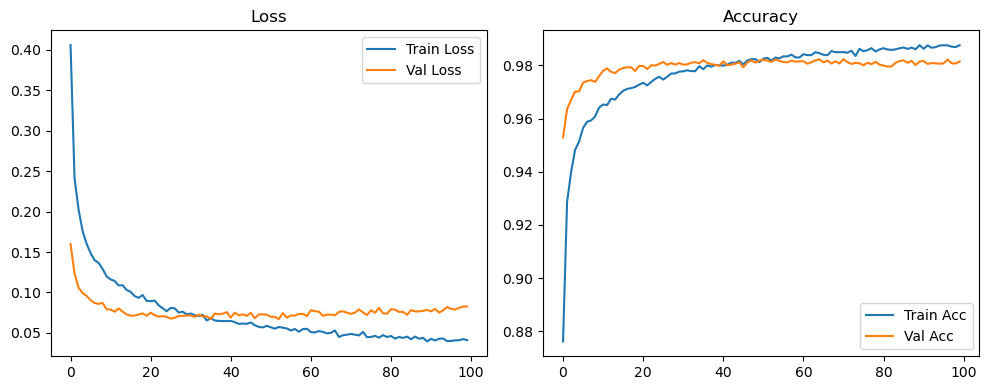

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2090, Acc: 0.9360 | Val Loss: 0.1307, Acc: 0.9624


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0968, Acc: 0.9695 | Val Loss: 0.1005, Acc: 0.9695


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9776 | Val Loss: 0.0862, Acc: 0.9728


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9814 | Val Loss: 0.0837, Acc: 0.9757


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.0980, Acc: 0.9732


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9881 | Val Loss: 0.0814, Acc: 0.9775


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.0928, Acc: 0.9745


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.0762, Acc: 0.9803


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.0899, Acc: 0.9758


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.0929, Acc: 0.9758


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0838, Acc: 0.9782


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0834, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0853, Acc: 0.9799


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0988, Acc: 0.9773


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.0825, Acc: 0.9803


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0806, Acc: 0.9798


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0884, Acc: 0.9800


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0959, Acc: 0.9788


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0991, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0900, Acc: 0.9786


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0803, Acc: 0.9822


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0853, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0887, Acc: 0.9813


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0929, Acc: 0.9786


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0949, Acc: 0.9801


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0868, Acc: 0.9805


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0835, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0841, Acc: 0.9820


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0878, Acc: 0.9832


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0928, Acc: 0.9811


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0883, Acc: 0.9816


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0977, Acc: 0.9795


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0935, Acc: 0.9802


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0920, Acc: 0.9804


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0907, Acc: 0.9819


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0966, Acc: 0.9797


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0862, Acc: 0.9822


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1088, Acc: 0.9802


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0971, Acc: 0.9800


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1121, Acc: 0.9778


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1036, Acc: 0.9797


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1024, Acc: 0.9800


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1023, Acc: 0.9818


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0921, Acc: 0.9817


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1018, Acc: 0.9806


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1037, Acc: 0.9809


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0926, Acc: 0.9835


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1082, Acc: 0.9809


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1078, Acc: 0.9820


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1101, Acc: 0.9803


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1023, Acc: 0.9822


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0957, Acc: 0.9828


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0964, Acc: 0.9826


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1002, Acc: 0.9827


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0996, Acc: 0.9832


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1026, Acc: 0.9824


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1024, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1077, Acc: 0.9831


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1101, Acc: 0.9823


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1185, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1086, Acc: 0.9828


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1078, Acc: 0.9832


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1107, Acc: 0.9832


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1089, Acc: 0.9834


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1119, Acc: 0.9836


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1113, Acc: 0.9832


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1175, Acc: 0.9830


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1183, Acc: 0.9831


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1101, Acc: 0.9836


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1164, Acc: 0.9835


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1122, Acc: 0.9844


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1291, Acc: 0.9827


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1206, Acc: 0.9826


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1337, Acc: 0.9817


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1227, Acc: 0.9826


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1275, Acc: 0.9815


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1339, Acc: 0.9815


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1229, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1181, Acc: 0.9839


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1179, Acc: 0.9828


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1155, Acc: 0.9836


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1147, Acc: 0.9829


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1184, Acc: 0.9833


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1128, Acc: 0.9837


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1130, Acc: 0.9834


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1173, Acc: 0.9833


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1157, Acc: 0.9838


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1164, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1207, Acc: 0.9832


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1206, Acc: 0.9837


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1153, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1178, Acc: 0.9840


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1161, Acc: 0.9841


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1261, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1248, Acc: 0.9836


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1243, Acc: 0.9838


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1246, Acc: 0.9841


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1278, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1382, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1271, Acc: 0.9834


Final Test Loss: 0.1131 Accuracy: 0.9847


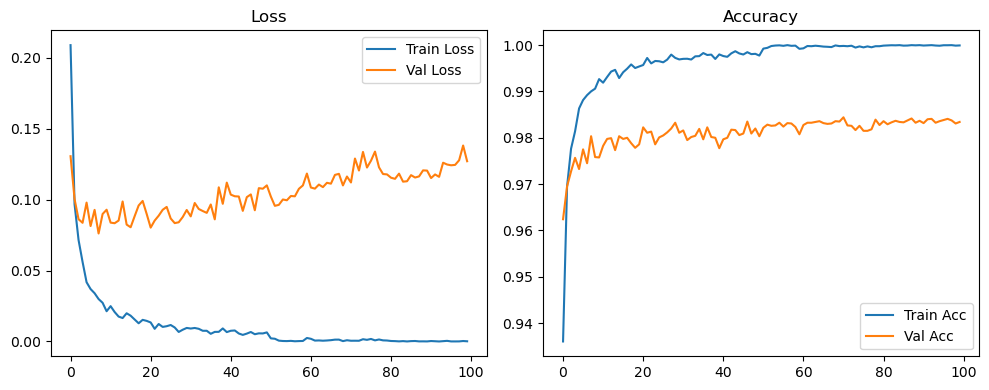

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2592, Acc: 0.9205 | Val Loss: 0.1279, Acc: 0.9615


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1357, Acc: 0.9586 | Val Loss: 0.1064, Acc: 0.9675


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1073, Acc: 0.9679 | Val Loss: 0.0877, Acc: 0.9730


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0859, Acc: 0.9737 | Val Loss: 0.0823, Acc: 0.9738


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0747, Acc: 0.9764 | Val Loss: 0.0819, Acc: 0.9755


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9778 | Val Loss: 0.0721, Acc: 0.9783


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9791 | Val Loss: 0.0690, Acc: 0.9798


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9818 | Val Loss: 0.0719, Acc: 0.9787


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9838 | Val Loss: 0.0722, Acc: 0.9792


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 0.0763, Acc: 0.9793


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9860 | Val Loss: 0.0683, Acc: 0.9808


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.0731, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0672, Acc: 0.9815


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9879 | Val Loss: 0.0745, Acc: 0.9799


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9881 | Val Loss: 0.0687, Acc: 0.9826


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9890 | Val Loss: 0.0708, Acc: 0.9820


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.0706, Acc: 0.9821


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.0812, Acc: 0.9792


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.0767, Acc: 0.9798


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0807, Acc: 0.9797


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0733, Acc: 0.9810


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.0727, Acc: 0.9810


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.0757, Acc: 0.9818


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0740, Acc: 0.9817


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0729, Acc: 0.9814


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0780, Acc: 0.9821


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.0733, Acc: 0.9808


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0800, Acc: 0.9805


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0817, Acc: 0.9818


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0790, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0665, Acc: 0.9822


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0834, Acc: 0.9800


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0785, Acc: 0.9816


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0754, Acc: 0.9826


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0851, Acc: 0.9808


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0787, Acc: 0.9823


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0744, Acc: 0.9834


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0888, Acc: 0.9802


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0754, Acc: 0.9819


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0773, Acc: 0.9834


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0838, Acc: 0.9819


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0827, Acc: 0.9837


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0788, Acc: 0.9816


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0776, Acc: 0.9830


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0863, Acc: 0.9831


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.0861, Acc: 0.9821


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.0778, Acc: 0.9833


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0843, Acc: 0.9821


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0766, Acc: 0.9838


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.0885, Acc: 0.9832


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0749, Acc: 0.9852


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0803, Acc: 0.9852


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0766, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0807, Acc: 0.9841


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0832, Acc: 0.9842


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0919, Acc: 0.9826


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0852, Acc: 0.9842


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0868, Acc: 0.9835


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0865, Acc: 0.9845


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0864, Acc: 0.9833


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0945, Acc: 0.9838


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0915, Acc: 0.9842


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0928, Acc: 0.9845


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0958, Acc: 0.9828


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0931, Acc: 0.9837


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0882, Acc: 0.9847


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0810, Acc: 0.9847


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0847, Acc: 0.9847


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0865, Acc: 0.9838


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0893, Acc: 0.9842


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0946, Acc: 0.9843


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0936, Acc: 0.9842


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0907, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0903, Acc: 0.9843


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0879, Acc: 0.9843


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0879, Acc: 0.9843


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0867, Acc: 0.9848


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9840


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0888, Acc: 0.9848


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0902, Acc: 0.9831


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0869, Acc: 0.9846


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0858, Acc: 0.9851


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0881, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0818, Acc: 0.9856


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0829, Acc: 0.9851


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0845, Acc: 0.9853


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0861, Acc: 0.9853


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0891, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0891, Acc: 0.9843


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0923, Acc: 0.9846


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0901, Acc: 0.9851


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0890, Acc: 0.9857


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0905, Acc: 0.9856


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0910, Acc: 0.9850


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0929, Acc: 0.9845


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0913, Acc: 0.9856


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0936, Acc: 0.9842


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0920, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0953, Acc: 0.9846


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0923, Acc: 0.9850


Final Test Loss: 0.0812 Accuracy: 0.9849


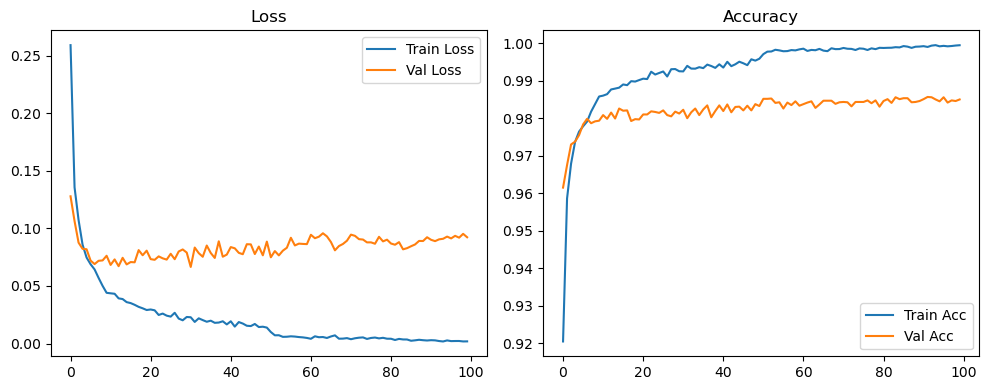

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4056, Acc: 0.8762 | Val Loss: 0.1598, Acc: 0.9529


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2411, Acc: 0.9286 | Val Loss: 0.1236, Acc: 0.9635


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2026, Acc: 0.9398 | Val Loss: 0.1058, Acc: 0.9670


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1761, Acc: 0.9482 | Val Loss: 0.0993, Acc: 0.9701


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1604, Acc: 0.9514 | Val Loss: 0.0958, Acc: 0.9702


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1486, Acc: 0.9565 | Val Loss: 0.0904, Acc: 0.9735


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1399, Acc: 0.9587 | Val Loss: 0.0871, Acc: 0.9741


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1366, Acc: 0.9593 | Val Loss: 0.0859, Acc: 0.9744


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9608 | Val Loss: 0.0871, Acc: 0.9738


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1199, Acc: 0.9641 | Val Loss: 0.0793, Acc: 0.9759


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1162, Acc: 0.9653 | Val Loss: 0.0789, Acc: 0.9779


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1142, Acc: 0.9651 | Val Loss: 0.0763, Acc: 0.9788


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1087, Acc: 0.9674 | Val Loss: 0.0803, Acc: 0.9775


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1089, Acc: 0.9671 | Val Loss: 0.0764, Acc: 0.9771


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1031, Acc: 0.9690 | Val Loss: 0.0729, Acc: 0.9783


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1008, Acc: 0.9704 | Val Loss: 0.0714, Acc: 0.9790


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9711 | Val Loss: 0.0714, Acc: 0.9792


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9714 | Val Loss: 0.0727, Acc: 0.9792


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0968, Acc: 0.9719 | Val Loss: 0.0743, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9727 | Val Loss: 0.0712, Acc: 0.9798


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9734 | Val Loss: 0.0751, Acc: 0.9798


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9724 | Val Loss: 0.0719, Acc: 0.9786


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9737 | Val Loss: 0.0702, Acc: 0.9800


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9749 | Val Loss: 0.0708, Acc: 0.9799


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9757 | Val Loss: 0.0698, Acc: 0.9805


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9746 | Val Loss: 0.0676, Acc: 0.9812


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9757 | Val Loss: 0.0688, Acc: 0.9802


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9769 | Val Loss: 0.0709, Acc: 0.9808


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9769 | Val Loss: 0.0712, Acc: 0.9802


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9776 | Val Loss: 0.0715, Acc: 0.9808


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0740, Acc: 0.9777 | Val Loss: 0.0715, Acc: 0.9802


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9781 | Val Loss: 0.0699, Acc: 0.9803


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9778 | Val Loss: 0.0727, Acc: 0.9810


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9778 | Val Loss: 0.0702, Acc: 0.9812


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9796 | Val Loss: 0.0706, Acc: 0.9808


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.0672, Acc: 0.9819


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0654, Acc: 0.9799 | Val Loss: 0.0740, Acc: 0.9809


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9795 | Val Loss: 0.0730, Acc: 0.9804


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9801 | Val Loss: 0.0739, Acc: 0.9802


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9800 | Val Loss: 0.0757, Acc: 0.9798


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9799 | Val Loss: 0.0689, Acc: 0.9815


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9802 | Val Loss: 0.0751, Acc: 0.9800


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9810 | Val Loss: 0.0718, Acc: 0.9802


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9809 | Val Loss: 0.0731, Acc: 0.9806


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9817 | Val Loss: 0.0712, Acc: 0.9812


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9803 | Val Loss: 0.0748, Acc: 0.9792


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9818 | Val Loss: 0.0681, Acc: 0.9811


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9823 | Val Loss: 0.0728, Acc: 0.9818


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9823 | Val Loss: 0.0730, Acc: 0.9810


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9812 | Val Loss: 0.0724, Acc: 0.9818


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.0673, Acc: 0.9826


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.0686, Acc: 0.9836


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9874 | Val Loss: 0.0667, Acc: 0.9831


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9875 | Val Loss: 0.0709, Acc: 0.9823


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9878 | Val Loss: 0.0695, Acc: 0.9827


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9883 | Val Loss: 0.0724, Acc: 0.9824


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9879 | Val Loss: 0.0703, Acc: 0.9820


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9893 | Val Loss: 0.0720, Acc: 0.9827


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9883 | Val Loss: 0.0743, Acc: 0.9817


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9888 | Val Loss: 0.0732, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9896 | Val Loss: 0.0762, Acc: 0.9820


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0755, Acc: 0.9820


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9895 | Val Loss: 0.0747, Acc: 0.9826


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9895 | Val Loss: 0.0746, Acc: 0.9823


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0753, Acc: 0.9825


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0747, Acc: 0.9824


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0739, Acc: 0.9828


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.0800, Acc: 0.9824


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.0786, Acc: 0.9817


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9897 | Val Loss: 0.0755, Acc: 0.9820


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0788, Acc: 0.9818


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9903 | Val Loss: 0.0746, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0782, Acc: 0.9808


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.0779, Acc: 0.9818


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0748, Acc: 0.9827


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0765, Acc: 0.9823


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9914 | Val Loss: 0.0787, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0785, Acc: 0.9822


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0772, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9903 | Val Loss: 0.0755, Acc: 0.9820


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0771, Acc: 0.9824


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9914 | Val Loss: 0.0787, Acc: 0.9823


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0780, Acc: 0.9825


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9920 | Val Loss: 0.0772, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0769, Acc: 0.9823


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.0799, Acc: 0.9826


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0778, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9927 | Val Loss: 0.0779, Acc: 0.9827


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0793, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0792, Acc: 0.9827


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0802, Acc: 0.9821


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9932 | Val Loss: 0.0783, Acc: 0.9823


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.0779, Acc: 0.9819


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9924 | Val Loss: 0.0753, Acc: 0.9821


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0782, Acc: 0.9821


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0784, Acc: 0.9825


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0805, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0797, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9930 | Val Loss: 0.0800, Acc: 0.9823


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9937 | Val Loss: 0.0800, Acc: 0.9822


Final Test Loss: 0.0710 Accuracy: 0.9852


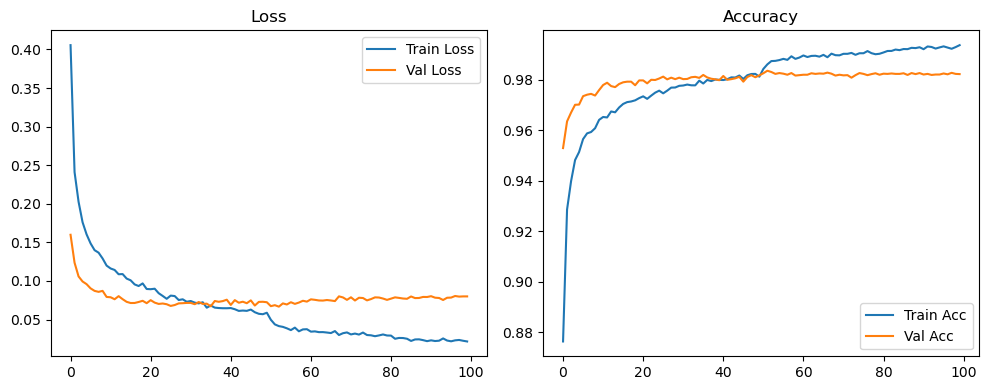

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1992, Acc: 0.9400 | Val Loss: 0.1200, Acc: 0.9628


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0876, Acc: 0.9726 | Val Loss: 0.0925, Acc: 0.9712


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0611, Acc: 0.9809 | Val Loss: 0.0821, Acc: 0.9748


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 0.0813, Acc: 0.9742


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9891 | Val Loss: 0.0919, Acc: 0.9714


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.0756, Acc: 0.9786


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0841, Acc: 0.9769


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.0969, Acc: 0.9742


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0847, Acc: 0.9777


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0824, Acc: 0.9789


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9925 | Val Loss: 0.0853, Acc: 0.9786


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0738, Acc: 0.9802


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0797, Acc: 0.9791


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0986, Acc: 0.9770


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9944 | Val Loss: 0.0915, Acc: 0.9782


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.0789, Acc: 0.9794


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0934, Acc: 0.9786


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0919, Acc: 0.9788


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0829, Acc: 0.9790


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0819, Acc: 0.9811


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0906, Acc: 0.9795


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0892, Acc: 0.9811


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0787, Acc: 0.9822


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0965, Acc: 0.9794


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0886, Acc: 0.9812


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0870, Acc: 0.9813


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0976, Acc: 0.9786


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0917, Acc: 0.9822


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0920, Acc: 0.9822


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0960, Acc: 0.9810


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0936, Acc: 0.9805


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0940, Acc: 0.9812


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0885, Acc: 0.9829


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0970, Acc: 0.9822


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0886, Acc: 0.9826


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0910, Acc: 0.9820


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0953, Acc: 0.9808


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1040, Acc: 0.9805


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1084, Acc: 0.9792


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0852, Acc: 0.9820


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0965, Acc: 0.9802


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0894, Acc: 0.9820


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1013, Acc: 0.9795


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0966, Acc: 0.9811


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0927, Acc: 0.9816


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1100, Acc: 0.9798


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0933, Acc: 0.9816


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0946, Acc: 0.9814


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1016, Acc: 0.9814


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1152, Acc: 0.9798


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1023, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1110, Acc: 0.9809


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0912, Acc: 0.9830


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0971, Acc: 0.9825


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1051, Acc: 0.9804


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1048, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1160, Acc: 0.9790


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1022, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0950, Acc: 0.9818


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0924, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0960, Acc: 0.9813


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0923, Acc: 0.9831


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1007, Acc: 0.9814


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1232, Acc: 0.9792


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1017, Acc: 0.9802


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1154, Acc: 0.9806


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1089, Acc: 0.9806


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0956, Acc: 0.9826


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1017, Acc: 0.9819


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.1064, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1024, Acc: 0.9812


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1102, Acc: 0.9807


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1073, Acc: 0.9808


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1092, Acc: 0.9813


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1172, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1029, Acc: 0.9825


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0991, Acc: 0.9819


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1075, Acc: 0.9816


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1001, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1099, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1111, Acc: 0.9791


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1052, Acc: 0.9825


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1040, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1003, Acc: 0.9831


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1107, Acc: 0.9812


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1147, Acc: 0.9824


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1139, Acc: 0.9811


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1050, Acc: 0.9821


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1038, Acc: 0.9824


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1015, Acc: 0.9827


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1104, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1173, Acc: 0.9818


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1201, Acc: 0.9803


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1152, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1071, Acc: 0.9830


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1056, Acc: 0.9832


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1103, Acc: 0.9817


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1043, Acc: 0.9824


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1174, Acc: 0.9811


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1074, Acc: 0.9822


Final Test Loss: 0.1048 Accuracy: 0.9837


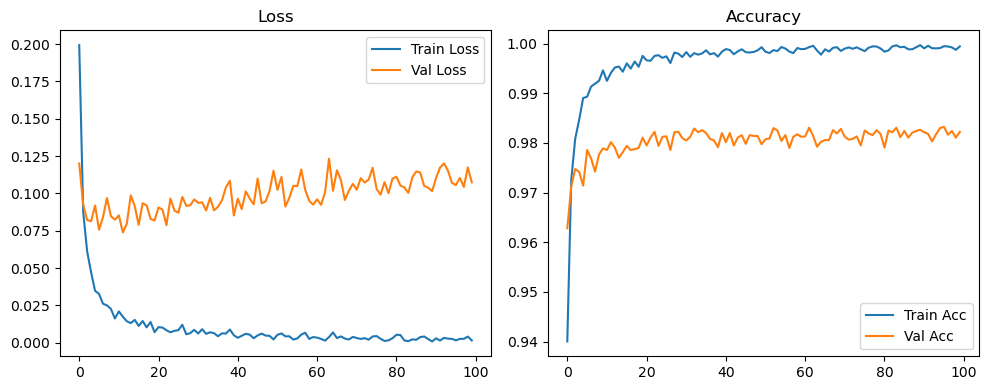

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2579, Acc: 0.9236 | Val Loss: 0.1204, Acc: 0.9629


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1331, Acc: 0.9591 | Val Loss: 0.0924, Acc: 0.9721


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1019, Acc: 0.9682 | Val Loss: 0.0852, Acc: 0.9732


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0827, Acc: 0.9738 | Val Loss: 0.0745, Acc: 0.9768


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9783 | Val Loss: 0.0717, Acc: 0.9777


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9786 | Val Loss: 0.0730, Acc: 0.9777


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9815 | Val Loss: 0.0721, Acc: 0.9788


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9822 | Val Loss: 0.0743, Acc: 0.9775


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.0673, Acc: 0.9802


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9867 | Val Loss: 0.0643, Acc: 0.9799


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.0675, Acc: 0.9801


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.0692, Acc: 0.9808


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.0682, Acc: 0.9801


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.0684, Acc: 0.9810


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.0697, Acc: 0.9805


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9890 | Val Loss: 0.0743, Acc: 0.9807


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.0711, Acc: 0.9808


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0697, Acc: 0.9815


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9902 | Val Loss: 0.0711, Acc: 0.9811


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9912 | Val Loss: 0.0754, Acc: 0.9811


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9913 | Val Loss: 0.0667, Acc: 0.9821


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0687, Acc: 0.9828


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0703, Acc: 0.9832


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.0739, Acc: 0.9817


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9926 | Val Loss: 0.0697, Acc: 0.9822


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0733, Acc: 0.9822


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0726, Acc: 0.9823


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0749, Acc: 0.9818


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0741, Acc: 0.9825


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0768, Acc: 0.9827


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0715, Acc: 0.9837


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0659, Acc: 0.9848


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.0692, Acc: 0.9841


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0777, Acc: 0.9830


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0778, Acc: 0.9816


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0693, Acc: 0.9832


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0752, Acc: 0.9828


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0791, Acc: 0.9816


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0748, Acc: 0.9833


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.0732, Acc: 0.9835


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.0737, Acc: 0.9826


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0726, Acc: 0.9839


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0705, Acc: 0.9844


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0755, Acc: 0.9847


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0746, Acc: 0.9842


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0786, Acc: 0.9832


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0774, Acc: 0.9839


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0755, Acc: 0.9838


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0865, Acc: 0.9832


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0813, Acc: 0.9831


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0803, Acc: 0.9825


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0753, Acc: 0.9839


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0727, Acc: 0.9848


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0811, Acc: 0.9821


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.0763, Acc: 0.9836


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0742, Acc: 0.9848


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0753, Acc: 0.9842


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0822, Acc: 0.9831


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0742, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0777, Acc: 0.9829


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0849, Acc: 0.9830


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9963 | Val Loss: 0.0767, Acc: 0.9837


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0727, Acc: 0.9861


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0767, Acc: 0.9837


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0786, Acc: 0.9840


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0765, Acc: 0.9840


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0771, Acc: 0.9832


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0823, Acc: 0.9832


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0782, Acc: 0.9844


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0789, Acc: 0.9848


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0769, Acc: 0.9850


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0827, Acc: 0.9823


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0776, Acc: 0.9852


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0845, Acc: 0.9830


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0761, Acc: 0.9847


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0727, Acc: 0.9847


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0808, Acc: 0.9839


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0836, Acc: 0.9831


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0798, Acc: 0.9841


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0772, Acc: 0.9841


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0731, Acc: 0.9847


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0771, Acc: 0.9839


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0791, Acc: 0.9840


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0754, Acc: 0.9839


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.0831, Acc: 0.9836


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0864, Acc: 0.9833


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0794, Acc: 0.9842


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0798, Acc: 0.9834


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0845, Acc: 0.9832


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0811, Acc: 0.9834


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0786, Acc: 0.9840


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0808, Acc: 0.9841


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0802, Acc: 0.9850


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0810, Acc: 0.9848


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0781, Acc: 0.9841


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0776, Acc: 0.9842


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0800, Acc: 0.9834


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0777, Acc: 0.9841


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0790, Acc: 0.9848


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0808, Acc: 0.9844


Final Test Loss: 0.0746 Accuracy: 0.9854


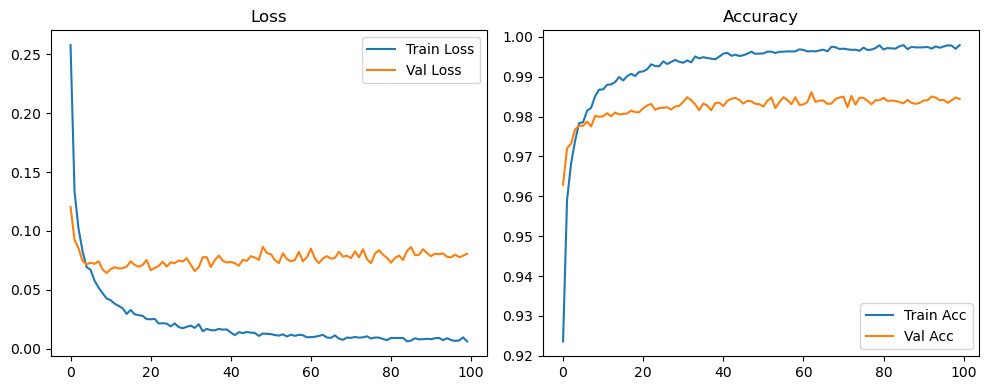

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4357, Acc: 0.8680 | Val Loss: 0.1640, Acc: 0.9502


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2411, Acc: 0.9281 | Val Loss: 0.1284, Acc: 0.9595


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2014, Acc: 0.9399 | Val Loss: 0.1136, Acc: 0.9643


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1767, Acc: 0.9482 | Val Loss: 0.1030, Acc: 0.9685


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1607, Acc: 0.9518 | Val Loss: 0.0940, Acc: 0.9712


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1441, Acc: 0.9569 | Val Loss: 0.0904, Acc: 0.9727


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1393, Acc: 0.9581 | Val Loss: 0.0871, Acc: 0.9726


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1324, Acc: 0.9603 | Val Loss: 0.0838, Acc: 0.9759


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1226, Acc: 0.9636 | Val Loss: 0.0859, Acc: 0.9748


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1134, Acc: 0.9658 | Val Loss: 0.0854, Acc: 0.9752


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1101, Acc: 0.9665 | Val Loss: 0.0779, Acc: 0.9768


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1095, Acc: 0.9665 | Val Loss: 0.0758, Acc: 0.9777


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0988, Acc: 0.9692 | Val Loss: 0.0780, Acc: 0.9772


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0992, Acc: 0.9706 | Val Loss: 0.0754, Acc: 0.9782


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0959, Acc: 0.9701 | Val Loss: 0.0738, Acc: 0.9782


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0925, Acc: 0.9715 | Val Loss: 0.0736, Acc: 0.9782


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0893, Acc: 0.9735 | Val Loss: 0.0709, Acc: 0.9792


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0893, Acc: 0.9728 | Val Loss: 0.0771, Acc: 0.9778


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0863, Acc: 0.9732 | Val Loss: 0.0708, Acc: 0.9798


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0857, Acc: 0.9736 | Val Loss: 0.0695, Acc: 0.9803


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0856, Acc: 0.9733 | Val Loss: 0.0708, Acc: 0.9806


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0780, Acc: 0.9759 | Val Loss: 0.0683, Acc: 0.9812


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0775, Acc: 0.9755 | Val Loss: 0.0696, Acc: 0.9806


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0766, Acc: 0.9758 | Val Loss: 0.0679, Acc: 0.9808


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9762 | Val Loss: 0.0672, Acc: 0.9813


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9786 | Val Loss: 0.0685, Acc: 0.9795


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9772 | Val Loss: 0.0654, Acc: 0.9798


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9800 | Val Loss: 0.0709, Acc: 0.9798


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 0.0675, Acc: 0.9802


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0688, Acc: 0.9785 | Val Loss: 0.0713, Acc: 0.9797


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9800 | Val Loss: 0.0694, Acc: 0.9815


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0661, Acc: 0.9793 | Val Loss: 0.0679, Acc: 0.9816


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9803 | Val Loss: 0.0674, Acc: 0.9818


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0644, Acc: 0.9788 | Val Loss: 0.0694, Acc: 0.9803


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9805 | Val Loss: 0.0685, Acc: 0.9807


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9790 | Val Loss: 0.0684, Acc: 0.9815


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0605, Acc: 0.9806 | Val Loss: 0.0691, Acc: 0.9816


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9819 | Val Loss: 0.0699, Acc: 0.9808


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9815 | Val Loss: 0.0713, Acc: 0.9808


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9815 | Val Loss: 0.0683, Acc: 0.9813


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9813 | Val Loss: 0.0697, Acc: 0.9812


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9823 | Val Loss: 0.0690, Acc: 0.9814


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9823 | Val Loss: 0.0704, Acc: 0.9821


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.0667, Acc: 0.9825


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9832 | Val Loss: 0.0684, Acc: 0.9818


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 0.0705, Acc: 0.9822


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0533, Acc: 0.9826 | Val Loss: 0.0683, Acc: 0.9811


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9848 | Val Loss: 0.0714, Acc: 0.9814


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9831 | Val Loss: 0.0682, Acc: 0.9827


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.0683, Acc: 0.9827


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9841 | Val Loss: 0.0719, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.0689, Acc: 0.9829


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.0655, Acc: 0.9831


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9840 | Val Loss: 0.0735, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9837 | Val Loss: 0.0710, Acc: 0.9822


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9845 | Val Loss: 0.0684, Acc: 0.9819


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9847 | Val Loss: 0.0706, Acc: 0.9818


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0746, Acc: 0.9807


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9858 | Val Loss: 0.0741, Acc: 0.9818


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9851 | Val Loss: 0.0703, Acc: 0.9813


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9859 | Val Loss: 0.0691, Acc: 0.9821


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9855 | Val Loss: 0.0675, Acc: 0.9822


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9862 | Val Loss: 0.0765, Acc: 0.9806


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9859 | Val Loss: 0.0763, Acc: 0.9815


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9857 | Val Loss: 0.0723, Acc: 0.9822


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9865 | Val Loss: 0.0739, Acc: 0.9805


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.0739, Acc: 0.9815


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0768, Acc: 0.9809


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9858 | Val Loss: 0.0722, Acc: 0.9814


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.0704, Acc: 0.9809


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9868 | Val Loss: 0.0729, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9865 | Val Loss: 0.0727, Acc: 0.9821


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0729, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 0.0708, Acc: 0.9811


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 0.0694, Acc: 0.9813


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 0.0663, Acc: 0.9831


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.0696, Acc: 0.9821


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 0.0737, Acc: 0.9815


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 0.0712, Acc: 0.9825


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0713, Acc: 0.9814


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.0755, Acc: 0.9818


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.0711, Acc: 0.9822


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.0716, Acc: 0.9816


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0741, Acc: 0.9815


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.0715, Acc: 0.9819


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9880 | Val Loss: 0.0713, Acc: 0.9823


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.0729, Acc: 0.9820


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0715, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.0686, Acc: 0.9822


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0709, Acc: 0.9828


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.0722, Acc: 0.9826


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.0742, Acc: 0.9822


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.0700, Acc: 0.9822


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0723, Acc: 0.9816


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.0778, Acc: 0.9806


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.0770, Acc: 0.9811


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9883 | Val Loss: 0.0712, Acc: 0.9813


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9888 | Val Loss: 0.0749, Acc: 0.9809


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.0768, Acc: 0.9811


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.0741, Acc: 0.9822


Final Test Loss: 0.0668 Accuracy: 0.9825


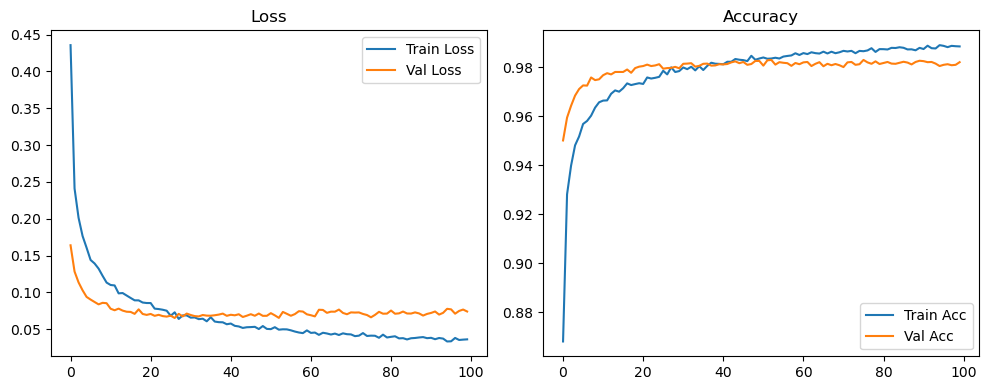

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2102, Acc: 0.9397 | Val Loss: 0.1094, Acc: 0.9679


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0825, Acc: 0.9742 | Val Loss: 0.0911, Acc: 0.9728


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0569, Acc: 0.9814 | Val Loss: 0.0841, Acc: 0.9753


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9861 | Val Loss: 0.0801, Acc: 0.9752


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.0757, Acc: 0.9778


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9923 | Val Loss: 0.0777, Acc: 0.9776


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0851, Acc: 0.9763


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0854, Acc: 0.9758


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0781, Acc: 0.9791


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9945 | Val Loss: 0.0728, Acc: 0.9799


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0775, Acc: 0.9798


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0829, Acc: 0.9788


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0756, Acc: 0.9810


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0934, Acc: 0.9762


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0820, Acc: 0.9795


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0874, Acc: 0.9796


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0805, Acc: 0.9790


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0806, Acc: 0.9801


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0835, Acc: 0.9804


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0933, Acc: 0.9782


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9961 | Val Loss: 0.0932, Acc: 0.9782


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0868, Acc: 0.9801


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0874, Acc: 0.9810


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0863, Acc: 0.9823


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0868, Acc: 0.9807


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0922, Acc: 0.9817


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0966, Acc: 0.9802


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0958, Acc: 0.9795


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0956, Acc: 0.9789


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1042, Acc: 0.9788


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.0959, Acc: 0.9789


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0797, Acc: 0.9832


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0938, Acc: 0.9805


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0941, Acc: 0.9806


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0926, Acc: 0.9818


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0922, Acc: 0.9815


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0889, Acc: 0.9813


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0959, Acc: 0.9798


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1007, Acc: 0.9806


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0977, Acc: 0.9800


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0892, Acc: 0.9812


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0864, Acc: 0.9814


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1051, Acc: 0.9773


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0827, Acc: 0.9832


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0847, Acc: 0.9832


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0889, Acc: 0.9811


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1030, Acc: 0.9797


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0974, Acc: 0.9799


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0968, Acc: 0.9804


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1001, Acc: 0.9813


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1005, Acc: 0.9808


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1032, Acc: 0.9820


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0881, Acc: 0.9838


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1069, Acc: 0.9798


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0928, Acc: 0.9821


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0884, Acc: 0.9823


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0902, Acc: 0.9831


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0961, Acc: 0.9815


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0998, Acc: 0.9817


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0961, Acc: 0.9823


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0997, Acc: 0.9802


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0970, Acc: 0.9821


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0957, Acc: 0.9824


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0913, Acc: 0.9826


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0926, Acc: 0.9828


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1045, Acc: 0.9809


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0971, Acc: 0.9815


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0925, Acc: 0.9832


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0949, Acc: 0.9830


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0907, Acc: 0.9820


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0949, Acc: 0.9822


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1081, Acc: 0.9808


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0883, Acc: 0.9838


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1046, Acc: 0.9808


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1008, Acc: 0.9818


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0986, Acc: 0.9828


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1054, Acc: 0.9816


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1028, Acc: 0.9822


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1018, Acc: 0.9815


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0978, Acc: 0.9824


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1044, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0916, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0991, Acc: 0.9830


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0969, Acc: 0.9827


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1058, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0894, Acc: 0.9831


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0983, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0975, Acc: 0.9830


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1037, Acc: 0.9819


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0923, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1116, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0980, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0997, Acc: 0.9832


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1092, Acc: 0.9817


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1028, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0928, Acc: 0.9843


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0958, Acc: 0.9840


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1003, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1112, Acc: 0.9814


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1065, Acc: 0.9826


Final Test Loss: 0.0943 Accuracy: 0.9831


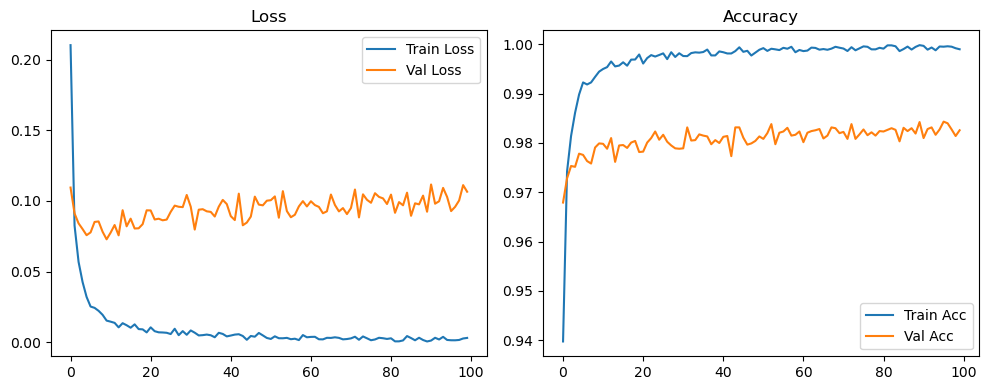

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2850, Acc: 0.9183 | Val Loss: 0.1230, Acc: 0.9626


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1306, Acc: 0.9602 | Val Loss: 0.0959, Acc: 0.9710


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1022, Acc: 0.9693 | Val Loss: 0.0857, Acc: 0.9733


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9736 | Val Loss: 0.0776, Acc: 0.9763


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0701, Acc: 0.9771 | Val Loss: 0.0737, Acc: 0.9768


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9796 | Val Loss: 0.0697, Acc: 0.9781


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.0717, Acc: 0.9793


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9826 | Val Loss: 0.0753, Acc: 0.9772


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9846 | Val Loss: 0.0687, Acc: 0.9804


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.0649, Acc: 0.9807


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 0.0648, Acc: 0.9809


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9875 | Val Loss: 0.0694, Acc: 0.9793


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0666, Acc: 0.9815


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9879 | Val Loss: 0.0726, Acc: 0.9798


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9895 | Val Loss: 0.0668, Acc: 0.9805


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.0700, Acc: 0.9818


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9899 | Val Loss: 0.0693, Acc: 0.9805


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0750, Acc: 0.9788


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0689, Acc: 0.9811


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.0739, Acc: 0.9800


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.0727, Acc: 0.9813


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0701, Acc: 0.9810


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9918 | Val Loss: 0.0701, Acc: 0.9812


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0723, Acc: 0.9818


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0785, Acc: 0.9806


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9926 | Val Loss: 0.0771, Acc: 0.9808


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0707, Acc: 0.9805


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0707, Acc: 0.9818


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0728, Acc: 0.9832


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9944 | Val Loss: 0.0730, Acc: 0.9828


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0659, Acc: 0.9834


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0678, Acc: 0.9820


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0686, Acc: 0.9827


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0700, Acc: 0.9832


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0679, Acc: 0.9816


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0671, Acc: 0.9831


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0724, Acc: 0.9829


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0745, Acc: 0.9827


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0673, Acc: 0.9834


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0672, Acc: 0.9843


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0741, Acc: 0.9824


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0707, Acc: 0.9825


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0695, Acc: 0.9827


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0683, Acc: 0.9830


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.0653, Acc: 0.9846


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0710, Acc: 0.9831


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0707, Acc: 0.9834


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0742, Acc: 0.9841


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0726, Acc: 0.9840


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0719, Acc: 0.9838


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0710, Acc: 0.9832


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0743, Acc: 0.9838


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0723, Acc: 0.9834


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0760, Acc: 0.9822


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0733, Acc: 0.9837


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0787, Acc: 0.9836


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0786, Acc: 0.9830


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0792, Acc: 0.9838


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0798, Acc: 0.9837


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0773, Acc: 0.9845


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0764, Acc: 0.9833


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0846, Acc: 0.9828


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0797, Acc: 0.9828


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0809, Acc: 0.9842


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0797, Acc: 0.9828


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0738, Acc: 0.9842


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0806, Acc: 0.9841


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0770, Acc: 0.9842


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0780, Acc: 0.9840


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0775, Acc: 0.9838


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0766, Acc: 0.9840


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0758, Acc: 0.9848


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0774, Acc: 0.9842


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0777, Acc: 0.9843


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0787, Acc: 0.9832


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0819, Acc: 0.9832


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0738, Acc: 0.9844


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0845, Acc: 0.9835


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0780, Acc: 0.9841


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0763, Acc: 0.9836


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0742, Acc: 0.9848


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0746, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0755, Acc: 0.9847


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0789, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0839, Acc: 0.9835


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0802, Acc: 0.9832


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0766, Acc: 0.9832


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0753, Acc: 0.9838


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0835, Acc: 0.9831


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0780, Acc: 0.9835


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0820, Acc: 0.9843


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0832, Acc: 0.9840


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0769, Acc: 0.9846


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0854, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0828, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0831, Acc: 0.9832


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0846, Acc: 0.9837


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0835, Acc: 0.9842


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0863, Acc: 0.9835


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0841, Acc: 0.9831


Final Test Loss: 0.0825 Accuracy: 0.9854


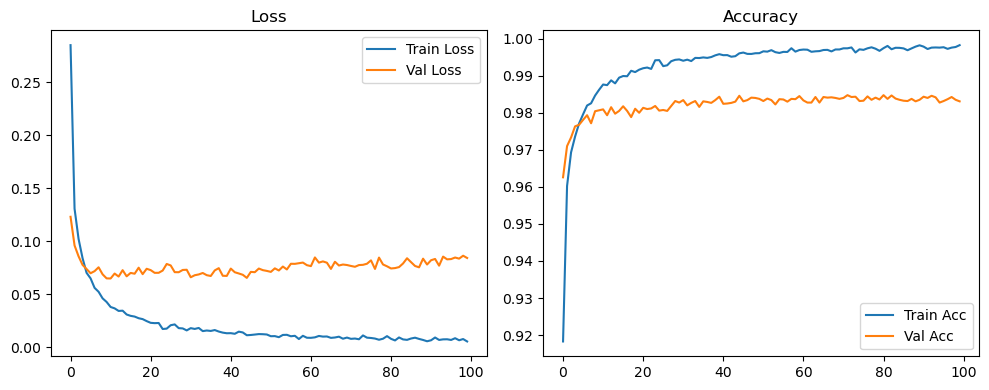

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5055, Acc: 0.8493 | Val Loss: 0.1796, Acc: 0.9447


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2531, Acc: 0.9254 | Val Loss: 0.1385, Acc: 0.9583


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2109, Acc: 0.9360 | Val Loss: 0.1178, Acc: 0.9637


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1855, Acc: 0.9453 | Val Loss: 0.1052, Acc: 0.9669


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1630, Acc: 0.9512 | Val Loss: 0.0974, Acc: 0.9695


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1490, Acc: 0.9543 | Val Loss: 0.0936, Acc: 0.9708


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1414, Acc: 0.9572 | Val Loss: 0.0896, Acc: 0.9720


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1338, Acc: 0.9592 | Val Loss: 0.0866, Acc: 0.9738


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1254, Acc: 0.9629 | Val Loss: 0.0824, Acc: 0.9752


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1173, Acc: 0.9647 | Val Loss: 0.0802, Acc: 0.9753


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1116, Acc: 0.9667 | Val Loss: 0.0776, Acc: 0.9766


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1102, Acc: 0.9659 | Val Loss: 0.0748, Acc: 0.9772


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1006, Acc: 0.9693 | Val Loss: 0.0765, Acc: 0.9768


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1047, Acc: 0.9678 | Val Loss: 0.0779, Acc: 0.9768


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0992, Acc: 0.9691 | Val Loss: 0.0745, Acc: 0.9781


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0938, Acc: 0.9720 | Val Loss: 0.0733, Acc: 0.9784


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0897, Acc: 0.9728 | Val Loss: 0.0729, Acc: 0.9780


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0890, Acc: 0.9721 | Val Loss: 0.0749, Acc: 0.9788


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0882, Acc: 0.9730 | Val Loss: 0.0685, Acc: 0.9788


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0811, Acc: 0.9747 | Val Loss: 0.0700, Acc: 0.9798


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0861, Acc: 0.9734 | Val Loss: 0.0705, Acc: 0.9798


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0801, Acc: 0.9748 | Val Loss: 0.0664, Acc: 0.9803


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0772, Acc: 0.9754 | Val Loss: 0.0726, Acc: 0.9787


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9770 | Val Loss: 0.0690, Acc: 0.9795


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0674, Acc: 0.9782 | Val Loss: 0.0697, Acc: 0.9798


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9800 | Val Loss: 0.0673, Acc: 0.9802


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9774 | Val Loss: 0.0686, Acc: 0.9812


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9780 | Val Loss: 0.0667, Acc: 0.9812


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0688, Acc: 0.9785 | Val Loss: 0.0679, Acc: 0.9820


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0657, Acc: 0.9788 | Val Loss: 0.0687, Acc: 0.9807


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0629, Acc: 0.9802 | Val Loss: 0.0671, Acc: 0.9806


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0651, Acc: 0.9793 | Val Loss: 0.0622, Acc: 0.9831


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9800 | Val Loss: 0.0690, Acc: 0.9817


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0614, Acc: 0.9800 | Val Loss: 0.0662, Acc: 0.9815


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0589, Acc: 0.9814 | Val Loss: 0.0642, Acc: 0.9816


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9810 | Val Loss: 0.0651, Acc: 0.9818


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0574, Acc: 0.9814 | Val Loss: 0.0679, Acc: 0.9811


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9812 | Val Loss: 0.0694, Acc: 0.9812


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9826 | Val Loss: 0.0681, Acc: 0.9817


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9825 | Val Loss: 0.0685, Acc: 0.9818


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9818 | Val Loss: 0.0667, Acc: 0.9815


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9824 | Val Loss: 0.0649, Acc: 0.9824


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9832 | Val Loss: 0.0708, Acc: 0.9811


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9824 | Val Loss: 0.0695, Acc: 0.9817


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9817 | Val Loss: 0.0698, Acc: 0.9817


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9834 | Val Loss: 0.0705, Acc: 0.9820


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9832 | Val Loss: 0.0714, Acc: 0.9810


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9835 | Val Loss: 0.0668, Acc: 0.9821


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9835 | Val Loss: 0.0699, Acc: 0.9815


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9849 | Val Loss: 0.0676, Acc: 0.9813


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 0.0677, Acc: 0.9813


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.0677, Acc: 0.9824


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9849 | Val Loss: 0.0640, Acc: 0.9823


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9842 | Val Loss: 0.0684, Acc: 0.9817


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9842 | Val Loss: 0.0667, Acc: 0.9820


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 0.0683, Acc: 0.9828


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.0721, Acc: 0.9818


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.0707, Acc: 0.9819


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9860 | Val Loss: 0.0714, Acc: 0.9828


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9849 | Val Loss: 0.0697, Acc: 0.9820


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9854 | Val Loss: 0.0724, Acc: 0.9812


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.0706, Acc: 0.9822


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9867 | Val Loss: 0.0684, Acc: 0.9826


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9857 | Val Loss: 0.0694, Acc: 0.9827


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.0731, Acc: 0.9809


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9867 | Val Loss: 0.0723, Acc: 0.9822


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 0.0714, Acc: 0.9814


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9868 | Val Loss: 0.0710, Acc: 0.9824


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.0691, Acc: 0.9826


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.0725, Acc: 0.9821


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0709, Acc: 0.9828


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 0.0761, Acc: 0.9820


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9879 | Val Loss: 0.0728, Acc: 0.9820


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 0.0725, Acc: 0.9818


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9877 | Val Loss: 0.0737, Acc: 0.9818


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0712, Acc: 0.9832


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.0716, Acc: 0.9828


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.0717, Acc: 0.9822


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9883 | Val Loss: 0.0698, Acc: 0.9828


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9880 | Val Loss: 0.0681, Acc: 0.9823


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 0.0706, Acc: 0.9815


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.0719, Acc: 0.9829


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9886 | Val Loss: 0.0704, Acc: 0.9817


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0722, Acc: 0.9824


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9869 | Val Loss: 0.0699, Acc: 0.9829


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0720, Acc: 0.9825


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0717, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.0717, Acc: 0.9823


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9883 | Val Loss: 0.0681, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9884 | Val Loss: 0.0685, Acc: 0.9825


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9885 | Val Loss: 0.0724, Acc: 0.9821


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9885 | Val Loss: 0.0716, Acc: 0.9833


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.0700, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.0722, Acc: 0.9825


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 0.0726, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.0736, Acc: 0.9826


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9888 | Val Loss: 0.0709, Acc: 0.9827


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.0697, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0754, Acc: 0.9826


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.0675, Acc: 0.9832


Final Test Loss: 0.0643 Accuracy: 0.9840


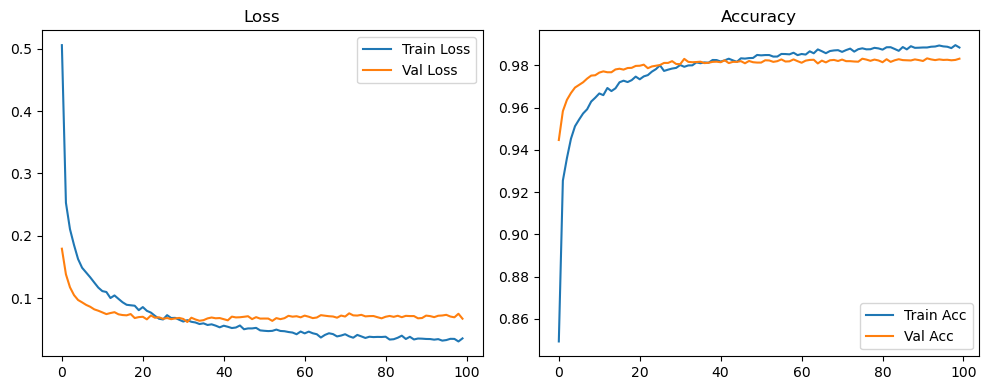

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2136, Acc: 0.9333 | Val Loss: 0.1398, Acc: 0.9584


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9705 | Val Loss: 0.1100, Acc: 0.9665


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9794 | Val Loss: 0.1055, Acc: 0.9694


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.0895, Acc: 0.9723


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9882 | Val Loss: 0.0914, Acc: 0.9757


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0919, Acc: 0.9740


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1066, Acc: 0.9735


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.1051, Acc: 0.9760


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 0.0969, Acc: 0.9773


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.1107, Acc: 0.9744


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0946, Acc: 0.9772


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0943, Acc: 0.9772


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1026, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1040, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1195, Acc: 0.9741


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0960, Acc: 0.9784


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1064, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1107, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1097, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0985, Acc: 0.9799


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0917, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0967, Acc: 0.9790


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1101, Acc: 0.9776


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1017, Acc: 0.9783


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1015, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1019, Acc: 0.9769


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0986, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9792


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1086, Acc: 0.9787


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0989, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1180, Acc: 0.9779


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1148, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0914, Acc: 0.9809


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1054, Acc: 0.9806


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1055, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1087, Acc: 0.9788


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.1175, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1154, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1098, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1102, Acc: 0.9775


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1058, Acc: 0.9813


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1073, Acc: 0.9805


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1141, Acc: 0.9801


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1212, Acc: 0.9791


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1059, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1027, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0932, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9810


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9808


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1144, Acc: 0.9796


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1276, Acc: 0.9775


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1059, Acc: 0.9815


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1101, Acc: 0.9805


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1361, Acc: 0.9796


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1584, Acc: 0.9767


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1144, Acc: 0.9793


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1095, Acc: 0.9802


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1117, Acc: 0.9804


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1157, Acc: 0.9797


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1092, Acc: 0.9811


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1143, Acc: 0.9805


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1093, Acc: 0.9808


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1248, Acc: 0.9808


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1231, Acc: 0.9799


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1238, Acc: 0.9779


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1113, Acc: 0.9803


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1101, Acc: 0.9813


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1126, Acc: 0.9818


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1177, Acc: 0.9792


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1084, Acc: 0.9818


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1146, Acc: 0.9814


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1305, Acc: 0.9801


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1208, Acc: 0.9809


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1146, Acc: 0.9804


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1122, Acc: 0.9812


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1067, Acc: 0.9820


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1147, Acc: 0.9807


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1198, Acc: 0.9808


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1472, Acc: 0.9764


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1265, Acc: 0.9806


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1168, Acc: 0.9816


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1122, Acc: 0.9821


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1183, Acc: 0.9821


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1224, Acc: 0.9814


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1354, Acc: 0.9794


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1207, Acc: 0.9798


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1059, Acc: 0.9818


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1091, Acc: 0.9826


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1121, Acc: 0.9830


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1243, Acc: 0.9804


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1098, Acc: 0.9815


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0981, Acc: 0.9836


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1026, Acc: 0.9819


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1147, Acc: 0.9822


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1111, Acc: 0.9813


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1210, Acc: 0.9803


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1095, Acc: 0.9828


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1086, Acc: 0.9828


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1108, Acc: 0.9836


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1088, Acc: 0.9828


Final Test Loss: 0.0952 Accuracy: 0.9853


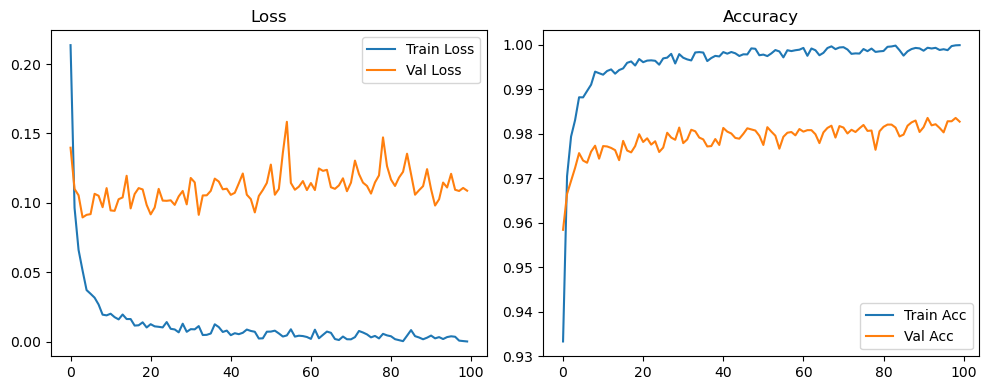

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2600, Acc: 0.9206 | Val Loss: 0.1379, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9597 | Val Loss: 0.1045, Acc: 0.9692


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9686 | Val Loss: 0.0959, Acc: 0.9722


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9733 | Val Loss: 0.0953, Acc: 0.9720


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9776 | Val Loss: 0.0911, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9798 | Val Loss: 0.0780, Acc: 0.9771


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9819 | Val Loss: 0.0831, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9838 | Val Loss: 0.0868, Acc: 0.9764


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.0795, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.0846, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.0751, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9864 | Val Loss: 0.0812, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.0899, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0829, Acc: 0.9782


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0756, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0784, Acc: 0.9798


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0863, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9908 | Val Loss: 0.0771, Acc: 0.9802


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0780, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9913 | Val Loss: 0.0747, Acc: 0.9817


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0807, Acc: 0.9807


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0825, Acc: 0.9798


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.0845, Acc: 0.9794


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0737, Acc: 0.9809


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0791, Acc: 0.9805


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0853, Acc: 0.9804


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0803, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0737, Acc: 0.9828


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0780, Acc: 0.9803


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0817, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0772, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0802, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0822, Acc: 0.9808


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0884, Acc: 0.9786


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0892, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0762, Acc: 0.9823


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0777, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0871, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0902, Acc: 0.9807


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0798, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0817, Acc: 0.9819


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0863, Acc: 0.9810


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0854, Acc: 0.9817


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0840, Acc: 0.9813


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0835, Acc: 0.9811


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0880, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.0884, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0878, Acc: 0.9813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0800, Acc: 0.9840


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0885, Acc: 0.9822


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0833, Acc: 0.9825


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0922, Acc: 0.9824


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0931, Acc: 0.9821


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0945, Acc: 0.9807


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0781, Acc: 0.9822


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0858, Acc: 0.9811


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0811, Acc: 0.9837


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0859, Acc: 0.9825


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0866, Acc: 0.9816


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0813, Acc: 0.9822


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0874, Acc: 0.9821


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0852, Acc: 0.9819


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0918, Acc: 0.9818


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9955 | Val Loss: 0.0776, Acc: 0.9838


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0899, Acc: 0.9802


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0863, Acc: 0.9821


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0920, Acc: 0.9818


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.0904, Acc: 0.9815


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0935, Acc: 0.9826


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.0826, Acc: 0.9829


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0938, Acc: 0.9822


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0896, Acc: 0.9823


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0881, Acc: 0.9832


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0859, Acc: 0.9819


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0897, Acc: 0.9829


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0944, Acc: 0.9821


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1024, Acc: 0.9817


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1102, Acc: 0.9824


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.0982, Acc: 0.9818


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1032, Acc: 0.9812


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.0948, Acc: 0.9821


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1000, Acc: 0.9816


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0916, Acc: 0.9822


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0961, Acc: 0.9815


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0939, Acc: 0.9828


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0918, Acc: 0.9832


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0841, Acc: 0.9828


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0898, Acc: 0.9822


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0868, Acc: 0.9841


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0923, Acc: 0.9835


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0955, Acc: 0.9836


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0935, Acc: 0.9826


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0941, Acc: 0.9822


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1005, Acc: 0.9826


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0916, Acc: 0.9834


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0965, Acc: 0.9831


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0919, Acc: 0.9840


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0982, Acc: 0.9822


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0856, Acc: 0.9815


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0913, Acc: 0.9837


Final Test Loss: 0.0811 Accuracy: 0.9851


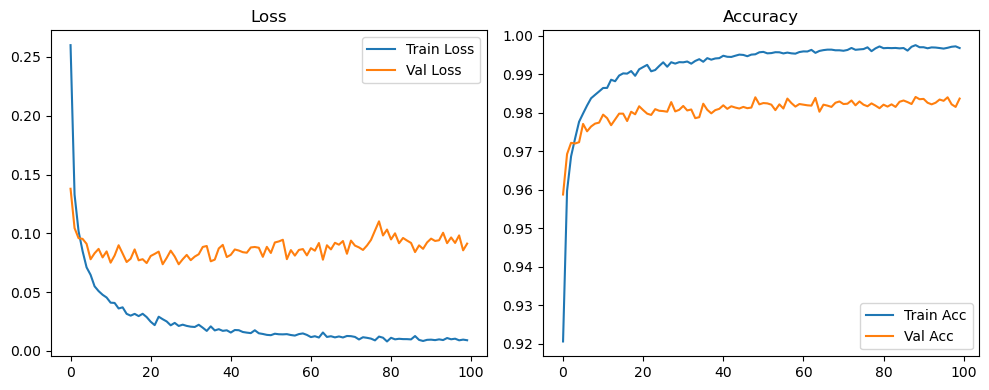

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4209, Acc: 0.8718 | Val Loss: 0.1623, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2347, Acc: 0.9319 | Val Loss: 0.1390, Acc: 0.9590


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1952, Acc: 0.9432 | Val Loss: 0.1159, Acc: 0.9662


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9503 | Val Loss: 0.1074, Acc: 0.9691


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9559 | Val Loss: 0.0923, Acc: 0.9705


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9567 | Val Loss: 0.0922, Acc: 0.9724


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9601 | Val Loss: 0.0886, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 0.0908, Acc: 0.9734


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9645 | Val Loss: 0.0816, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1132, Acc: 0.9663 | Val Loss: 0.0880, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1089, Acc: 0.9671 | Val Loss: 0.0825, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9683 | Val Loss: 0.0889, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9687 | Val Loss: 0.0816, Acc: 0.9779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9688 | Val Loss: 0.0806, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9707 | Val Loss: 0.0769, Acc: 0.9773


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9708 | Val Loss: 0.0769, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9718 | Val Loss: 0.0777, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9729 | Val Loss: 0.0808, Acc: 0.9787


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9725 | Val Loss: 0.0764, Acc: 0.9777


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9726 | Val Loss: 0.0759, Acc: 0.9777


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9746 | Val Loss: 0.0784, Acc: 0.9774


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9749 | Val Loss: 0.0767, Acc: 0.9786


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9747 | Val Loss: 0.0819, Acc: 0.9783


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9750 | Val Loss: 0.0751, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9749 | Val Loss: 0.0757, Acc: 0.9793


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9769 | Val Loss: 0.0728, Acc: 0.9796


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9770 | Val Loss: 0.0780, Acc: 0.9790


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9769 | Val Loss: 0.0779, Acc: 0.9803


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9790 | Val Loss: 0.0766, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9767 | Val Loss: 0.0759, Acc: 0.9798


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9780 | Val Loss: 0.0705, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9785 | Val Loss: 0.0797, Acc: 0.9799


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9786 | Val Loss: 0.0715, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9789 | Val Loss: 0.0786, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9786 | Val Loss: 0.0829, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9792 | Val Loss: 0.0747, Acc: 0.9800


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9807 | Val Loss: 0.0741, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9807 | Val Loss: 0.0746, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0724, Acc: 0.9798


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9805 | Val Loss: 0.0748, Acc: 0.9803


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9802 | Val Loss: 0.0806, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9807 | Val Loss: 0.0765, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9817 | Val Loss: 0.0752, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9819 | Val Loss: 0.0755, Acc: 0.9809


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9824 | Val Loss: 0.0777, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 0.0782, Acc: 0.9798


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9830 | Val Loss: 0.0758, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.0787, Acc: 0.9806


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9830 | Val Loss: 0.0716, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9827 | Val Loss: 0.0768, Acc: 0.9802


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9821 | Val Loss: 0.0719, Acc: 0.9808


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9825 | Val Loss: 0.0739, Acc: 0.9813


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9823 | Val Loss: 0.0741, Acc: 0.9805


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9834 | Val Loss: 0.0815, Acc: 0.9797


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9832 | Val Loss: 0.0843, Acc: 0.9794


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9830 | Val Loss: 0.0822, Acc: 0.9784


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9841 | Val Loss: 0.0808, Acc: 0.9798


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9836 | Val Loss: 0.0813, Acc: 0.9798


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9840 | Val Loss: 0.0817, Acc: 0.9796


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0814, Acc: 0.9801


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9839 | Val Loss: 0.0819, Acc: 0.9810


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9842 | Val Loss: 0.0787, Acc: 0.9815


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9846 | Val Loss: 0.0807, Acc: 0.9804


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.0770, Acc: 0.9806


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9851 | Val Loss: 0.0902, Acc: 0.9805


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9847 | Val Loss: 0.0786, Acc: 0.9812


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9853 | Val Loss: 0.0839, Acc: 0.9805


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9860 | Val Loss: 0.0846, Acc: 0.9808


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9851 | Val Loss: 0.0840, Acc: 0.9802


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9859 | Val Loss: 0.0833, Acc: 0.9812


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9853 | Val Loss: 0.0782, Acc: 0.9815


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9859 | Val Loss: 0.0770, Acc: 0.9818


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.0797, Acc: 0.9819


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9849 | Val Loss: 0.0874, Acc: 0.9801


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9868 | Val Loss: 0.0826, Acc: 0.9816


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9851 | Val Loss: 0.0820, Acc: 0.9807


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9863 | Val Loss: 0.0866, Acc: 0.9813


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9862 | Val Loss: 0.0849, Acc: 0.9807


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.0760, Acc: 0.9814


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9870 | Val Loss: 0.0853, Acc: 0.9814


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9868 | Val Loss: 0.0864, Acc: 0.9808


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9871 | Val Loss: 0.0816, Acc: 0.9819


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9867 | Val Loss: 0.0841, Acc: 0.9808


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9875 | Val Loss: 0.0887, Acc: 0.9805


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9876 | Val Loss: 0.0763, Acc: 0.9822


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9876 | Val Loss: 0.0855, Acc: 0.9816


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9868 | Val Loss: 0.0775, Acc: 0.9822


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9872 | Val Loss: 0.0830, Acc: 0.9826


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9871 | Val Loss: 0.0841, Acc: 0.9811


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9871 | Val Loss: 0.0829, Acc: 0.9794


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9876 | Val Loss: 0.0871, Acc: 0.9810


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9874 | Val Loss: 0.0837, Acc: 0.9810


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9876 | Val Loss: 0.0815, Acc: 0.9819


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.0820, Acc: 0.9811


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9879 | Val Loss: 0.0853, Acc: 0.9818


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.0870, Acc: 0.9812


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9879 | Val Loss: 0.0825, Acc: 0.9818


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9877 | Val Loss: 0.0855, Acc: 0.9814


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.0897, Acc: 0.9802


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9882 | Val Loss: 0.0848, Acc: 0.9810


Final Test Loss: 0.0762 Accuracy: 0.9830


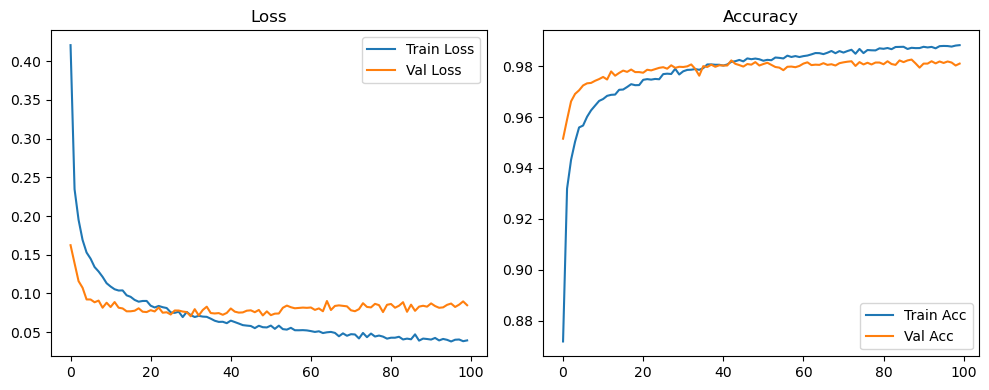

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2136, Acc: 0.9333 | Val Loss: 0.1398, Acc: 0.9584


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9705 | Val Loss: 0.1100, Acc: 0.9665


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9794 | Val Loss: 0.1055, Acc: 0.9694


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.0895, Acc: 0.9723


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9882 | Val Loss: 0.0914, Acc: 0.9757


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0919, Acc: 0.9740


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1066, Acc: 0.9735


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.1051, Acc: 0.9760


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 0.0969, Acc: 0.9773


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.1107, Acc: 0.9744


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0946, Acc: 0.9772


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0943, Acc: 0.9772


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1026, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1040, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1195, Acc: 0.9741


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0960, Acc: 0.9784


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1064, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1107, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1097, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0985, Acc: 0.9799


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0917, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0967, Acc: 0.9790


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1101, Acc: 0.9776


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1017, Acc: 0.9783


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1015, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1019, Acc: 0.9769


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0986, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9792


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1086, Acc: 0.9787


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0989, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1180, Acc: 0.9779


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1148, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0914, Acc: 0.9809


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1054, Acc: 0.9806


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1055, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1087, Acc: 0.9788


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.1175, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1154, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1098, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1102, Acc: 0.9775


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1058, Acc: 0.9813


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1073, Acc: 0.9805


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1141, Acc: 0.9801


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1212, Acc: 0.9791


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1059, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1027, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0932, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9810


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9808


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1144, Acc: 0.9796


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1102, Acc: 0.9803


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1080, Acc: 0.9822


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1043, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1046, Acc: 0.9823


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1120, Acc: 0.9815


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1096, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1107, Acc: 0.9812


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1225, Acc: 0.9808


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1210, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9828


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1225, Acc: 0.9812


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1164, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1192, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1278, Acc: 0.9807


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1361, Acc: 0.9786


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1318, Acc: 0.9815


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1271, Acc: 0.9827


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1322, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1291, Acc: 0.9816


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1270, Acc: 0.9825


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1277, Acc: 0.9809


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1333, Acc: 0.9809


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9996 | Val Loss: 0.1319, Acc: 0.9806


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1401, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1327, Acc: 0.9803


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1367, Acc: 0.9813


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1329, Acc: 0.9818


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1280, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1422, Acc: 0.9804


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1304, Acc: 0.9815


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1270, Acc: 0.9820


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1264, Acc: 0.9821


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1270, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1229, Acc: 0.9825


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1271, Acc: 0.9824


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1276, Acc: 0.9828


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1259, Acc: 0.9831


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1309, Acc: 0.9827


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1288, Acc: 0.9833


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1247, Acc: 0.9837


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1307, Acc: 0.9832


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1333, Acc: 0.9829


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1275, Acc: 0.9838


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1287, Acc: 0.9836


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1290, Acc: 0.9841


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1296, Acc: 0.9834


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1374, Acc: 0.9828


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1363, Acc: 0.9828


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1346, Acc: 0.9826


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1353, Acc: 0.9826


Final Test Loss: 0.1266 Accuracy: 0.9829


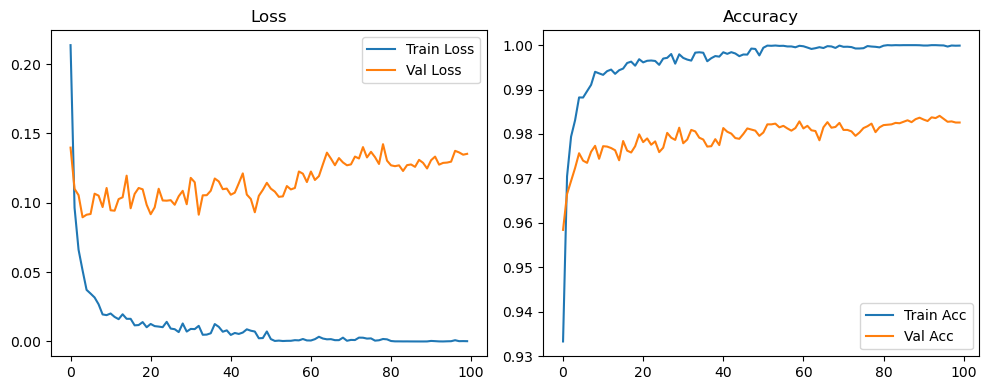

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2600, Acc: 0.9206 | Val Loss: 0.1379, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9597 | Val Loss: 0.1045, Acc: 0.9692


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9686 | Val Loss: 0.0959, Acc: 0.9722


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9733 | Val Loss: 0.0953, Acc: 0.9720


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9776 | Val Loss: 0.0911, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9798 | Val Loss: 0.0780, Acc: 0.9771


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9819 | Val Loss: 0.0831, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9838 | Val Loss: 0.0868, Acc: 0.9764


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.0795, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.0846, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.0751, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9864 | Val Loss: 0.0812, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.0899, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0829, Acc: 0.9782


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0756, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0784, Acc: 0.9798


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0863, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9908 | Val Loss: 0.0771, Acc: 0.9802


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0780, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9913 | Val Loss: 0.0747, Acc: 0.9817


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0807, Acc: 0.9807


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0825, Acc: 0.9798


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.0845, Acc: 0.9794


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0737, Acc: 0.9809


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0791, Acc: 0.9805


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0853, Acc: 0.9804


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0803, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0737, Acc: 0.9828


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0780, Acc: 0.9803


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0817, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0772, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0802, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0822, Acc: 0.9808


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0884, Acc: 0.9786


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0892, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0762, Acc: 0.9823


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0777, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0871, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0902, Acc: 0.9807


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0798, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0817, Acc: 0.9819


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0863, Acc: 0.9810


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0854, Acc: 0.9817


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0840, Acc: 0.9813


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0835, Acc: 0.9811


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0880, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.0884, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0878, Acc: 0.9813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0800, Acc: 0.9840


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0885, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0812, Acc: 0.9823


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0805, Acc: 0.9832


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0832, Acc: 0.9839


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0848, Acc: 0.9834


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0784, Acc: 0.9844


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0856, Acc: 0.9838


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0918, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0838, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0898, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0897, Acc: 0.9824


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0958, Acc: 0.9830


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0899, Acc: 0.9833


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0920, Acc: 0.9834


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0855, Acc: 0.9833


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0859, Acc: 0.9836


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0903, Acc: 0.9840


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0843, Acc: 0.9845


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0855, Acc: 0.9837


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0952, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0874, Acc: 0.9844


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0903, Acc: 0.9847


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0918, Acc: 0.9829


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0921, Acc: 0.9841


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0927, Acc: 0.9829


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0858, Acc: 0.9839


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0946, Acc: 0.9830


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0896, Acc: 0.9836


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0944, Acc: 0.9831


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0912, Acc: 0.9825


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0893, Acc: 0.9839


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0897, Acc: 0.9838


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0870, Acc: 0.9841


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0924, Acc: 0.9842


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0906, Acc: 0.9843


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0919, Acc: 0.9843


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0889, Acc: 0.9847


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0873, Acc: 0.9847


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0896, Acc: 0.9843


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0922, Acc: 0.9844


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0929, Acc: 0.9850


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0963, Acc: 0.9844


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9991 | Val Loss: 0.0958, Acc: 0.9845


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0951, Acc: 0.9838


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0955, Acc: 0.9840


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0963, Acc: 0.9845


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0909, Acc: 0.9842


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0940, Acc: 0.9842


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0969, Acc: 0.9849


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0972, Acc: 0.9845


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0955, Acc: 0.9838


Final Test Loss: 0.0969 Accuracy: 0.9855


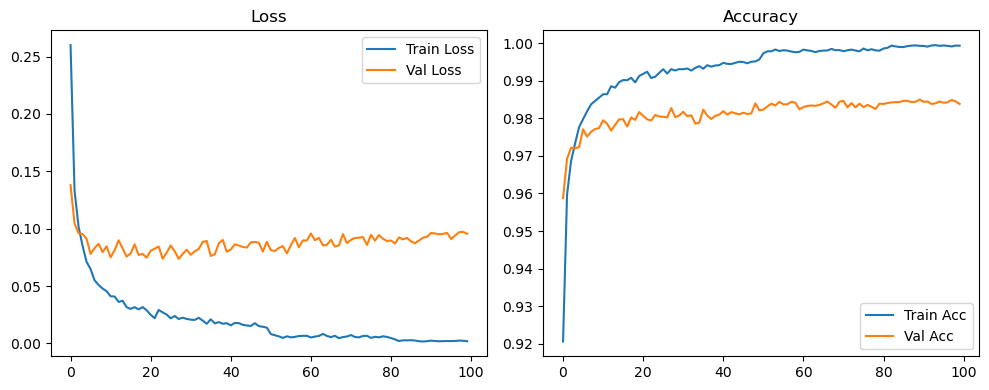

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4209, Acc: 0.8718 | Val Loss: 0.1623, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2347, Acc: 0.9319 | Val Loss: 0.1390, Acc: 0.9590


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1952, Acc: 0.9432 | Val Loss: 0.1159, Acc: 0.9662


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9503 | Val Loss: 0.1074, Acc: 0.9691


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9559 | Val Loss: 0.0923, Acc: 0.9705


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9567 | Val Loss: 0.0922, Acc: 0.9724


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9601 | Val Loss: 0.0886, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 0.0908, Acc: 0.9734


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9645 | Val Loss: 0.0816, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1132, Acc: 0.9663 | Val Loss: 0.0880, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1089, Acc: 0.9671 | Val Loss: 0.0825, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9683 | Val Loss: 0.0889, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9687 | Val Loss: 0.0816, Acc: 0.9779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9688 | Val Loss: 0.0806, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9707 | Val Loss: 0.0769, Acc: 0.9773


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9708 | Val Loss: 0.0769, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9718 | Val Loss: 0.0777, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9729 | Val Loss: 0.0808, Acc: 0.9787


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9725 | Val Loss: 0.0764, Acc: 0.9777


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9726 | Val Loss: 0.0759, Acc: 0.9777


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9746 | Val Loss: 0.0784, Acc: 0.9774


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9749 | Val Loss: 0.0767, Acc: 0.9786


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9747 | Val Loss: 0.0819, Acc: 0.9783


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9750 | Val Loss: 0.0751, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9749 | Val Loss: 0.0757, Acc: 0.9793


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9769 | Val Loss: 0.0728, Acc: 0.9796


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9770 | Val Loss: 0.0780, Acc: 0.9790


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9769 | Val Loss: 0.0779, Acc: 0.9803


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9790 | Val Loss: 0.0766, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9767 | Val Loss: 0.0759, Acc: 0.9798


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9780 | Val Loss: 0.0705, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9785 | Val Loss: 0.0797, Acc: 0.9799


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9786 | Val Loss: 0.0715, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9789 | Val Loss: 0.0786, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9786 | Val Loss: 0.0829, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9792 | Val Loss: 0.0747, Acc: 0.9800


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9807 | Val Loss: 0.0741, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9807 | Val Loss: 0.0746, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0724, Acc: 0.9798


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9805 | Val Loss: 0.0748, Acc: 0.9803


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9802 | Val Loss: 0.0806, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9807 | Val Loss: 0.0765, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9817 | Val Loss: 0.0752, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9819 | Val Loss: 0.0755, Acc: 0.9809


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9824 | Val Loss: 0.0777, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 0.0782, Acc: 0.9798


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9830 | Val Loss: 0.0758, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.0787, Acc: 0.9806


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9830 | Val Loss: 0.0716, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9827 | Val Loss: 0.0768, Acc: 0.9802


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9847 | Val Loss: 0.0714, Acc: 0.9820


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0759, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9875 | Val Loss: 0.0741, Acc: 0.9824


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.0776, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9886 | Val Loss: 0.0799, Acc: 0.9805


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0794, Acc: 0.9805


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0817, Acc: 0.9815


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0796, Acc: 0.9808


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9890 | Val Loss: 0.0797, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9890 | Val Loss: 0.0781, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9886 | Val Loss: 0.0798, Acc: 0.9816


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9898 | Val Loss: 0.0796, Acc: 0.9819


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.0764, Acc: 0.9818


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0775, Acc: 0.9820


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9902 | Val Loss: 0.0864, Acc: 0.9815


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9895 | Val Loss: 0.0768, Acc: 0.9822


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.0838, Acc: 0.9807


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9908 | Val Loss: 0.0859, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9895 | Val Loss: 0.0778, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0790, Acc: 0.9819


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0793, Acc: 0.9822


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9902 | Val Loss: 0.0838, Acc: 0.9810


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.0835, Acc: 0.9812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 0.0841, Acc: 0.9803


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0869, Acc: 0.9809


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0827, Acc: 0.9813


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0829, Acc: 0.9814


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.0845, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.0832, Acc: 0.9818


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.0800, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.0872, Acc: 0.9819


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0836, Acc: 0.9818


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0895, Acc: 0.9814


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0884, Acc: 0.9814


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.0854, Acc: 0.9817


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9940 | Val Loss: 0.0884, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0847, Acc: 0.9813


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0878, Acc: 0.9813


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0890, Acc: 0.9808


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9934 | Val Loss: 0.0832, Acc: 0.9816


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0897, Acc: 0.9812


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0905, Acc: 0.9804


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0891, Acc: 0.9818


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9939 | Val Loss: 0.0865, Acc: 0.9823


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0901, Acc: 0.9819


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0933, Acc: 0.9818


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0915, Acc: 0.9818


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0908, Acc: 0.9808


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0939, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0917, Acc: 0.9812


Final Test Loss: 0.0839 Accuracy: 0.9836


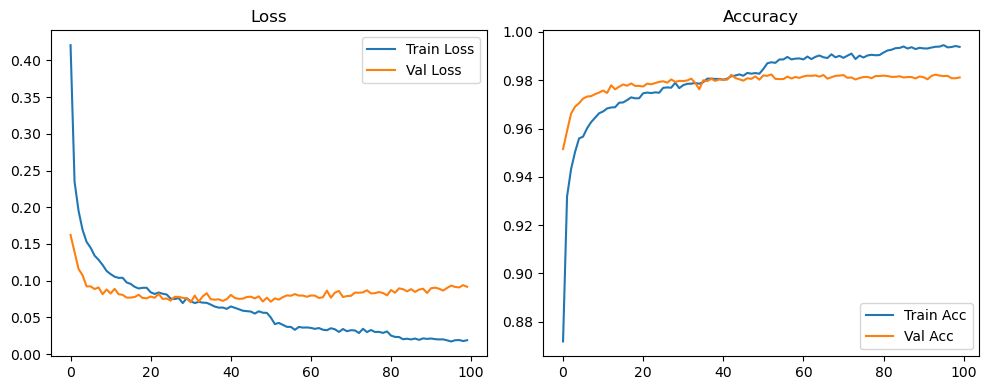

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2136, Acc: 0.9333 | Val Loss: 0.1398, Acc: 0.9584


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9705 | Val Loss: 0.1100, Acc: 0.9665


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9794 | Val Loss: 0.1055, Acc: 0.9694


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.0895, Acc: 0.9723


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9882 | Val Loss: 0.0914, Acc: 0.9757


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0919, Acc: 0.9740


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1066, Acc: 0.9735


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.1051, Acc: 0.9760


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 0.0969, Acc: 0.9773


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.1107, Acc: 0.9744


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0946, Acc: 0.9772


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0943, Acc: 0.9772


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1026, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1040, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1195, Acc: 0.9741


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0960, Acc: 0.9784


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1064, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1107, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1097, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0985, Acc: 0.9799


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0917, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0967, Acc: 0.9790


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1101, Acc: 0.9776


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1017, Acc: 0.9783


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1015, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1019, Acc: 0.9769


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0986, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9792


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1086, Acc: 0.9787


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0989, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1180, Acc: 0.9779


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1148, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0914, Acc: 0.9809


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1054, Acc: 0.9806


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1055, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1087, Acc: 0.9788


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.1175, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1154, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1098, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1102, Acc: 0.9775


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1058, Acc: 0.9813


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1073, Acc: 0.9805


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1141, Acc: 0.9801


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1212, Acc: 0.9791


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1059, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1027, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0932, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9810


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9808


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1144, Acc: 0.9796


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1102, Acc: 0.9803


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1080, Acc: 0.9822


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1043, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1046, Acc: 0.9823


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1120, Acc: 0.9815


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1096, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1107, Acc: 0.9812


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1225, Acc: 0.9808


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1210, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9828


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1225, Acc: 0.9812


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1164, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1192, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1278, Acc: 0.9807


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1361, Acc: 0.9786


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1318, Acc: 0.9815


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1271, Acc: 0.9827


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1322, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1291, Acc: 0.9816


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1270, Acc: 0.9825


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1277, Acc: 0.9809


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1333, Acc: 0.9809


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9996 | Val Loss: 0.1319, Acc: 0.9806


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1401, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1327, Acc: 0.9803


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1367, Acc: 0.9813


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1329, Acc: 0.9818


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1280, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1422, Acc: 0.9804


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1304, Acc: 0.9815


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1290, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1289, Acc: 0.9823


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1295, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1242, Acc: 0.9819


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1266, Acc: 0.9827


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1274, Acc: 0.9820


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1254, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1296, Acc: 0.9826


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1280, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1253, Acc: 0.9831


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1291, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1289, Acc: 0.9827


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1250, Acc: 0.9832


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1268, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1279, Acc: 0.9837


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1265, Acc: 0.9829


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1296, Acc: 0.9834


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1326, Acc: 0.9826


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1308, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1298, Acc: 0.9830


Final Test Loss: 0.1125 Accuracy: 0.9842


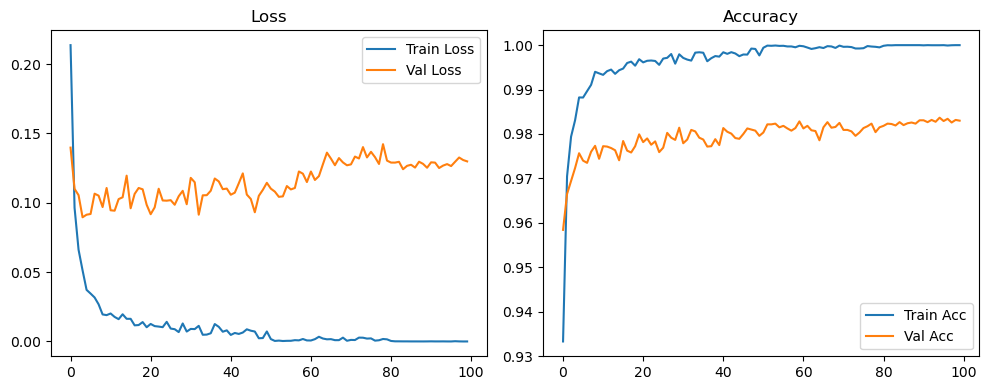

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2600, Acc: 0.9206 | Val Loss: 0.1379, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9597 | Val Loss: 0.1045, Acc: 0.9692


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9686 | Val Loss: 0.0959, Acc: 0.9722


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9733 | Val Loss: 0.0953, Acc: 0.9720


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9776 | Val Loss: 0.0911, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9798 | Val Loss: 0.0780, Acc: 0.9771


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9819 | Val Loss: 0.0831, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9838 | Val Loss: 0.0868, Acc: 0.9764


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.0795, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.0846, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.0751, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9864 | Val Loss: 0.0812, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.0899, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0829, Acc: 0.9782


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0756, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0784, Acc: 0.9798


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0863, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9908 | Val Loss: 0.0771, Acc: 0.9802


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0780, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9913 | Val Loss: 0.0747, Acc: 0.9817


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0807, Acc: 0.9807


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0825, Acc: 0.9798


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.0845, Acc: 0.9794


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0737, Acc: 0.9809


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0791, Acc: 0.9805


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0853, Acc: 0.9804


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0803, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0737, Acc: 0.9828


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0780, Acc: 0.9803


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0817, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0772, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0802, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0822, Acc: 0.9808


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0884, Acc: 0.9786


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0892, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0762, Acc: 0.9823


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0777, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0871, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0902, Acc: 0.9807


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0798, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0817, Acc: 0.9819


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0863, Acc: 0.9810


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0854, Acc: 0.9817


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0840, Acc: 0.9813


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0835, Acc: 0.9811


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0880, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.0884, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0878, Acc: 0.9813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0800, Acc: 0.9840


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0885, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0812, Acc: 0.9823


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0805, Acc: 0.9832


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0832, Acc: 0.9839


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0848, Acc: 0.9834


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0784, Acc: 0.9844


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0856, Acc: 0.9838


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0918, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0838, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0898, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0897, Acc: 0.9824


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0958, Acc: 0.9830


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0899, Acc: 0.9833


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0920, Acc: 0.9834


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0855, Acc: 0.9833


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0859, Acc: 0.9836


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0903, Acc: 0.9840


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0843, Acc: 0.9845


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0855, Acc: 0.9837


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0952, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0874, Acc: 0.9844


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0903, Acc: 0.9847


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0918, Acc: 0.9829


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0921, Acc: 0.9841


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0927, Acc: 0.9829


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0858, Acc: 0.9839


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0946, Acc: 0.9830


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0896, Acc: 0.9836


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0944, Acc: 0.9831


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0912, Acc: 0.9825


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0893, Acc: 0.9839


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0898, Acc: 0.9836


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0861, Acc: 0.9847


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0880, Acc: 0.9843


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0871, Acc: 0.9846


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0896, Acc: 0.9841


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0888, Acc: 0.9842


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0873, Acc: 0.9841


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0893, Acc: 0.9838


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0899, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0904, Acc: 0.9848


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0928, Acc: 0.9848


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0921, Acc: 0.9848


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0920, Acc: 0.9843


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0920, Acc: 0.9845


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0935, Acc: 0.9845


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0901, Acc: 0.9847


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0916, Acc: 0.9845


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0914, Acc: 0.9847


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0941, Acc: 0.9849


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0944, Acc: 0.9852


Final Test Loss: 0.0953 Accuracy: 0.9860


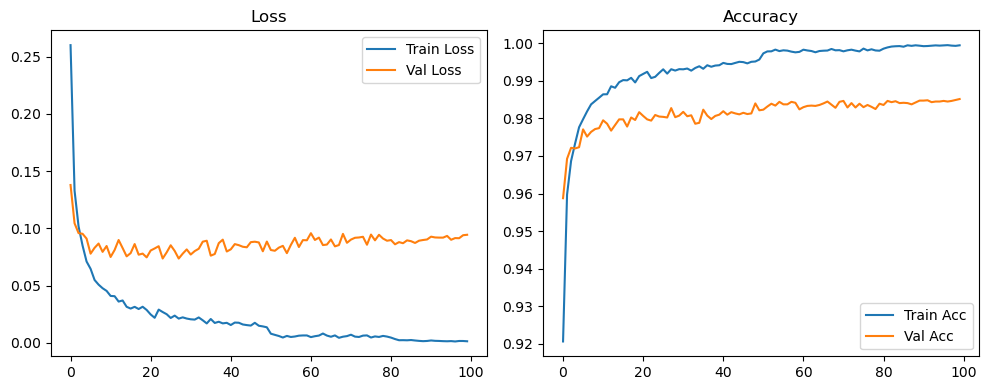

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4209, Acc: 0.8718 | Val Loss: 0.1623, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2347, Acc: 0.9319 | Val Loss: 0.1390, Acc: 0.9590


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1952, Acc: 0.9432 | Val Loss: 0.1159, Acc: 0.9662


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9503 | Val Loss: 0.1074, Acc: 0.9691


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9559 | Val Loss: 0.0923, Acc: 0.9705


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9567 | Val Loss: 0.0922, Acc: 0.9724


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9601 | Val Loss: 0.0886, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 0.0908, Acc: 0.9734


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9645 | Val Loss: 0.0816, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1132, Acc: 0.9663 | Val Loss: 0.0880, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1089, Acc: 0.9671 | Val Loss: 0.0825, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9683 | Val Loss: 0.0889, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9687 | Val Loss: 0.0816, Acc: 0.9779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9688 | Val Loss: 0.0806, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9707 | Val Loss: 0.0769, Acc: 0.9773


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9708 | Val Loss: 0.0769, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9718 | Val Loss: 0.0777, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9729 | Val Loss: 0.0808, Acc: 0.9787


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9725 | Val Loss: 0.0764, Acc: 0.9777


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9726 | Val Loss: 0.0759, Acc: 0.9777


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9746 | Val Loss: 0.0784, Acc: 0.9774


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9749 | Val Loss: 0.0767, Acc: 0.9786


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9747 | Val Loss: 0.0819, Acc: 0.9783


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9750 | Val Loss: 0.0751, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9749 | Val Loss: 0.0757, Acc: 0.9793


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9769 | Val Loss: 0.0728, Acc: 0.9796


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9770 | Val Loss: 0.0780, Acc: 0.9790


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9769 | Val Loss: 0.0779, Acc: 0.9803


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9790 | Val Loss: 0.0766, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9767 | Val Loss: 0.0759, Acc: 0.9798


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9780 | Val Loss: 0.0705, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9785 | Val Loss: 0.0797, Acc: 0.9799


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9786 | Val Loss: 0.0715, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9789 | Val Loss: 0.0786, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9786 | Val Loss: 0.0829, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9792 | Val Loss: 0.0747, Acc: 0.9800


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9807 | Val Loss: 0.0741, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9807 | Val Loss: 0.0746, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0724, Acc: 0.9798


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9805 | Val Loss: 0.0748, Acc: 0.9803


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9802 | Val Loss: 0.0806, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9807 | Val Loss: 0.0765, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9817 | Val Loss: 0.0752, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9819 | Val Loss: 0.0755, Acc: 0.9809


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9824 | Val Loss: 0.0777, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 0.0782, Acc: 0.9798


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9830 | Val Loss: 0.0758, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.0787, Acc: 0.9806


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9830 | Val Loss: 0.0716, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9827 | Val Loss: 0.0768, Acc: 0.9802


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9847 | Val Loss: 0.0714, Acc: 0.9820


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0759, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9875 | Val Loss: 0.0741, Acc: 0.9824


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.0776, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9886 | Val Loss: 0.0799, Acc: 0.9805


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0794, Acc: 0.9805


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0817, Acc: 0.9815


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0796, Acc: 0.9808


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9890 | Val Loss: 0.0797, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9890 | Val Loss: 0.0781, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9886 | Val Loss: 0.0798, Acc: 0.9816


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9898 | Val Loss: 0.0796, Acc: 0.9819


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.0764, Acc: 0.9818


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0775, Acc: 0.9820


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9902 | Val Loss: 0.0864, Acc: 0.9815


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9895 | Val Loss: 0.0768, Acc: 0.9822


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.0838, Acc: 0.9807


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9908 | Val Loss: 0.0859, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9895 | Val Loss: 0.0778, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0790, Acc: 0.9819


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0793, Acc: 0.9822


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9902 | Val Loss: 0.0838, Acc: 0.9810


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.0835, Acc: 0.9812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 0.0841, Acc: 0.9803


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0869, Acc: 0.9809


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0827, Acc: 0.9813


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0829, Acc: 0.9814


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.0845, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.0832, Acc: 0.9818


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.0800, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9914 | Val Loss: 0.0853, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0830, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0882, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0866, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.0865, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0880, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0847, Acc: 0.9814


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0876, Acc: 0.9814


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0886, Acc: 0.9812


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.0839, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9938 | Val Loss: 0.0897, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0882, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0875, Acc: 0.9815


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.0866, Acc: 0.9821


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0889, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0903, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.0901, Acc: 0.9827


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0885, Acc: 0.9817


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0909, Acc: 0.9816


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9942 | Val Loss: 0.0892, Acc: 0.9818


Final Test Loss: 0.0806 Accuracy: 0.9834


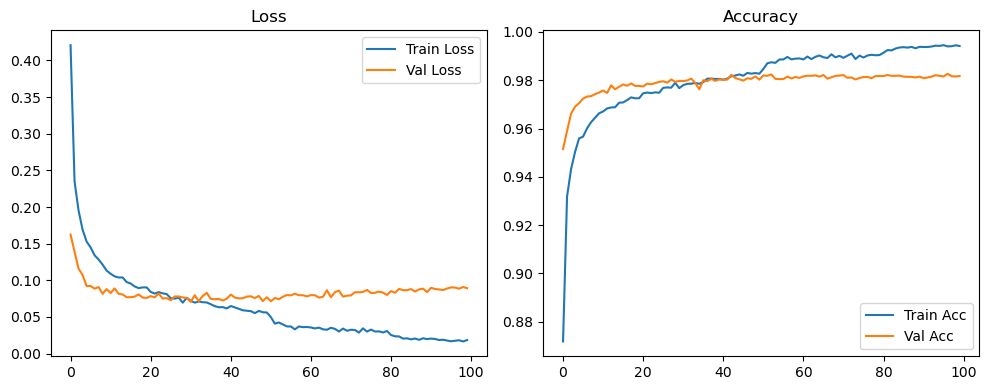

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2136, Acc: 0.9333 | Val Loss: 0.1398, Acc: 0.9584


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9705 | Val Loss: 0.1100, Acc: 0.9665


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9794 | Val Loss: 0.1055, Acc: 0.9694


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.0895, Acc: 0.9723


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9882 | Val Loss: 0.0914, Acc: 0.9757


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0919, Acc: 0.9740


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1066, Acc: 0.9735


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.1051, Acc: 0.9760


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 0.0969, Acc: 0.9773


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.1107, Acc: 0.9744


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0946, Acc: 0.9772


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0943, Acc: 0.9772


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1026, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1040, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1195, Acc: 0.9741


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0960, Acc: 0.9784


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1064, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1107, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1097, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0985, Acc: 0.9799


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0917, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0967, Acc: 0.9790


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1101, Acc: 0.9776


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1017, Acc: 0.9783


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1015, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1019, Acc: 0.9769


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0986, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9792


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1086, Acc: 0.9787


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0989, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1180, Acc: 0.9779


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1148, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0914, Acc: 0.9809


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1054, Acc: 0.9806


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1055, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1087, Acc: 0.9788


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.1175, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1154, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1098, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1102, Acc: 0.9775


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1058, Acc: 0.9813


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1073, Acc: 0.9805


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1141, Acc: 0.9801


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1212, Acc: 0.9791


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1059, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1027, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0932, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9810


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9808


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1144, Acc: 0.9796


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1074, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1076, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1053, Acc: 0.9812


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1050, Acc: 0.9815


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1055, Acc: 0.9826


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1056, Acc: 0.9826


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1068, Acc: 0.9830


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1078, Acc: 0.9827


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1065, Acc: 0.9832


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1076, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1085, Acc: 0.9832


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1086, Acc: 0.9828


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1090, Acc: 0.9832


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1085, Acc: 0.9828


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1078, Acc: 0.9837


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9837


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1114, Acc: 0.9836


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1108, Acc: 0.9833


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1134, Acc: 0.9838


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1122, Acc: 0.9837


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1147, Acc: 0.9831


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1178, Acc: 0.9822


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1183, Acc: 0.9825


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1167, Acc: 0.9838


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1168, Acc: 0.9832


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1213, Acc: 0.9827


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1235, Acc: 0.9825


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1391, Acc: 0.9814


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1238, Acc: 0.9832


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1174, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1232, Acc: 0.9827


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1190, Acc: 0.9830


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1225, Acc: 0.9828


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1173, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1191, Acc: 0.9833


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1175, Acc: 0.9841


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1159, Acc: 0.9836


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1172, Acc: 0.9838


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1178, Acc: 0.9834


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1152, Acc: 0.9836


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1195, Acc: 0.9837


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1192, Acc: 0.9839


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1209, Acc: 0.9840


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1190, Acc: 0.9836


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1181, Acc: 0.9836


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1187, Acc: 0.9837


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1214, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1205, Acc: 0.9835


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1192, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1216, Acc: 0.9832


Final Test Loss: 0.1113 Accuracy: 0.9847


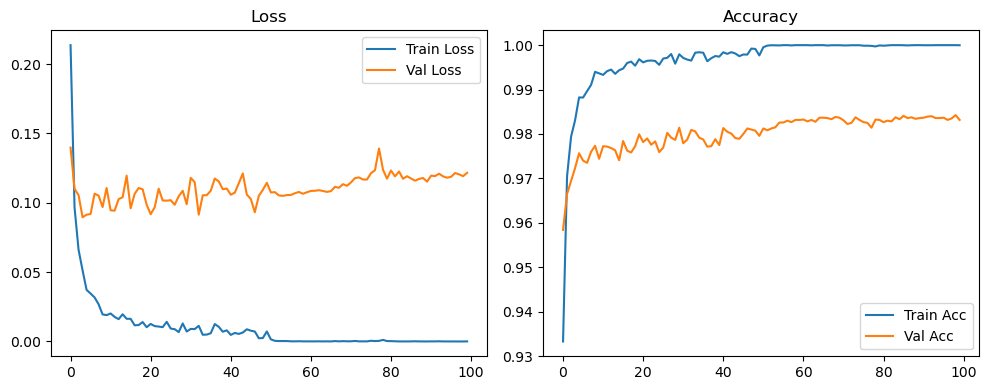

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2600, Acc: 0.9206 | Val Loss: 0.1379, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9597 | Val Loss: 0.1045, Acc: 0.9692


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9686 | Val Loss: 0.0959, Acc: 0.9722


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9733 | Val Loss: 0.0953, Acc: 0.9720


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9776 | Val Loss: 0.0911, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9798 | Val Loss: 0.0780, Acc: 0.9771


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9819 | Val Loss: 0.0831, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9838 | Val Loss: 0.0868, Acc: 0.9764


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.0795, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.0846, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.0751, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9864 | Val Loss: 0.0812, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.0899, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0829, Acc: 0.9782


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0756, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0784, Acc: 0.9798


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0863, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9908 | Val Loss: 0.0771, Acc: 0.9802


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0780, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9913 | Val Loss: 0.0747, Acc: 0.9817


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0807, Acc: 0.9807


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0825, Acc: 0.9798


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.0845, Acc: 0.9794


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0737, Acc: 0.9809


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0791, Acc: 0.9805


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0853, Acc: 0.9804


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0803, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0737, Acc: 0.9828


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0780, Acc: 0.9803


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0817, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0772, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0802, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0822, Acc: 0.9808


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0884, Acc: 0.9786


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0892, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0762, Acc: 0.9823


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0777, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0871, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0902, Acc: 0.9807


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0798, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0817, Acc: 0.9819


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0863, Acc: 0.9810


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0854, Acc: 0.9817


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0840, Acc: 0.9813


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0835, Acc: 0.9811


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0880, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.0884, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0878, Acc: 0.9813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0800, Acc: 0.9840


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0885, Acc: 0.9822


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0793, Acc: 0.9841


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0803, Acc: 0.9838


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0809, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0793, Acc: 0.9845


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0799, Acc: 0.9842


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0831, Acc: 0.9848


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0840, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0836, Acc: 0.9846


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0854, Acc: 0.9845


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0882, Acc: 0.9837


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0848, Acc: 0.9843


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0795, Acc: 0.9848


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0804, Acc: 0.9848


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0767, Acc: 0.9858


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0776, Acc: 0.9853


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0793, Acc: 0.9852


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0796, Acc: 0.9844


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0862, Acc: 0.9842


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0869, Acc: 0.9840


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0817, Acc: 0.9849


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0849, Acc: 0.9842


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0856, Acc: 0.9842


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0838, Acc: 0.9843


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0859, Acc: 0.9844


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0847, Acc: 0.9845


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0877, Acc: 0.9839


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0861, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0858, Acc: 0.9846


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0838, Acc: 0.9848


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0830, Acc: 0.9842


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0846, Acc: 0.9848


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0837, Acc: 0.9854


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0856, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0817, Acc: 0.9853


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0843, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0826, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0819, Acc: 0.9859


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0827, Acc: 0.9861


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0857, Acc: 0.9856


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0870, Acc: 0.9857


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0901, Acc: 0.9852


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0898, Acc: 0.9850


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0889, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0867, Acc: 0.9848


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0882, Acc: 0.9853


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0879, Acc: 0.9848


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0906, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0877, Acc: 0.9857


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0886, Acc: 0.9861


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0910, Acc: 0.9852


Final Test Loss: 0.0904 Accuracy: 0.9858


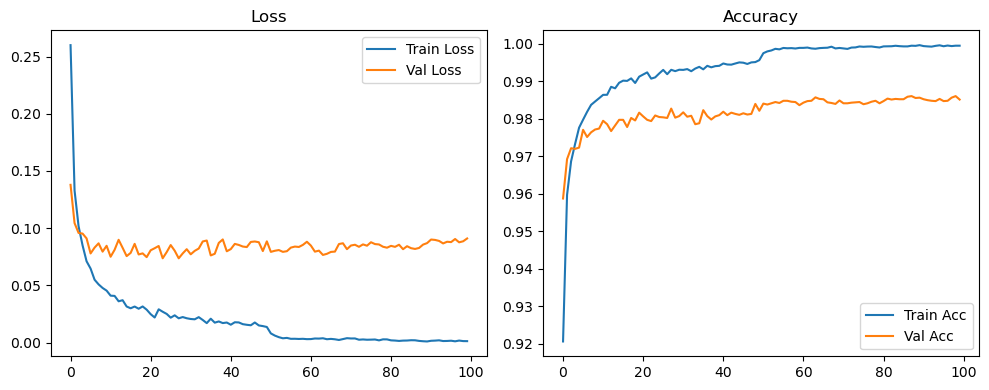

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4209, Acc: 0.8718 | Val Loss: 0.1623, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2347, Acc: 0.9319 | Val Loss: 0.1390, Acc: 0.9590


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1952, Acc: 0.9432 | Val Loss: 0.1159, Acc: 0.9662


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9503 | Val Loss: 0.1074, Acc: 0.9691


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9559 | Val Loss: 0.0923, Acc: 0.9705


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9567 | Val Loss: 0.0922, Acc: 0.9724


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9601 | Val Loss: 0.0886, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 0.0908, Acc: 0.9734


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9645 | Val Loss: 0.0816, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1132, Acc: 0.9663 | Val Loss: 0.0880, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1089, Acc: 0.9671 | Val Loss: 0.0825, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9683 | Val Loss: 0.0889, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9687 | Val Loss: 0.0816, Acc: 0.9779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9688 | Val Loss: 0.0806, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9707 | Val Loss: 0.0769, Acc: 0.9773


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9708 | Val Loss: 0.0769, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9718 | Val Loss: 0.0777, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9729 | Val Loss: 0.0808, Acc: 0.9787


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9725 | Val Loss: 0.0764, Acc: 0.9777


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9726 | Val Loss: 0.0759, Acc: 0.9777


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9746 | Val Loss: 0.0784, Acc: 0.9774


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9749 | Val Loss: 0.0767, Acc: 0.9786


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9747 | Val Loss: 0.0819, Acc: 0.9783


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9750 | Val Loss: 0.0751, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9749 | Val Loss: 0.0757, Acc: 0.9793


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9769 | Val Loss: 0.0728, Acc: 0.9796


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9770 | Val Loss: 0.0780, Acc: 0.9790


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9769 | Val Loss: 0.0779, Acc: 0.9803


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9790 | Val Loss: 0.0766, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9767 | Val Loss: 0.0759, Acc: 0.9798


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9780 | Val Loss: 0.0705, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9785 | Val Loss: 0.0797, Acc: 0.9799


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9786 | Val Loss: 0.0715, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9789 | Val Loss: 0.0786, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9786 | Val Loss: 0.0829, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9792 | Val Loss: 0.0747, Acc: 0.9800


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9807 | Val Loss: 0.0741, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9807 | Val Loss: 0.0746, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0724, Acc: 0.9798


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9805 | Val Loss: 0.0748, Acc: 0.9803


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9802 | Val Loss: 0.0806, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9807 | Val Loss: 0.0765, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9817 | Val Loss: 0.0752, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9819 | Val Loss: 0.0755, Acc: 0.9809


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9824 | Val Loss: 0.0777, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 0.0782, Acc: 0.9798


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9830 | Val Loss: 0.0758, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.0787, Acc: 0.9806


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9830 | Val Loss: 0.0716, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9827 | Val Loss: 0.0768, Acc: 0.9802


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9849 | Val Loss: 0.0718, Acc: 0.9814


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.0740, Acc: 0.9819


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9881 | Val Loss: 0.0735, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0748, Acc: 0.9817


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9901 | Val Loss: 0.0741, Acc: 0.9822


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9897 | Val Loss: 0.0756, Acc: 0.9823


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9908 | Val Loss: 0.0770, Acc: 0.9825


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9905 | Val Loss: 0.0765, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.0781, Acc: 0.9820


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0775, Acc: 0.9822


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0779, Acc: 0.9820


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9915 | Val Loss: 0.0761, Acc: 0.9827


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9914 | Val Loss: 0.0753, Acc: 0.9828


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.0774, Acc: 0.9827


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.0793, Acc: 0.9826


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9916 | Val Loss: 0.0783, Acc: 0.9820


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9917 | Val Loss: 0.0791, Acc: 0.9824


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.0828, Acc: 0.9823


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9918 | Val Loss: 0.0759, Acc: 0.9832


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0764, Acc: 0.9834


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.0776, Acc: 0.9824


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0802, Acc: 0.9820


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0816, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.0791, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0821, Acc: 0.9827


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9924 | Val Loss: 0.0809, Acc: 0.9827


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.0832, Acc: 0.9821


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0799, Acc: 0.9826


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.0811, Acc: 0.9827


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0816, Acc: 0.9830


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0837, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0811, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0861, Acc: 0.9823


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0827, Acc: 0.9827


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0835, Acc: 0.9825


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0842, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0814, Acc: 0.9828


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.0853, Acc: 0.9819


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9940 | Val Loss: 0.0856, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0825, Acc: 0.9825


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0876, Acc: 0.9820


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0847, Acc: 0.9823


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0824, Acc: 0.9821


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9942 | Val Loss: 0.0827, Acc: 0.9826


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0856, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0866, Acc: 0.9823


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0863, Acc: 0.9825


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0869, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9938 | Val Loss: 0.0877, Acc: 0.9820


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0865, Acc: 0.9821


Final Test Loss: 0.0796 Accuracy: 0.9833


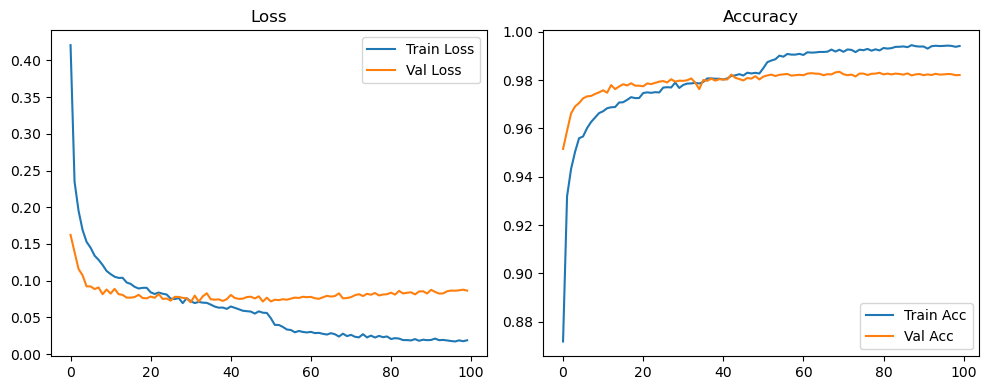

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2029, Acc: 0.9370 | Val Loss: 0.1262, Acc: 0.9614


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0879, Acc: 0.9726 | Val Loss: 0.1060, Acc: 0.9674


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9804 | Val Loss: 0.0970, Acc: 0.9708


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.0930, Acc: 0.9716


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0937, Acc: 0.9723


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0824, Acc: 0.9759


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0976, Acc: 0.9744


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0811, Acc: 0.9772


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9941 | Val Loss: 0.0939, Acc: 0.9773


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0878, Acc: 0.9783


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0965, Acc: 0.9776


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.0981, Acc: 0.9777


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.1023, Acc: 0.9782


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0978, Acc: 0.9768


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0903, Acc: 0.9795


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0949, Acc: 0.9788


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1063, Acc: 0.9764


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1105, Acc: 0.9753


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.1004, Acc: 0.9768


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0983, Acc: 0.9787


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1136, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1003, Acc: 0.9786


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1084, Acc: 0.9779


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0893, Acc: 0.9805


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1076, Acc: 0.9788


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1087, Acc: 0.9782


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0963, Acc: 0.9817


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1084, Acc: 0.9798


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1118, Acc: 0.9781


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1163, Acc: 0.9795


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0984, Acc: 0.9806


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1034, Acc: 0.9792


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1056, Acc: 0.9792


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0928, Acc: 0.9821


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1042, Acc: 0.9814


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1085, Acc: 0.9822


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1213, Acc: 0.9768


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1046, Acc: 0.9801


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1016, Acc: 0.9807


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1025, Acc: 0.9804


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1097, Acc: 0.9799


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0940, Acc: 0.9809


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1034, Acc: 0.9793


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1025, Acc: 0.9823


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0912, Acc: 0.9822


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1042, Acc: 0.9816


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1072, Acc: 0.9802


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1027, Acc: 0.9808


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1098, Acc: 0.9805


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0989, Acc: 0.9820


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0978, Acc: 0.9812


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1138, Acc: 0.9784


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1025, Acc: 0.9804


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1017, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0928, Acc: 0.9824


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0988, Acc: 0.9819


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1120, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0989, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1115, Acc: 0.9799


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1017, Acc: 0.9813


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0975, Acc: 0.9827


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1022, Acc: 0.9805


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0987, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1035, Acc: 0.9823


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1011, Acc: 0.9827


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1130, Acc: 0.9806


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1068, Acc: 0.9825


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1060, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1178, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0993, Acc: 0.9814


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0966, Acc: 0.9821


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1041, Acc: 0.9822


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0968, Acc: 0.9827


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0985, Acc: 0.9832


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1027, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1088, Acc: 0.9816


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1077, Acc: 0.9816


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1117, Acc: 0.9827


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0975, Acc: 0.9826


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1061, Acc: 0.9821


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0957, Acc: 0.9842


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1263, Acc: 0.9809


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1153, Acc: 0.9815


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1026, Acc: 0.9820


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1177, Acc: 0.9807


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1032, Acc: 0.9815


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1069, Acc: 0.9830


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1029, Acc: 0.9830


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1145, Acc: 0.9809


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1044, Acc: 0.9823


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1128, Acc: 0.9812


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1209, Acc: 0.9813


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1247, Acc: 0.9805


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1282, Acc: 0.9795


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1126, Acc: 0.9810


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1007, Acc: 0.9841


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0982, Acc: 0.9828


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9835


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1109, Acc: 0.9808


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1281, Acc: 0.9815


Final Test Loss: 0.1340 Accuracy: 0.9801


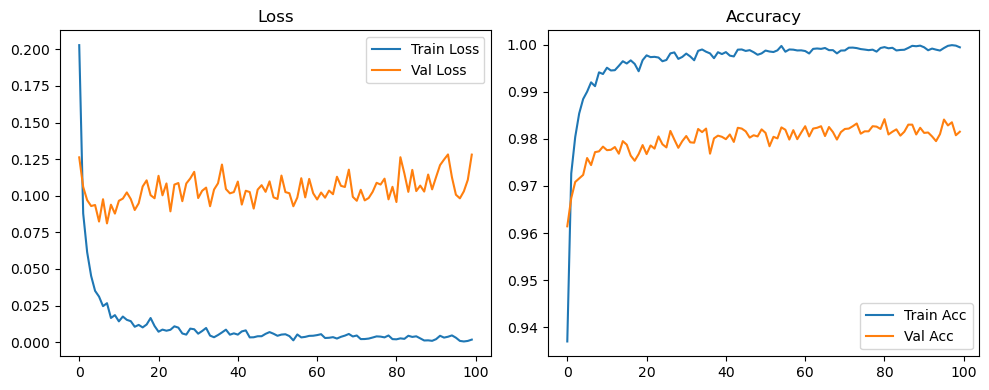

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2535, Acc: 0.9233 | Val Loss: 0.1359, Acc: 0.9578


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9603 | Val Loss: 0.1014, Acc: 0.9704


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 0.0928, Acc: 0.9725


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9743 | Val Loss: 0.0863, Acc: 0.9738


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.0830, Acc: 0.9752


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9808 | Val Loss: 0.0793, Acc: 0.9771


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9825 | Val Loss: 0.0748, Acc: 0.9786


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.0790, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9854 | Val Loss: 0.0720, Acc: 0.9808


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9863 | Val Loss: 0.0847, Acc: 0.9769


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9887 | Val Loss: 0.0738, Acc: 0.9792


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0785, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9897 | Val Loss: 0.0896, Acc: 0.9781


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.0850, Acc: 0.9797


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.0770, Acc: 0.9797


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0804, Acc: 0.9789


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0792, Acc: 0.9795


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9921 | Val Loss: 0.0781, Acc: 0.9796


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.0750, Acc: 0.9805


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0752, Acc: 0.9784


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0778, Acc: 0.9804


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9922 | Val Loss: 0.0746, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0743, Acc: 0.9821


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0829, Acc: 0.9808


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0818, Acc: 0.9808


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0890, Acc: 0.9804


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0778, Acc: 0.9815


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0819, Acc: 0.9810


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0833, Acc: 0.9811


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0895, Acc: 0.9808


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0739, Acc: 0.9821


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0767, Acc: 0.9815


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0859, Acc: 0.9811


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0835, Acc: 0.9816


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.0786, Acc: 0.9818


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.0802, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0833, Acc: 0.9818


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0781, Acc: 0.9829


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0728, Acc: 0.9833


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0854, Acc: 0.9808


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0860, Acc: 0.9815


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0777, Acc: 0.9825


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0779, Acc: 0.9835


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0819, Acc: 0.9822


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0804, Acc: 0.9838


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0819, Acc: 0.9813


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0902, Acc: 0.9809


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0789, Acc: 0.9832


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0853, Acc: 0.9824


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0873, Acc: 0.9820


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0779, Acc: 0.9821


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0811, Acc: 0.9817


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0869, Acc: 0.9808


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0899, Acc: 0.9826


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0883, Acc: 0.9816


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0908, Acc: 0.9814


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0793, Acc: 0.9826


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0868, Acc: 0.9824


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0899, Acc: 0.9820


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0891, Acc: 0.9830


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.0800, Acc: 0.9833


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0843, Acc: 0.9835


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0874, Acc: 0.9825


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0896, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0851, Acc: 0.9833


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0825, Acc: 0.9833


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0880, Acc: 0.9813


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0810, Acc: 0.9844


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0888, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0835, Acc: 0.9832


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0873, Acc: 0.9821


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0825, Acc: 0.9817


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0856, Acc: 0.9831


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0843, Acc: 0.9822


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0818, Acc: 0.9828


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0835, Acc: 0.9818


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0828, Acc: 0.9835


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0902, Acc: 0.9817


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0771, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0821, Acc: 0.9822


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0891, Acc: 0.9819


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0945, Acc: 0.9824


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0874, Acc: 0.9822


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0895, Acc: 0.9828


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0907, Acc: 0.9822


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0917, Acc: 0.9825


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0885, Acc: 0.9827


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0909, Acc: 0.9822


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1049, Acc: 0.9821


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0968, Acc: 0.9818


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0916, Acc: 0.9832


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0847, Acc: 0.9824


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0850, Acc: 0.9830


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0926, Acc: 0.9828


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0861, Acc: 0.9831


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0882, Acc: 0.9823


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.0895, Acc: 0.9818


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0848, Acc: 0.9828


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0925, Acc: 0.9818


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0879, Acc: 0.9829


Final Test Loss: 0.0876 Accuracy: 0.9853


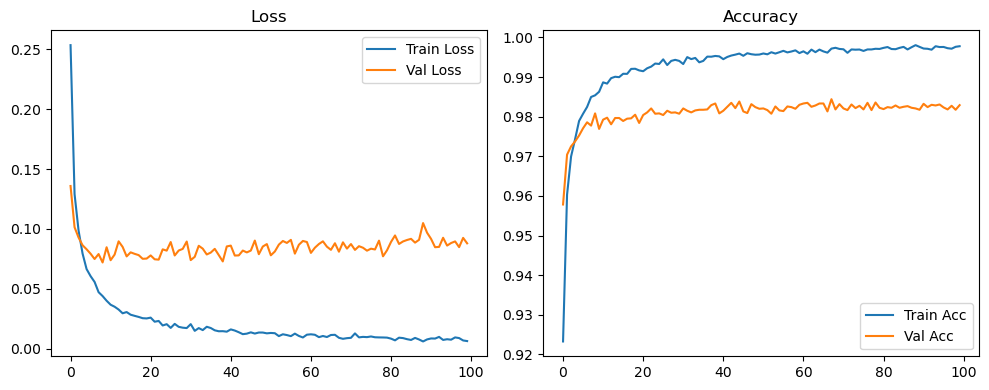

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4202, Acc: 0.8726 | Val Loss: 0.1672, Acc: 0.9500


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2323, Acc: 0.9323 | Val Loss: 0.1257, Acc: 0.9629


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1919, Acc: 0.9433 | Val Loss: 0.1135, Acc: 0.9652


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1646, Acc: 0.9511 | Val Loss: 0.1056, Acc: 0.9685


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1494, Acc: 0.9565 | Val Loss: 0.0944, Acc: 0.9708


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1372, Acc: 0.9590 | Val Loss: 0.0876, Acc: 0.9736


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1238, Acc: 0.9624 | Val Loss: 0.0832, Acc: 0.9746


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1185, Acc: 0.9645 | Val Loss: 0.0803, Acc: 0.9764


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1116, Acc: 0.9660 | Val Loss: 0.0786, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1072, Acc: 0.9670 | Val Loss: 0.0862, Acc: 0.9752


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9690 | Val Loss: 0.0817, Acc: 0.9768


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1025, Acc: 0.9686 | Val Loss: 0.0749, Acc: 0.9773


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9716 | Val Loss: 0.0859, Acc: 0.9763


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0941, Acc: 0.9719 | Val Loss: 0.0771, Acc: 0.9769


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0924, Acc: 0.9717 | Val Loss: 0.0697, Acc: 0.9784


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0854, Acc: 0.9744 | Val Loss: 0.0743, Acc: 0.9786


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9745 | Val Loss: 0.0732, Acc: 0.9788


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9750 | Val Loss: 0.0764, Acc: 0.9783


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0807, Acc: 0.9748 | Val Loss: 0.0745, Acc: 0.9792


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9755 | Val Loss: 0.0707, Acc: 0.9799


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9768 | Val Loss: 0.0731, Acc: 0.9795


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9773 | Val Loss: 0.0695, Acc: 0.9797


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9768 | Val Loss: 0.0731, Acc: 0.9788


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9778 | Val Loss: 0.0663, Acc: 0.9812


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9779 | Val Loss: 0.0651, Acc: 0.9816


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9797 | Val Loss: 0.0670, Acc: 0.9826


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9799 | Val Loss: 0.0703, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0667, Acc: 0.9795 | Val Loss: 0.0717, Acc: 0.9801


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9791 | Val Loss: 0.0710, Acc: 0.9808


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0630, Acc: 0.9799 | Val Loss: 0.0732, Acc: 0.9809


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9800 | Val Loss: 0.0740, Acc: 0.9798


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9824 | Val Loss: 0.0761, Acc: 0.9801


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9814 | Val Loss: 0.0715, Acc: 0.9810


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9812 | Val Loss: 0.0697, Acc: 0.9814


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9805 | Val Loss: 0.0697, Acc: 0.9805


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9818 | Val Loss: 0.0710, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9835 | Val Loss: 0.0758, Acc: 0.9802


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.0702, Acc: 0.9810


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9827 | Val Loss: 0.0703, Acc: 0.9815


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9831 | Val Loss: 0.0734, Acc: 0.9802


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9832 | Val Loss: 0.0690, Acc: 0.9816


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9841 | Val Loss: 0.0706, Acc: 0.9821


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9838 | Val Loss: 0.0726, Acc: 0.9811


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9842 | Val Loss: 0.0746, Acc: 0.9804


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9832 | Val Loss: 0.0718, Acc: 0.9812


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9830 | Val Loss: 0.0740, Acc: 0.9807


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.0716, Acc: 0.9792


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 0.0703, Acc: 0.9811


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9846 | Val Loss: 0.0741, Acc: 0.9818


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9850 | Val Loss: 0.0750, Acc: 0.9808


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9840 | Val Loss: 0.0753, Acc: 0.9812


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9838 | Val Loss: 0.0689, Acc: 0.9821


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9852 | Val Loss: 0.0726, Acc: 0.9812


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9839 | Val Loss: 0.0749, Acc: 0.9818


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9855 | Val Loss: 0.0710, Acc: 0.9812


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9860 | Val Loss: 0.0732, Acc: 0.9816


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9867 | Val Loss: 0.0777, Acc: 0.9804


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9855 | Val Loss: 0.0766, Acc: 0.9811


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9857 | Val Loss: 0.0765, Acc: 0.9810


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 0.0765, Acc: 0.9808


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 0.0744, Acc: 0.9812


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9869 | Val Loss: 0.0741, Acc: 0.9814


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9866 | Val Loss: 0.0747, Acc: 0.9806


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9864 | Val Loss: 0.0756, Acc: 0.9820


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.0766, Acc: 0.9816


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9866 | Val Loss: 0.0731, Acc: 0.9826


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.0731, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9872 | Val Loss: 0.0748, Acc: 0.9822


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9884 | Val Loss: 0.0701, Acc: 0.9824


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.0678, Acc: 0.9824


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9882 | Val Loss: 0.0732, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9876 | Val Loss: 0.0784, Acc: 0.9816


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9882 | Val Loss: 0.0738, Acc: 0.9825


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9874 | Val Loss: 0.0759, Acc: 0.9816


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.0763, Acc: 0.9819


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 0.0736, Acc: 0.9815


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9882 | Val Loss: 0.0764, Acc: 0.9823


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.0831, Acc: 0.9817


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0754, Acc: 0.9821


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9894 | Val Loss: 0.0745, Acc: 0.9831


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0752, Acc: 0.9822


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9881 | Val Loss: 0.0762, Acc: 0.9812


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.0771, Acc: 0.9812


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9884 | Val Loss: 0.0743, Acc: 0.9822


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.0753, Acc: 0.9817


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9886 | Val Loss: 0.0801, Acc: 0.9799


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0750, Acc: 0.9822


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9888 | Val Loss: 0.0760, Acc: 0.9820


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.0791, Acc: 0.9803


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9895 | Val Loss: 0.0763, Acc: 0.9822


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0803, Acc: 0.9812


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.0728, Acc: 0.9821


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9899 | Val Loss: 0.0711, Acc: 0.9831


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0721, Acc: 0.9824


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9897 | Val Loss: 0.0728, Acc: 0.9830


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.0774, Acc: 0.9820


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.0729, Acc: 0.9829


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.0774, Acc: 0.9830


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0804, Acc: 0.9821


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0795, Acc: 0.9824


Final Test Loss: 0.0774 Accuracy: 0.9841


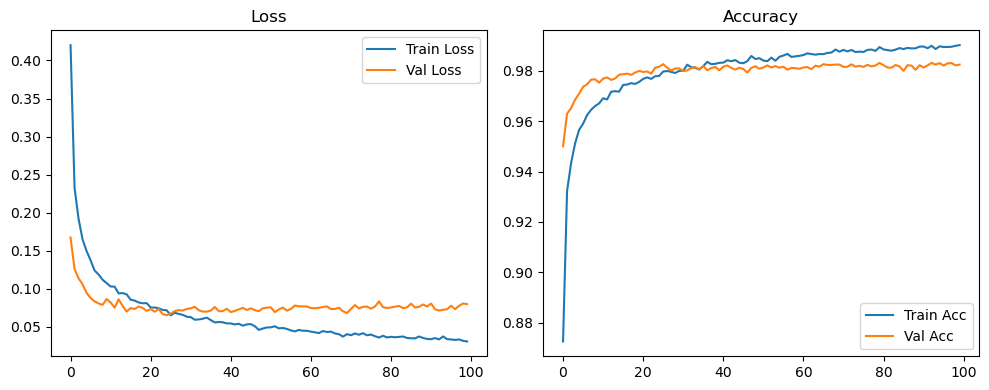

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2029, Acc: 0.9370 | Val Loss: 0.1262, Acc: 0.9614


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0879, Acc: 0.9726 | Val Loss: 0.1060, Acc: 0.9674


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9804 | Val Loss: 0.0970, Acc: 0.9708


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.0930, Acc: 0.9716


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0937, Acc: 0.9723


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0824, Acc: 0.9759


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0976, Acc: 0.9744


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0811, Acc: 0.9772


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9941 | Val Loss: 0.0939, Acc: 0.9773


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0878, Acc: 0.9783


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0965, Acc: 0.9776


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.0981, Acc: 0.9777


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.1023, Acc: 0.9782


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0978, Acc: 0.9768


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0903, Acc: 0.9795


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0949, Acc: 0.9788


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1063, Acc: 0.9764


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1105, Acc: 0.9753


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.1004, Acc: 0.9768


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0983, Acc: 0.9787


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1136, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1003, Acc: 0.9786


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1084, Acc: 0.9779


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0893, Acc: 0.9805


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1076, Acc: 0.9788


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1087, Acc: 0.9782


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0963, Acc: 0.9817


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1084, Acc: 0.9798


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1118, Acc: 0.9781


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1163, Acc: 0.9795


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0984, Acc: 0.9806


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1034, Acc: 0.9792


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1056, Acc: 0.9792


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0928, Acc: 0.9821


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1042, Acc: 0.9814


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1085, Acc: 0.9822


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1213, Acc: 0.9768


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1046, Acc: 0.9801


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1016, Acc: 0.9807


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1025, Acc: 0.9804


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1097, Acc: 0.9799


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0940, Acc: 0.9809


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1034, Acc: 0.9793


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1025, Acc: 0.9823


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0912, Acc: 0.9822


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1042, Acc: 0.9816


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1072, Acc: 0.9802


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1027, Acc: 0.9808


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1098, Acc: 0.9805


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0989, Acc: 0.9820


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0879, Acc: 0.9832


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0892, Acc: 0.9826


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0891, Acc: 0.9827


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0886, Acc: 0.9832


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0871, Acc: 0.9838


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0889, Acc: 0.9833


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0900, Acc: 0.9835


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0884, Acc: 0.9837


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0925, Acc: 0.9841


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0949, Acc: 0.9844


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0987, Acc: 0.9836


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1016, Acc: 0.9837


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0963, Acc: 0.9833


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0922, Acc: 0.9837


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0989, Acc: 0.9831


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1126, Acc: 0.9825


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1060, Acc: 0.9827


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1177, Acc: 0.9827


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1035, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1015, Acc: 0.9822


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1014, Acc: 0.9823


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1058, Acc: 0.9823


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1104, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1064, Acc: 0.9828


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1210, Acc: 0.9815


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1088, Acc: 0.9826


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1094, Acc: 0.9830


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1157, Acc: 0.9830


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1227, Acc: 0.9820


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1122, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1132, Acc: 0.9837


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1125, Acc: 0.9841


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1131, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1115, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1140, Acc: 0.9841


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1171, Acc: 0.9837


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1146, Acc: 0.9837


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1163, Acc: 0.9838


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1107, Acc: 0.9841


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1126, Acc: 0.9846


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1135, Acc: 0.9835


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1159, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1150, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1133, Acc: 0.9838


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1140, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1136, Acc: 0.9837


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1163, Acc: 0.9829


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1153, Acc: 0.9835


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1140, Acc: 0.9838


Final Test Loss: 0.1111 Accuracy: 0.9844


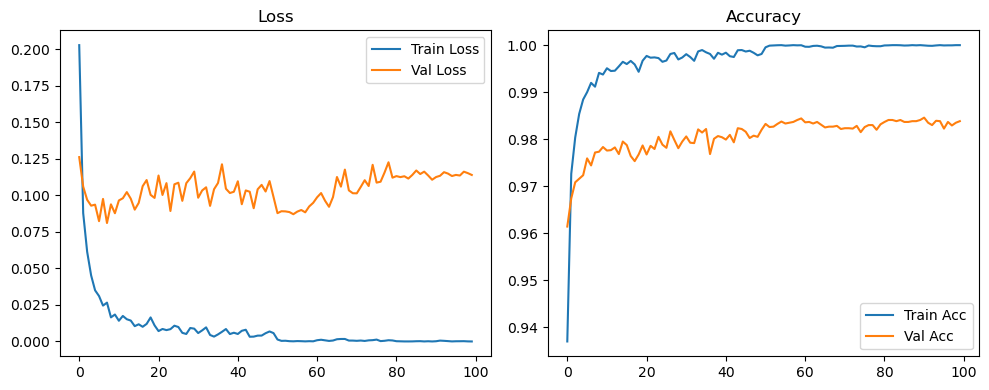

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2535, Acc: 0.9233 | Val Loss: 0.1359, Acc: 0.9578


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9603 | Val Loss: 0.1014, Acc: 0.9704


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 0.0928, Acc: 0.9725


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9743 | Val Loss: 0.0863, Acc: 0.9738


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.0830, Acc: 0.9752


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9808 | Val Loss: 0.0793, Acc: 0.9771


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9825 | Val Loss: 0.0748, Acc: 0.9786


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.0790, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9854 | Val Loss: 0.0720, Acc: 0.9808


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9863 | Val Loss: 0.0847, Acc: 0.9769


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9887 | Val Loss: 0.0738, Acc: 0.9792


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0785, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9897 | Val Loss: 0.0896, Acc: 0.9781


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.0850, Acc: 0.9797


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.0770, Acc: 0.9797


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0804, Acc: 0.9789


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0792, Acc: 0.9795


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9921 | Val Loss: 0.0781, Acc: 0.9796


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.0750, Acc: 0.9805


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0752, Acc: 0.9784


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0778, Acc: 0.9804


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9922 | Val Loss: 0.0746, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0743, Acc: 0.9821


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0829, Acc: 0.9808


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0818, Acc: 0.9808


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0890, Acc: 0.9804


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0778, Acc: 0.9815


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0819, Acc: 0.9810


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0833, Acc: 0.9811


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0895, Acc: 0.9808


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0739, Acc: 0.9821


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0767, Acc: 0.9815


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0859, Acc: 0.9811


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0835, Acc: 0.9816


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.0786, Acc: 0.9818


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.0802, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0833, Acc: 0.9818


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0781, Acc: 0.9829


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0728, Acc: 0.9833


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0854, Acc: 0.9808


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0860, Acc: 0.9815


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0777, Acc: 0.9825


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0779, Acc: 0.9835


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0819, Acc: 0.9822


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0804, Acc: 0.9838


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0819, Acc: 0.9813


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0902, Acc: 0.9809


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0789, Acc: 0.9832


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0853, Acc: 0.9824


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0873, Acc: 0.9820


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0758, Acc: 0.9835


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0753, Acc: 0.9844


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0779, Acc: 0.9838


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0768, Acc: 0.9837


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0788, Acc: 0.9836


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0783, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0799, Acc: 0.9838


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0802, Acc: 0.9833


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0807, Acc: 0.9845


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0845, Acc: 0.9842


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0859, Acc: 0.9846


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0816, Acc: 0.9847


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0920, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0904, Acc: 0.9840


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0886, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0886, Acc: 0.9830


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0893, Acc: 0.9838


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0904, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0945, Acc: 0.9822


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0841, Acc: 0.9840


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0868, Acc: 0.9844


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9840


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0915, Acc: 0.9833


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0937, Acc: 0.9828


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0826, Acc: 0.9842


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0904, Acc: 0.9823


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0870, Acc: 0.9841


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0918, Acc: 0.9836


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0882, Acc: 0.9835


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0867, Acc: 0.9839


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0865, Acc: 0.9842


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0859, Acc: 0.9850


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0873, Acc: 0.9849


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0841, Acc: 0.9851


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0837, Acc: 0.9855


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0860, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0870, Acc: 0.9843


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0914, Acc: 0.9847


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0957, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0903, Acc: 0.9848


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0936, Acc: 0.9848


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0918, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0934, Acc: 0.9840


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0938, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0974, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0922, Acc: 0.9842


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0923, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0895, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0943, Acc: 0.9845


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0927, Acc: 0.9846


Final Test Loss: 0.0921 Accuracy: 0.9859


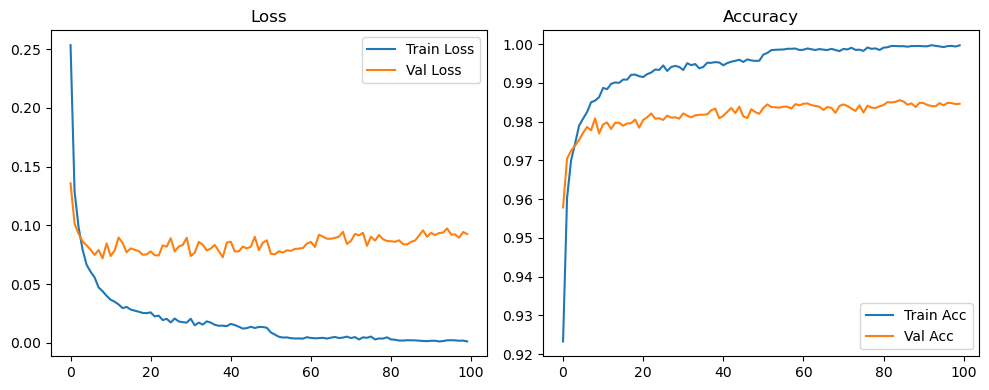

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4202, Acc: 0.8726 | Val Loss: 0.1672, Acc: 0.9500


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2323, Acc: 0.9323 | Val Loss: 0.1257, Acc: 0.9629


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1919, Acc: 0.9433 | Val Loss: 0.1135, Acc: 0.9652


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1646, Acc: 0.9511 | Val Loss: 0.1056, Acc: 0.9685


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1494, Acc: 0.9565 | Val Loss: 0.0944, Acc: 0.9708


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1372, Acc: 0.9590 | Val Loss: 0.0876, Acc: 0.9736


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1238, Acc: 0.9624 | Val Loss: 0.0832, Acc: 0.9746


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1185, Acc: 0.9645 | Val Loss: 0.0803, Acc: 0.9764


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1116, Acc: 0.9660 | Val Loss: 0.0786, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1072, Acc: 0.9670 | Val Loss: 0.0862, Acc: 0.9752


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9690 | Val Loss: 0.0817, Acc: 0.9768


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1025, Acc: 0.9686 | Val Loss: 0.0749, Acc: 0.9773


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9716 | Val Loss: 0.0859, Acc: 0.9763


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0941, Acc: 0.9719 | Val Loss: 0.0771, Acc: 0.9769


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0924, Acc: 0.9717 | Val Loss: 0.0697, Acc: 0.9784


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0854, Acc: 0.9744 | Val Loss: 0.0743, Acc: 0.9786


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9745 | Val Loss: 0.0732, Acc: 0.9788


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9750 | Val Loss: 0.0764, Acc: 0.9783


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0807, Acc: 0.9748 | Val Loss: 0.0745, Acc: 0.9792


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9755 | Val Loss: 0.0707, Acc: 0.9799


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9768 | Val Loss: 0.0731, Acc: 0.9795


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9773 | Val Loss: 0.0695, Acc: 0.9797


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9768 | Val Loss: 0.0731, Acc: 0.9788


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9778 | Val Loss: 0.0663, Acc: 0.9812


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9779 | Val Loss: 0.0651, Acc: 0.9816


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9797 | Val Loss: 0.0670, Acc: 0.9826


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9799 | Val Loss: 0.0703, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0667, Acc: 0.9795 | Val Loss: 0.0717, Acc: 0.9801


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9791 | Val Loss: 0.0710, Acc: 0.9808


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0630, Acc: 0.9799 | Val Loss: 0.0732, Acc: 0.9809


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9800 | Val Loss: 0.0740, Acc: 0.9798


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9824 | Val Loss: 0.0761, Acc: 0.9801


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9814 | Val Loss: 0.0715, Acc: 0.9810


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9812 | Val Loss: 0.0697, Acc: 0.9814


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9805 | Val Loss: 0.0697, Acc: 0.9805


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9818 | Val Loss: 0.0710, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9835 | Val Loss: 0.0758, Acc: 0.9802


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.0702, Acc: 0.9810


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9827 | Val Loss: 0.0703, Acc: 0.9815


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9831 | Val Loss: 0.0734, Acc: 0.9802


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9832 | Val Loss: 0.0690, Acc: 0.9816


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9841 | Val Loss: 0.0706, Acc: 0.9821


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9838 | Val Loss: 0.0726, Acc: 0.9811


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9842 | Val Loss: 0.0746, Acc: 0.9804


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9832 | Val Loss: 0.0718, Acc: 0.9812


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9830 | Val Loss: 0.0740, Acc: 0.9807


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.0716, Acc: 0.9792


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 0.0703, Acc: 0.9811


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9846 | Val Loss: 0.0741, Acc: 0.9818


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9850 | Val Loss: 0.0750, Acc: 0.9808


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9868 | Val Loss: 0.0731, Acc: 0.9820


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0706, Acc: 0.9820


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0722, Acc: 0.9821


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.0733, Acc: 0.9824


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0748, Acc: 0.9817


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0722, Acc: 0.9835


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0743, Acc: 0.9826


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.0768, Acc: 0.9823


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.0752, Acc: 0.9821


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9900 | Val Loss: 0.0768, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9912 | Val Loss: 0.0776, Acc: 0.9825


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9915 | Val Loss: 0.0781, Acc: 0.9818


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.0769, Acc: 0.9822


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.0746, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.0769, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.0779, Acc: 0.9833


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9918 | Val Loss: 0.0796, Acc: 0.9832


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0793, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0770, Acc: 0.9830


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0759, Acc: 0.9835


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0776, Acc: 0.9834


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0825, Acc: 0.9821


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0792, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9915 | Val Loss: 0.0795, Acc: 0.9820


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.0770, Acc: 0.9833


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.0772, Acc: 0.9830


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9926 | Val Loss: 0.0782, Acc: 0.9831


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.0818, Acc: 0.9821


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0801, Acc: 0.9823


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0754, Acc: 0.9827


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0788, Acc: 0.9827


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.0754, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0776, Acc: 0.9833


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9939 | Val Loss: 0.0756, Acc: 0.9840


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0782, Acc: 0.9829


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9945 | Val Loss: 0.0791, Acc: 0.9835


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0756, Acc: 0.9837


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0802, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0791, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0775, Acc: 0.9837


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9950 | Val Loss: 0.0794, Acc: 0.9834


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0801, Acc: 0.9830


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0779, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0770, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0778, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9939 | Val Loss: 0.0786, Acc: 0.9833


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0784, Acc: 0.9838


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0791, Acc: 0.9839


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0822, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0806, Acc: 0.9832


Final Test Loss: 0.0796 Accuracy: 0.9839


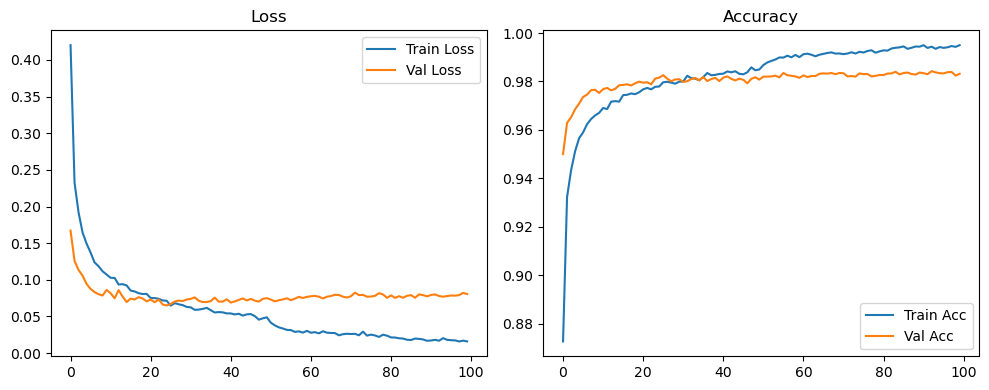

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2048, Acc: 0.9403 | Val Loss: 0.1254, Acc: 0.9609


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0795, Acc: 0.9752 | Val Loss: 0.0947, Acc: 0.9708


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9838 | Val Loss: 0.0903, Acc: 0.9736


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9867 | Val Loss: 0.0902, Acc: 0.9738


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.0831, Acc: 0.9768


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.0866, Acc: 0.9752


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9926 | Val Loss: 0.0872, Acc: 0.9767


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0761, Acc: 0.9791


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0943, Acc: 0.9764


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0855, Acc: 0.9763


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0835, Acc: 0.9800


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0819, Acc: 0.9804


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0935, Acc: 0.9782


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0983, Acc: 0.9772


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0892, Acc: 0.9807


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0961, Acc: 0.9782


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0936, Acc: 0.9802


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0902, Acc: 0.9794


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0964, Acc: 0.9795


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0859, Acc: 0.9801


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0914, Acc: 0.9800


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0859, Acc: 0.9815


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0978, Acc: 0.9787


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.1113, Acc: 0.9768


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.1027, Acc: 0.9782


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0851, Acc: 0.9819


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0861, Acc: 0.9810


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0965, Acc: 0.9802


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0855, Acc: 0.9821


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1086, Acc: 0.9777


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1033, Acc: 0.9803


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1006, Acc: 0.9793


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1096, Acc: 0.9775


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1028, Acc: 0.9789


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0864, Acc: 0.9822


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0979, Acc: 0.9805


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9796


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1079, Acc: 0.9792


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1057, Acc: 0.9783


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1062, Acc: 0.9797


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1066, Acc: 0.9791


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1166, Acc: 0.9788


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1036, Acc: 0.9802


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0950, Acc: 0.9808


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1016, Acc: 0.9820


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0932, Acc: 0.9817


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0908, Acc: 0.9832


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0921, Acc: 0.9828


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0938, Acc: 0.9832


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0960, Acc: 0.9832


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0958, Acc: 0.9838


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1056, Acc: 0.9830


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9955 | Val Loss: 0.1123, Acc: 0.9777


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1003, Acc: 0.9782


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0866, Acc: 0.9823


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0877, Acc: 0.9815


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0844, Acc: 0.9822


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0905, Acc: 0.9826


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1013, Acc: 0.9800


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1121, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1017, Acc: 0.9816


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0968, Acc: 0.9829


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0989, Acc: 0.9822


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0909, Acc: 0.9834


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0977, Acc: 0.9834


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1007, Acc: 0.9821


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0968, Acc: 0.9823


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1047, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1065, Acc: 0.9816


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1036, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1082, Acc: 0.9812


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1051, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0928, Acc: 0.9836


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1015, Acc: 0.9824


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0965, Acc: 0.9811


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0974, Acc: 0.9836


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0887, Acc: 0.9835


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0971, Acc: 0.9832


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0916, Acc: 0.9842


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0947, Acc: 0.9822


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1060, Acc: 0.9807


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1024, Acc: 0.9831


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1003, Acc: 0.9832


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0923, Acc: 0.9833


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1032, Acc: 0.9822


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0983, Acc: 0.9848


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1024, Acc: 0.9845


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1157, Acc: 0.9803


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0979, Acc: 0.9838


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0956, Acc: 0.9836


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1115, Acc: 0.9819


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1025, Acc: 0.9832


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1022, Acc: 0.9828


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0937, Acc: 0.9842


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1124, Acc: 0.9814


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1075, Acc: 0.9824


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1068, Acc: 0.9829


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1005, Acc: 0.9833


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1052, Acc: 0.9832


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0969, Acc: 0.9849


Final Test Loss: 0.0891 Accuracy: 0.9855


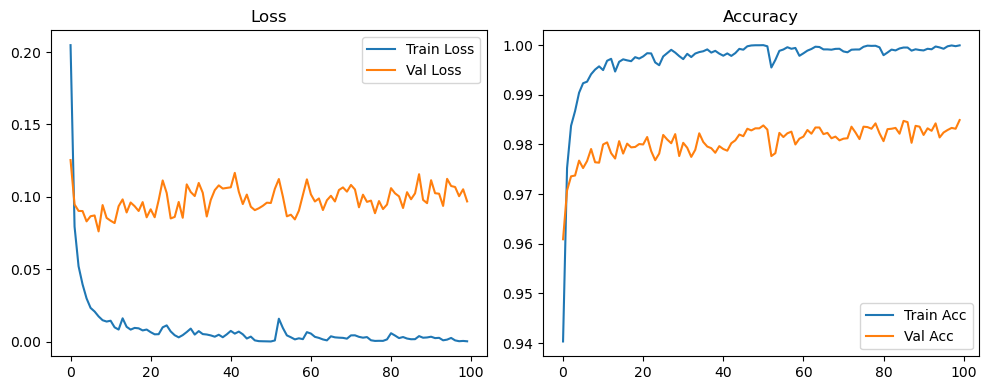

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2719, Acc: 0.9202 | Val Loss: 0.1267, Acc: 0.9608


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1233, Acc: 0.9619 | Val Loss: 0.0937, Acc: 0.9711


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0956, Acc: 0.9705 | Val Loss: 0.0903, Acc: 0.9724


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9761 | Val Loss: 0.0850, Acc: 0.9714


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9794 | Val Loss: 0.0858, Acc: 0.9730


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9814 | Val Loss: 0.0734, Acc: 0.9768


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9829 | Val Loss: 0.0733, Acc: 0.9785


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9854 | Val Loss: 0.0728, Acc: 0.9790


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9859 | Val Loss: 0.0696, Acc: 0.9795


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9875 | Val Loss: 0.0789, Acc: 0.9773


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.0723, Acc: 0.9793


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.0735, Acc: 0.9799


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9901 | Val Loss: 0.0740, Acc: 0.9814


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9897 | Val Loss: 0.0803, Acc: 0.9795


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0689, Acc: 0.9823


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0719, Acc: 0.9808


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0688, Acc: 0.9822


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0691, Acc: 0.9820


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9920 | Val Loss: 0.0707, Acc: 0.9805


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0707, Acc: 0.9818


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0683, Acc: 0.9824


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0680, Acc: 0.9814


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0667, Acc: 0.9823


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0664, Acc: 0.9826


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0744, Acc: 0.9812


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.0731, Acc: 0.9812


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0766, Acc: 0.9819


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0842, Acc: 0.9807


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0765, Acc: 0.9812


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0791, Acc: 0.9821


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0763, Acc: 0.9828


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0748, Acc: 0.9837


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0852, Acc: 0.9808


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0819, Acc: 0.9815


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0821, Acc: 0.9817


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0800, Acc: 0.9822


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0817, Acc: 0.9807


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0789, Acc: 0.9824


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0803, Acc: 0.9815


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0769, Acc: 0.9833


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0766, Acc: 0.9826


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0749, Acc: 0.9839


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.0848, Acc: 0.9815


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0803, Acc: 0.9837


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0775, Acc: 0.9827


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0736, Acc: 0.9828


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0781, Acc: 0.9818


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0727, Acc: 0.9847


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0752, Acc: 0.9845


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0718, Acc: 0.9835


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.0697, Acc: 0.9840


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0800, Acc: 0.9833


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0792, Acc: 0.9832


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0834, Acc: 0.9823


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.0812, Acc: 0.9832


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0860, Acc: 0.9823


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0842, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0761, Acc: 0.9831


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0770, Acc: 0.9844


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0758, Acc: 0.9827


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0769, Acc: 0.9834


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0801, Acc: 0.9828


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0831, Acc: 0.9820


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0850, Acc: 0.9832


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0870, Acc: 0.9828


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0804, Acc: 0.9834


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0800, Acc: 0.9827


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0808, Acc: 0.9833


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0801, Acc: 0.9830


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0764, Acc: 0.9835


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0801, Acc: 0.9835


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0818, Acc: 0.9831


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0769, Acc: 0.9840


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0797, Acc: 0.9831


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0809, Acc: 0.9844


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0889, Acc: 0.9828


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0929, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0840, Acc: 0.9838


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0828, Acc: 0.9827


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0897, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0895, Acc: 0.9809


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0925, Acc: 0.9810


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0822, Acc: 0.9837


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0828, Acc: 0.9840


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0909, Acc: 0.9828


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0869, Acc: 0.9823


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0810, Acc: 0.9839


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0845, Acc: 0.9825


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0821, Acc: 0.9845


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0889, Acc: 0.9834


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0868, Acc: 0.9838


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0865, Acc: 0.9838


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0852, Acc: 0.9832


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0902, Acc: 0.9830


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0908, Acc: 0.9832


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0869, Acc: 0.9833


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0918, Acc: 0.9833


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0883, Acc: 0.9840


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0869, Acc: 0.9842


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0878, Acc: 0.9824


Final Test Loss: 0.0910 Accuracy: 0.9836


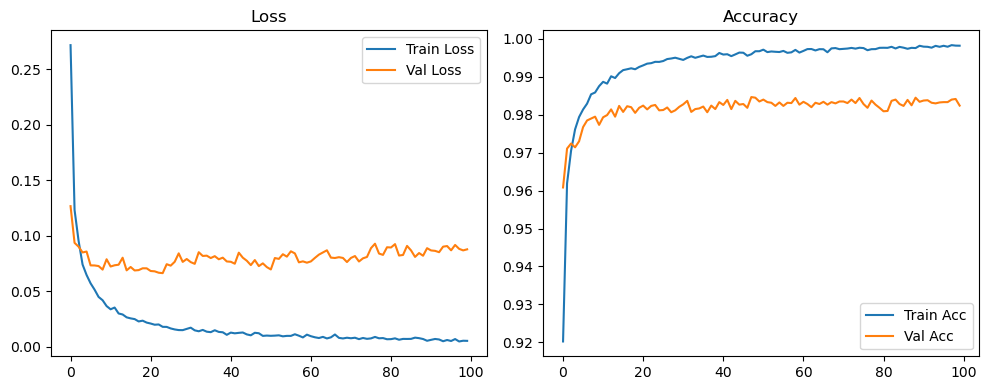

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4732, Acc: 0.8570 | Val Loss: 0.1755, Acc: 0.9467


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2423, Acc: 0.9279 | Val Loss: 0.1329, Acc: 0.9585


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1994, Acc: 0.9406 | Val Loss: 0.1196, Acc: 0.9633


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1730, Acc: 0.9480 | Val Loss: 0.1025, Acc: 0.9693


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1517, Acc: 0.9551 | Val Loss: 0.0943, Acc: 0.9703


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1429, Acc: 0.9568 | Val Loss: 0.0891, Acc: 0.9724


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1287, Acc: 0.9606 | Val Loss: 0.0893, Acc: 0.9739


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1223, Acc: 0.9628 | Val Loss: 0.0869, Acc: 0.9725


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1163, Acc: 0.9657 | Val Loss: 0.0842, Acc: 0.9744


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1067, Acc: 0.9676 | Val Loss: 0.0838, Acc: 0.9756


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.0750, Acc: 0.9793


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1010, Acc: 0.9699 | Val Loss: 0.0780, Acc: 0.9768


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0953, Acc: 0.9702 | Val Loss: 0.0776, Acc: 0.9781


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0954, Acc: 0.9706 | Val Loss: 0.0726, Acc: 0.9782


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0889, Acc: 0.9719 | Val Loss: 0.0695, Acc: 0.9800


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0809, Acc: 0.9741 | Val Loss: 0.0690, Acc: 0.9811


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0818, Acc: 0.9746 | Val Loss: 0.0704, Acc: 0.9792


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0806, Acc: 0.9754 | Val Loss: 0.0709, Acc: 0.9801


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0797, Acc: 0.9758 | Val Loss: 0.0707, Acc: 0.9796


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9763 | Val Loss: 0.0717, Acc: 0.9794


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9768 | Val Loss: 0.0718, Acc: 0.9801


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0697, Acc: 0.9784 | Val Loss: 0.0683, Acc: 0.9808


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0720, Acc: 0.9775 | Val Loss: 0.0697, Acc: 0.9792


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0687, Acc: 0.9783 | Val Loss: 0.0678, Acc: 0.9810


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0686, Acc: 0.9785 | Val Loss: 0.0661, Acc: 0.9808


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9801 | Val Loss: 0.0724, Acc: 0.9791


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9800 | Val Loss: 0.0711, Acc: 0.9806


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9802 | Val Loss: 0.0688, Acc: 0.9798


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0594, Acc: 0.9818 | Val Loss: 0.0704, Acc: 0.9812


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9804 | Val Loss: 0.0685, Acc: 0.9802


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9815 | Val Loss: 0.0671, Acc: 0.9806


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9829 | Val Loss: 0.0703, Acc: 0.9803


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9822 | Val Loss: 0.0730, Acc: 0.9812


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0588, Acc: 0.9821 | Val Loss: 0.0670, Acc: 0.9810


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 0.0691, Acc: 0.9798


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9825 | Val Loss: 0.0680, Acc: 0.9809


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9841 | Val Loss: 0.0690, Acc: 0.9813


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9838 | Val Loss: 0.0678, Acc: 0.9802


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9841 | Val Loss: 0.0677, Acc: 0.9806


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0529, Acc: 0.9836 | Val Loss: 0.0689, Acc: 0.9821


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9840 | Val Loss: 0.0679, Acc: 0.9805


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9853 | Val Loss: 0.0713, Acc: 0.9804


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9843 | Val Loss: 0.0686, Acc: 0.9822


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9855 | Val Loss: 0.0686, Acc: 0.9810


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9855 | Val Loss: 0.0697, Acc: 0.9815


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9850 | Val Loss: 0.0695, Acc: 0.9812


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 0.0678, Acc: 0.9822


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9862 | Val Loss: 0.0701, Acc: 0.9817


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9853 | Val Loss: 0.0680, Acc: 0.9822


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 0.0717, Acc: 0.9808


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9856 | Val Loss: 0.0703, Acc: 0.9807


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9858 | Val Loss: 0.0692, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9867 | Val Loss: 0.0694, Acc: 0.9812


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9865 | Val Loss: 0.0736, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.0749, Acc: 0.9816


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9871 | Val Loss: 0.0733, Acc: 0.9821


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.0736, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9858 | Val Loss: 0.0705, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0747, Acc: 0.9811


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.0677, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0745, Acc: 0.9816


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0739, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9872 | Val Loss: 0.0731, Acc: 0.9819


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0731, Acc: 0.9826


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9871 | Val Loss: 0.0721, Acc: 0.9822


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0782, Acc: 0.9813


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9876 | Val Loss: 0.0779, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0756, Acc: 0.9813


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.0733, Acc: 0.9814


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.0758, Acc: 0.9807


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.0753, Acc: 0.9810


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0748, Acc: 0.9816


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9879 | Val Loss: 0.0741, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0738, Acc: 0.9820


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0733, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9887 | Val Loss: 0.0723, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.0729, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0767, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0694, Acc: 0.9825


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0705, Acc: 0.9822


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9888 | Val Loss: 0.0790, Acc: 0.9815


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0740, Acc: 0.9808


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0779, Acc: 0.9814


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0750, Acc: 0.9822


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9897 | Val Loss: 0.0752, Acc: 0.9810


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0718, Acc: 0.9820


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.0730, Acc: 0.9811


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0768, Acc: 0.9821


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.0756, Acc: 0.9813


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.0755, Acc: 0.9824


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9900 | Val Loss: 0.0778, Acc: 0.9811


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0772, Acc: 0.9822


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0791, Acc: 0.9813


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0776, Acc: 0.9808


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.0783, Acc: 0.9813


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0793, Acc: 0.9814


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0782, Acc: 0.9807


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.0774, Acc: 0.9811


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.0803, Acc: 0.9805


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.0794, Acc: 0.9818


Final Test Loss: 0.0690 Accuracy: 0.9836


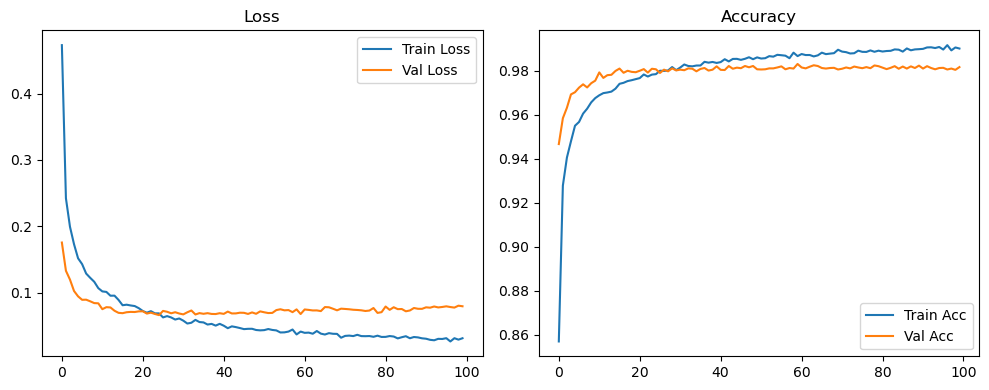

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2327, Acc: 0.9362 | Val Loss: 0.1132, Acc: 0.9660


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0765, Acc: 0.9766 | Val Loss: 0.0887, Acc: 0.9728


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9859 | Val Loss: 0.0868, Acc: 0.9731


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.0864, Acc: 0.9731


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0841, Acc: 0.9758


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0788, Acc: 0.9774


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.0848, Acc: 0.9774


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0903, Acc: 0.9763


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0850, Acc: 0.9765


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0818, Acc: 0.9782


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0903, Acc: 0.9773


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0811, Acc: 0.9788


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0880, Acc: 0.9792


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0927, Acc: 0.9787


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0840, Acc: 0.9795


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0892, Acc: 0.9782


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0936, Acc: 0.9771


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0976, Acc: 0.9766


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0911, Acc: 0.9777


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0891, Acc: 0.9796


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0816, Acc: 0.9808


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0836, Acc: 0.9820


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0879, Acc: 0.9785


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0903, Acc: 0.9794


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0826, Acc: 0.9808


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0892, Acc: 0.9799


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0874, Acc: 0.9814


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0896, Acc: 0.9794


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0894, Acc: 0.9810


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0884, Acc: 0.9800


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0920, Acc: 0.9810


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0822, Acc: 0.9831


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0881, Acc: 0.9832


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0817, Acc: 0.9822


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0933, Acc: 0.9806


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0939, Acc: 0.9823


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1083, Acc: 0.9775


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0948, Acc: 0.9803


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0982, Acc: 0.9808


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0955, Acc: 0.9813


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0987, Acc: 0.9813


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0883, Acc: 0.9827


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0949, Acc: 0.9816


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0946, Acc: 0.9826


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0901, Acc: 0.9812


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0952, Acc: 0.9803


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0905, Acc: 0.9821


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1059, Acc: 0.9794


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1008, Acc: 0.9808


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1081, Acc: 0.9797


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0986, Acc: 0.9798


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0917, Acc: 0.9827


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0958, Acc: 0.9820


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0971, Acc: 0.9821


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0847, Acc: 0.9832


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0859, Acc: 0.9830


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0834, Acc: 0.9838


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0839, Acc: 0.9838


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0820, Acc: 0.9839


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0822, Acc: 0.9838


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0834, Acc: 0.9838


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0825, Acc: 0.9838


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0835, Acc: 0.9840


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0830, Acc: 0.9839


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0853, Acc: 0.9838


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0835, Acc: 0.9840


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1013, Acc: 0.9828


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9927 | Val Loss: 0.1108, Acc: 0.9753


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0880, Acc: 0.9802


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0835, Acc: 0.9818


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0754, Acc: 0.9832


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0768, Acc: 0.9831


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0757, Acc: 0.9839


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0740, Acc: 0.9844


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0743, Acc: 0.9839


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0737, Acc: 0.9847


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0789, Acc: 0.9840


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1163, Acc: 0.9772


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0930, Acc: 0.9800


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0908, Acc: 0.9811


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1009, Acc: 0.9801


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0921, Acc: 0.9810


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0883, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0879, Acc: 0.9821


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0873, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1012, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0972, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0908, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0975, Acc: 0.9824


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0929, Acc: 0.9816


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0894, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0895, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0901, Acc: 0.9838


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0894, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1000, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0999, Acc: 0.9811


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1348, Acc: 0.9762


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0892, Acc: 0.9820


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0950, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0901, Acc: 0.9826


Final Test Loss: 0.0933 Accuracy: 0.9834


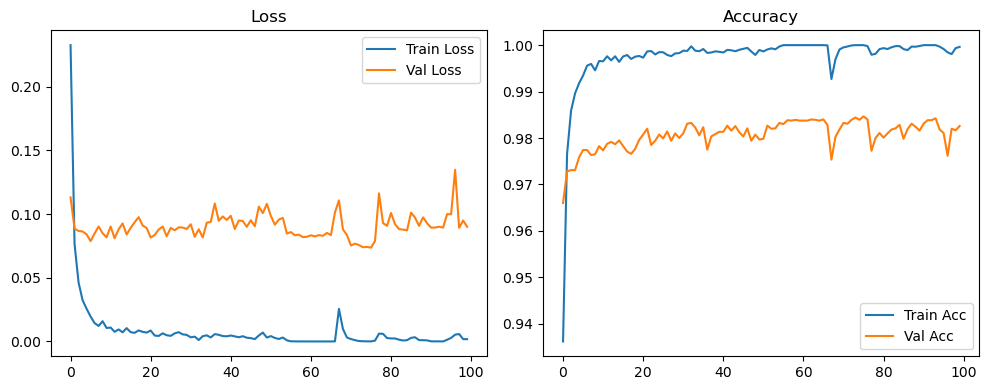

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3196, Acc: 0.9106 | Val Loss: 0.1305, Acc: 0.9590


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1283, Acc: 0.9602 | Val Loss: 0.0951, Acc: 0.9710


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0965, Acc: 0.9707 | Val Loss: 0.0931, Acc: 0.9711


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0768, Acc: 0.9753 | Val Loss: 0.0780, Acc: 0.9752


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9792 | Val Loss: 0.0754, Acc: 0.9762


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9806 | Val Loss: 0.0721, Acc: 0.9774


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9828 | Val Loss: 0.0773, Acc: 0.9762


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9854 | Val Loss: 0.0670, Acc: 0.9789


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9868 | Val Loss: 0.0696, Acc: 0.9796


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9879 | Val Loss: 0.0705, Acc: 0.9781


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9887 | Val Loss: 0.0706, Acc: 0.9794


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.0689, Acc: 0.9803


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0722, Acc: 0.9792


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9901 | Val Loss: 0.0751, Acc: 0.9802


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0696, Acc: 0.9808


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.0673, Acc: 0.9815


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9918 | Val Loss: 0.0689, Acc: 0.9813


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0707, Acc: 0.9803


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.0727, Acc: 0.9814


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9924 | Val Loss: 0.0722, Acc: 0.9800


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9938 | Val Loss: 0.0677, Acc: 0.9824


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.0678, Acc: 0.9830


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0738, Acc: 0.9806


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9926 | Val Loss: 0.0659, Acc: 0.9833


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0756, Acc: 0.9816


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0732, Acc: 0.9814


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.0763, Acc: 0.9818


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9951 | Val Loss: 0.0759, Acc: 0.9812


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0731, Acc: 0.9828


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0730, Acc: 0.9828


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9948 | Val Loss: 0.0684, Acc: 0.9823


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0775, Acc: 0.9809


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0743, Acc: 0.9816


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0739, Acc: 0.9830


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0733, Acc: 0.9821


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0712, Acc: 0.9832


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0654, Acc: 0.9840


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0697, Acc: 0.9835


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0726, Acc: 0.9828


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0724, Acc: 0.9833


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0734, Acc: 0.9821


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0715, Acc: 0.9832


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0751, Acc: 0.9825


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0744, Acc: 0.9837


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0711, Acc: 0.9851


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0806, Acc: 0.9827


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0730, Acc: 0.9837


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0722, Acc: 0.9842


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0783, Acc: 0.9828


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0771, Acc: 0.9818


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0732, Acc: 0.9829


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0745, Acc: 0.9832


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0744, Acc: 0.9832


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0757, Acc: 0.9827


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0713, Acc: 0.9842


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.0773, Acc: 0.9832


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0761, Acc: 0.9840


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0756, Acc: 0.9841


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9963 | Val Loss: 0.0748, Acc: 0.9838


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0798, Acc: 0.9825


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.0697, Acc: 0.9838


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0763, Acc: 0.9830


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0786, Acc: 0.9827


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0774, Acc: 0.9835


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0736, Acc: 0.9828


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0713, Acc: 0.9840


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0850, Acc: 0.9818


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.0861, Acc: 0.9832


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0812, Acc: 0.9822


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0899, Acc: 0.9818


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0851, Acc: 0.9829


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0874, Acc: 0.9817


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0859, Acc: 0.9835


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0885, Acc: 0.9825


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0792, Acc: 0.9833


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0760, Acc: 0.9838


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0823, Acc: 0.9826


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0856, Acc: 0.9829


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0795, Acc: 0.9833


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0885, Acc: 0.9825


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0848, Acc: 0.9831


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0825, Acc: 0.9829


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0852, Acc: 0.9848


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0816, Acc: 0.9839


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0920, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0902, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0859, Acc: 0.9830


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0883, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0880, Acc: 0.9834


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0837, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0833, Acc: 0.9838


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0842, Acc: 0.9831


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0843, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0817, Acc: 0.9840


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0881, Acc: 0.9839


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0778, Acc: 0.9837


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0835, Acc: 0.9838


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0819, Acc: 0.9845


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0824, Acc: 0.9848


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0890, Acc: 0.9838


Final Test Loss: 0.0841 Accuracy: 0.9837


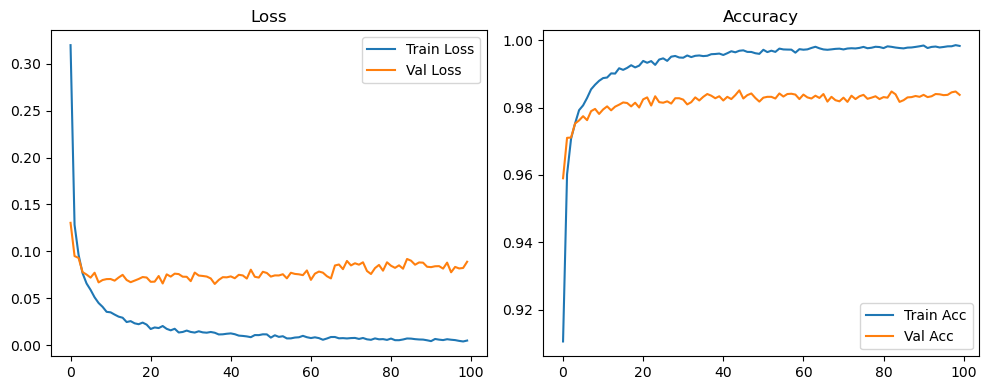

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5797, Acc: 0.8288 | Val Loss: 0.1995, Acc: 0.9395


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2647, Acc: 0.9215 | Val Loss: 0.1482, Acc: 0.9548


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2150, Acc: 0.9354 | Val Loss: 0.1274, Acc: 0.9611


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1862, Acc: 0.9441 | Val Loss: 0.1106, Acc: 0.9662


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1635, Acc: 0.9514 | Val Loss: 0.1037, Acc: 0.9686


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1500, Acc: 0.9542 | Val Loss: 0.0979, Acc: 0.9708


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1378, Acc: 0.9587 | Val Loss: 0.0960, Acc: 0.9715


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1313, Acc: 0.9593 | Val Loss: 0.0917, Acc: 0.9727


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1198, Acc: 0.9642 | Val Loss: 0.0855, Acc: 0.9740


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1124, Acc: 0.9655 | Val Loss: 0.0847, Acc: 0.9748


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1079, Acc: 0.9667 | Val Loss: 0.0836, Acc: 0.9756


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1053, Acc: 0.9681 | Val Loss: 0.0783, Acc: 0.9781


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1011, Acc: 0.9690 | Val Loss: 0.0792, Acc: 0.9768


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0996, Acc: 0.9693 | Val Loss: 0.0770, Acc: 0.9772


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0922, Acc: 0.9715 | Val Loss: 0.0731, Acc: 0.9787


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0874, Acc: 0.9729 | Val Loss: 0.0754, Acc: 0.9786


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0846, Acc: 0.9727 | Val Loss: 0.0720, Acc: 0.9782


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0821, Acc: 0.9746 | Val Loss: 0.0736, Acc: 0.9782


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0800, Acc: 0.9751 | Val Loss: 0.0732, Acc: 0.9780


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0803, Acc: 0.9743 | Val Loss: 0.0773, Acc: 0.9762


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0726, Acc: 0.9772 | Val Loss: 0.0763, Acc: 0.9786


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0723, Acc: 0.9774 | Val Loss: 0.0714, Acc: 0.9788


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0742, Acc: 0.9768 | Val Loss: 0.0739, Acc: 0.9787


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0712, Acc: 0.9779 | Val Loss: 0.0691, Acc: 0.9792


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9791 | Val Loss: 0.0744, Acc: 0.9792


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0653, Acc: 0.9789 | Val Loss: 0.0727, Acc: 0.9798


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9791 | Val Loss: 0.0719, Acc: 0.9804


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0700, Acc: 0.9806


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.0711, Acc: 0.9800


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0636, Acc: 0.9804 | Val Loss: 0.0705, Acc: 0.9812


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9822 | Val Loss: 0.0685, Acc: 0.9803


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9832 | Val Loss: 0.0722, Acc: 0.9808


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9829 | Val Loss: 0.0701, Acc: 0.9812


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0568, Acc: 0.9815 | Val Loss: 0.0676, Acc: 0.9817


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0570, Acc: 0.9824 | Val Loss: 0.0693, Acc: 0.9811


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9814 | Val Loss: 0.0690, Acc: 0.9815


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9849 | Val Loss: 0.0721, Acc: 0.9819


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9831 | Val Loss: 0.0730, Acc: 0.9805


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9835 | Val Loss: 0.0691, Acc: 0.9813


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0527, Acc: 0.9829 | Val Loss: 0.0692, Acc: 0.9818


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9834 | Val Loss: 0.0686, Acc: 0.9816


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0504, Acc: 0.9844 | Val Loss: 0.0684, Acc: 0.9819


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.0696, Acc: 0.9811


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9844 | Val Loss: 0.0715, Acc: 0.9811


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0667, Acc: 0.9814


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9844 | Val Loss: 0.0663, Acc: 0.9828


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9844 | Val Loss: 0.0688, Acc: 0.9818


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 0.0714, Acc: 0.9811


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.0703, Acc: 0.9823


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9857 | Val Loss: 0.0739, Acc: 0.9812


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.0731, Acc: 0.9810


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9863 | Val Loss: 0.0686, Acc: 0.9822


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9867 | Val Loss: 0.0708, Acc: 0.9818


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.0724, Acc: 0.9814


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.0719, Acc: 0.9826


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 0.0716, Acc: 0.9821


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9870 | Val Loss: 0.0723, Acc: 0.9817


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0704, Acc: 0.9821


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 0.0722, Acc: 0.9826


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9877 | Val Loss: 0.0700, Acc: 0.9825


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9879 | Val Loss: 0.0717, Acc: 0.9830


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0732, Acc: 0.9805


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9874 | Val Loss: 0.0705, Acc: 0.9826


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.0713, Acc: 0.9821


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.0707, Acc: 0.9824


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.0722, Acc: 0.9827


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0743, Acc: 0.9817


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.0724, Acc: 0.9827


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9887 | Val Loss: 0.0708, Acc: 0.9828


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9879 | Val Loss: 0.0780, Acc: 0.9822


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0759, Acc: 0.9807


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.0735, Acc: 0.9822


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.0720, Acc: 0.9815


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9894 | Val Loss: 0.0713, Acc: 0.9821


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9902 | Val Loss: 0.0723, Acc: 0.9823


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.0726, Acc: 0.9823


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 0.0728, Acc: 0.9828


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.0766, Acc: 0.9812


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.0725, Acc: 0.9824


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.0740, Acc: 0.9819


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.0797, Acc: 0.9809


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0764, Acc: 0.9810


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.0802, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9902 | Val Loss: 0.0784, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9907 | Val Loss: 0.0771, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0743, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.0761, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9901 | Val Loss: 0.0762, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.0758, Acc: 0.9812


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.0755, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.0768, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.0744, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0749, Acc: 0.9829


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0766, Acc: 0.9823


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0792, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.0764, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.0805, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0787, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.0810, Acc: 0.9813


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9914 | Val Loss: 0.0805, Acc: 0.9821


Final Test Loss: 0.0675 Accuracy: 0.9845


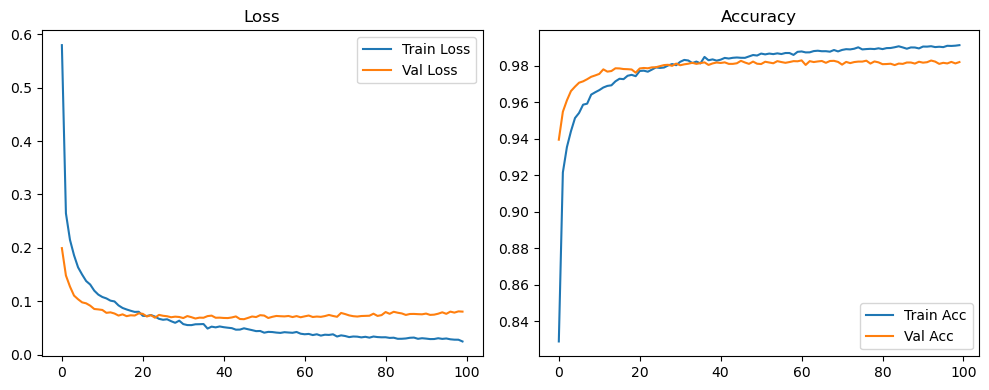

🏆 Best Config: batch64_lr0.01_0.002_0.001_dp0.2 Accuracy: 0.9871


In [8]:
root_path = "MLP_256_float_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)